# Kite Project-Euler

In [1]:
from casadi import *
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
dt = 0.1
N = 50
simu_time=60#sec N=t/dt
X0init=[20/180*pi,30/180*pi,0]

In [3]:
t_f = 10                              # Time horizon
#N = 20                               # number of control intervals
A = 300                               # area of the kite in m^2
Length = 400                          # the length of the tether in m
E_0 = 5                               # base glide ratio [4,6]
v_m = 10                              # wind speed [8,12] in m s^-1
v_A = 0.8                             # amplitude [0,1] in m s^-1
v_f = 0.08                            # frequency [0.05, 0.15] in s^-1
v_off = pi                            # offset [0,2*pi] in rad
c_hat = 0.028                         # related correction coefficient
betha = 0                             # β the relation between the orientation of the boat and the direction of the wind in rad
rhu = 1                               # ρ air density in kg m^-3
w_F = 1e-4                            # the weigth for the tension
w_u = 0.5                             # punishes changes in control input to obtain a smooth behavior


In [4]:
# -----------------------------------------------------------------------------
# Declare model variables
# -----------------------------------------------------------------------------
x = SX.sym("x",3)                     # x_0 is zenith angle, theta   θ     [0, pi/2]
                                      # x_1 is azimuth angle, phi    φ     [-pi/2, pi/2]
                                      # x_2 is orientation, psi      ψ     [0,2pi]
                                      # x_3 is  time
u = SX.sym('u')                   # u is control input, [-10,10] in N
t = SX.sym('t')

In [5]:
v_0 = v_m + v_A*sin(2*pi*v_f*t+v_off)  #equation 1e
E = E_0 - c_hat*(u)**2    #equation 1f
v_a = v_0*E*cos(x[0])      #euqation 1d
P_D = rhu*(v_0**2)/2       #equation 1g
T_F = P_D*A*(cos(x[0])**2)*(E+1)*sqrt(E**2+1)*(cos(x[0])*cos(betha)+sin(x[0])*sin(betha)*sin(x[1])) #equation 1h
x_0_dot = v_a/Length*(cos(x[2])-tan(x[0])/E)     #equation 1a
x_1_dot = -v_a/(Length*sin(x[0]))*sin(x[2])      #equation 1b
x_2_dot = v_a/Length*u+(-v_a/(Length*sin(x[0]))*sin(x[2]))*cos(x[0])    #equation 1c


xdot = vertcat(x_0_dot, x_1_dot, x_2_dot)
Tf = Function("Tf",[x,u,t],[T_F])
system = Function("sys",[x,u,t],[xdot])
h_x = Length*sin(x[0])*cos(x[1])

In [6]:
ode = {'x': x, 'ode': xdot, 'p': vertcat(t,u)}

# By default the solver integrates from 0 to 1. We change the final time to dt.
opts = {'tf': dt}

# Create the solver object.
ode_solver = integrator('F', 'idas', ode, opts)

# MPC Part

In [7]:
wf=1e-4
wu=0.5

ul= SX.sym('ul', 1)
u= SX.sym('u', 1)
t= SX.sym('t', 1)
x= SX.sym('x', 3)

stage_cost = -wf*Tf(x,u,t)+wu*(u-ul)**2
stage_cost_fcn = Function('stage_cost',[x,u,ul,t],[stage_cost])


In [8]:
# state constraints
lb_x = np.asarray([[0,-np.pi/2,0]]).T
ub_x = np.asarray([[np.pi/2,np.pi/2,2*np.pi]]).T
# input constraints
lb_u = -10*np.ones((1,1))
ub_u = 10*np.ones((1,1))

In [9]:
from casadi.tools import *

In [10]:
opt_x = struct_symSX([
    entry('x', shape=3, repeat=[N+1]),
    entry('u', shape=1, repeat=[N])
])
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

In [11]:
wu=0.5
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

x_init = SX.sym('x_init', 3)

x0 = opt_x['x', 0]
t= SX.sym('t', 1)
ul= SX.sym('ul', 1)
g.append(x0-x_init)
lb_g.append(np.zeros((3,1)))
ub_g.append(np.zeros((3,1)))
# 01

for i in range(N):

    if(i==0):
        J += stage_cost_fcn(opt_x['x',i], opt_x['u',i],ul,t) + wu*(opt_x['u',i]-ul)**2
    else:
        J += stage_cost_fcn(opt_x['x',i], opt_x['u',i],opt_x['u',i-1],t) + wu*(opt_x['u',i]-opt_x['u',i-1])**2
  
    x_next = opt_x['x',i] + dt*system(opt_x['x',i], opt_x['u',i],i*dt)
    g.append(x_next - opt_x['x', i+1, 0])
    lb_g.append(np.zeros((3,1)))
    ub_g.append(np.zeros((3,1)))
    g.append(Length*sin(opt_x['x',i,0])*cos(opt_x['x',i,1]))
    lb_g.append(150*np.ones((1,1)))
    ub_g.append(np.inf) 
    # 04
    
g.append(Length*sin(opt_x['x',i+1,0])*cos(opt_x['x',i+1,1]))
lb_g.append(100*np.ones((1,1)))
ub_g.append(np.inf) 
  
g = vertcat(*g)
lb_g = vertcat(*lb_g)
ub_g = vertcat(*ub_g)

prob = {'f':J,'x':vertcat(opt_x),'g':g, 'p':vertcat(x_init,t,ul)}
mpc_solver = nlpsol('solver','ipopt',prob)



# optimization test

In [12]:
# Define the initial condition

x_0 = np.array( X0init).reshape(3,1)
mpc_res = mpc_solver(x0=np.ones(lb_opt_x.shape),p=vertcat(x_0,i*dt,0), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equa

Text(0.5, 0, 'time')

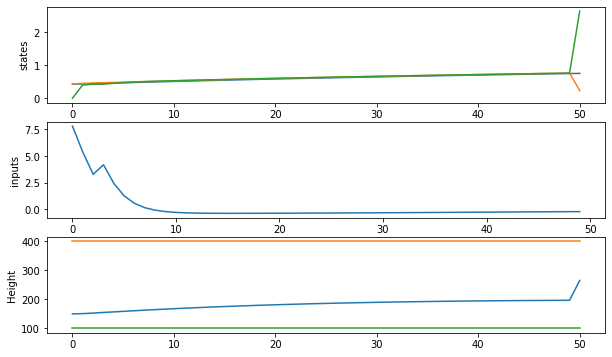

In [13]:
opt_x_k = opt_x(mpc_res['x'])
X_k = horzcat(*opt_x_k['x',:,:])
U_k = horzcat(*opt_x_k['u',:])
fig, ax = plt.subplots(3,1, figsize=(10,6))

h=Length*sin(horzcat(*opt_x_k['x',:,:])[0,:])*cos(horzcat(*opt_x_k['x',:,:])[1,:])
# plot the states
ax[0].plot(X_k.T)
ax[1].plot(U_k.T)
ax[2].plot(h.T)
ax[2].plot(Length*np.ones(h.T.shape))
ax[2].plot(100*np.ones(h.T.shape))
# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[2].set_ylabel('Height')
ax[1].set_xlabel('time')

# MPC Loop

In [14]:
# Define the initial state
x_0 = np.array(X0init).reshape(3,1)
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim =  int(simu_time/dt)

In [15]:
for i in range(N_sim):
    mpc_res = mpc_solver(x0=opt_x_k,p=vertcat(x_0,i*dt,0), lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
    if i>0:
        mpc_res = mpc_solver(p=vertcat(x_0,i*dt,ui), x0=opt_x_k, lbg=lb_g, ubg=ub_g, lbx = lb_opt_x, ubx = ub_opt_x)
        
    opt_x_k = opt_x(mpc_res['x'])
    u_k = opt_x_k['u',0]
    ui=u_k

    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']

    x_0 = x_next

    res_x_mpc.append(x_next)
    res_u_mpc.append(u_k)

res_x_mpc = np.concatenate(res_x_mpc,axis=1)
res_u_mpc = np.concatenate(res_u_mpc, axis=1)


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

  37 -1.0920026e+003 1.77e-001 1.10e+009  -1.7 2.05e+002    -  1.38e-001 2.94e-004h  8
  38 -1.0906694e+003 1.77e-001 8.52e+008  -1.7 2.06e+002    -  2.24e-001 2.91e-004h  8
  39 -1.0893353e+003 1.77e-001 7.87e+008  -1.7 2.04e+002    -  7.61e-002 2.91e-004h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.0880008e+003 1.77e-001 1.00e+007  -1.7 1.99e+002    -  9.90e-001 2.95e-004h  8
  41 -1.0853385e+003 1.77e-001 9.99e+006  -1.7 1.20e+002    -  1.03e-001 9.75e-004h  7
  42 -1.0827078e+003 1.77e-001 9.97e+006  -1.7 7.74e+001    -  1.00e+000 1.48e-003h  7
  43 -1.0809394e+003 1.77e-001 9.89e+006  -1.7 1.12e+001    -  1.00e+000 8.65e-003h  6
  44 -1.0803912e+003 1.77e-001 9.83e+006  -1.7 1.42e+001    -  1.00e+000 5.70e-003h  7
  45 -1.0795813e+003 1.77e-001 9.73e+006  -1.7 2.61e+001    -  1.00e+000 1.03e-002h  6
  46 -9.5828061e+002 1.77e-001 7.32e+006  -1.7 3.37e+001    -  3.53e-001 2.48e-001w  1
  47 -9.4167079e+002 1.77e-001 7.17e+006  -1.7 4.

 147r-7.9810795e+002 2.60e-001 5.46e+001  -0.8 4.36e-001    -  1.97e-001 1.00e+000f  1
 148r-7.9135113e+002 2.61e-001 9.84e+001  -0.8 3.73e+000    -  1.24e-001 1.63e-001f  1
 149r-7.9892764e+002 2.62e-001 6.87e+002  -0.8 4.83e-001    -  4.83e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r-7.9271900e+002 2.63e-001 5.83e+002  -0.8 2.10e+000    -  6.10e-002 1.39e-001f  1
 151r-7.9391668e+002 2.63e-001 3.60e+002  -0.8 1.40e-001    -  5.06e-001 7.84e-001f  1
 152r-7.8453225e+002 2.69e-001 2.92e+002  -0.8 2.53e+000    -  8.01e-002 1.89e-001f  1
 153r-8.0094533e+002 2.50e-001 1.60e+002  -0.8 2.87e-001    -  9.61e-001 7.66e-001h  1
 154r-9.8802872e+002 2.35e-001 1.21e+001  -0.8 5.02e+000    -  7.73e-001 1.00e+000f  1
 155r-9.3213563e+002 2.35e-001 7.00e-002  -0.8 1.85e+000    -  1.00e+000 1.00e+000h  1
 156r-8.7347563e+002 3.02e-001 1.77e+001  -2.2 1.54e+000    -  7.84e-001 9.26e-001f  1
 157r-8.6634619e+002 3.12e-001 1.54e+000  -2.2 1.

  13 -1.1734625e+003 2.55e-001 1.15e+008  -1.7 3.26e-004  11.6 1.00e+000 7.16e-001h  1
  14 -1.1734636e+003 2.53e-001 1.83e+008  -1.7 1.34e-003  11.1 1.00e+000 1.00e+000f  1
  15 -1.1734690e+003 2.48e-001 2.56e+008  -1.7 5.60e-003  10.7 1.00e+000 1.00e+000h  1
  16 -1.1734700e+003 2.24e-001 3.48e+008  -1.7 2.28e-002  10.2 3.34e-001 1.00e+000h  1
  17 -1.1734158e+003 1.97e-001 4.01e+008  -1.7 1.10e-001   9.7 7.77e-004 2.50e-001f  3
  18 -1.1734128e+003 1.94e-001 4.07e+008  -1.7 3.62e-002  10.1 1.00e+000 6.25e-002h  5
  19 -1.1734113e+003 1.94e-001 4.08e+008  -1.7 1.50e-001   9.7 4.86e-002 3.91e-003h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1734110e+003 1.94e-001 4.08e+008  -1.7 4.18e-002  10.1 1.00e+000 3.91e-003h  9
  21r-1.1734110e+003 1.94e-001 9.99e+002  -0.7 0.00e+000   9.6 0.00e+000 4.77e-007R 22
  22r-1.1807146e+003 1.93e-001 9.76e+002  -0.7 1.60e+001    -  9.22e-002 2.28e-002f  1
  23r-1.1804369e+003 1.91e-001 8.63e+002  -0.7 1.

  40r-1.0916137e+003 1.13e-001 1.37e+001  -1.2 2.87e-001    -  9.82e-001 1.00e+000h  1
  41r-1.1066008e+003 1.14e-001 2.85e-002  -1.2 1.57e+000    -  1.00e+000 1.00e+000f  1
  42r-1.0968993e+003 1.32e-001 4.87e+000  -4.3 9.13e-001    -  8.60e-001 9.64e-001f  1
  43r-1.0967962e+003 1.35e-001 6.43e-002  -4.3 4.27e-002    -  1.00e+000 9.73e-001f  1
  44r-1.0930497e+003 1.35e-001 1.80e-005  -4.3 3.10e-001    -  1.00e+000 1.00e+000h  1
  45r-1.0903092e+003 1.35e-001 5.88e-004  -6.4 2.17e-001    -  9.87e-001 1.00e+000h  1
  46r-1.0901523e+003 1.35e-001 4.86e-008  -6.4 1.28e-002    -  1.00e+000 1.00e+000h  1
  47r-1.0889032e+003 1.35e-001 3.86e-005  -9.0 9.44e-002    -  9.94e-001 1.00e+000h  1
  48r-1.0888539e+003 1.35e-001 1.33e-009  -9.0 3.82e-003    -  1.00e+000 1.00e+000h  1
  49r-1.0882783e+003 1.35e-001 5.36e-012  -9.0 4.28e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-1.0880118e+003 1.35e-001 1.19e-012  -9.0 1.

   2 -1.0884159e+003 1.52e-001 6.85e+012  -1.0 5.68e-002  14.0 9.92e-001 1.25e-001h  4
   3 -1.0854559e+003 1.70e-001 4.37e+012  -1.0 1.24e-001  13.5 1.00e+000 1.00e+000s 22
   4 -1.0849895e+003 3.22e-001 3.41e+012  -1.0 3.11e-001  13.0 1.00e+000 1.00e+000s 22
   5 -1.0987042e+003 6.98e-001 2.94e+012  -1.0 8.05e-001  12.6 1.00e+000 1.00e+000s 22
   6r-1.0987042e+003 6.98e-001 9.99e+002   1.4 0.00e+000  12.1 0.00e+000 0.00e+000R  1
   7r-1.1070868e+003 7.04e+000 9.92e+002   1.4 9.33e+003    -  1.27e-002 2.44e-003f  1
   8r-1.0817292e+003 6.87e+000 9.79e+002   1.4 1.60e+002    -  1.40e-002 7.12e-003f  1
   9r-1.0477197e+003 4.77e-001 9.39e+002   1.4 3.23e+002    -  3.86e-002 1.17e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-8.4806463e+002 1.68e-001 8.04e+002   1.4 7.84e+001    -  1.44e-001 8.65e-002f  1
  11r-8.9942948e+002 1.25e-001 5.84e+002   0.7 1.45e+001    -  1.00e+000 1.62e-001f  1
  12r-1.0043381e+003 8.36e-002 1.26e+002   0.7 5.

Number of Lagrangian Hessian evaluations             = 51
Total CPU secs in IPOPT (w/o function evaluations)   =      0.075
Total CPU secs in NLP function evaluations           =      0.014

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (  8.77us) 999.00us (  8.76us)       114
       nlp_g  |   5.00ms ( 43.86us)   4.99ms ( 43.78us)       114
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms ( 34.48us) 997.00us ( 34.38us)        29
  nlp_hess_l  |   6.00ms (125.00us)   5.97ms (124.46us)        48
   nlp_jac_g  |   1.00ms ( 18.18us) 997.00us ( 18.13us)        55
       total  |  91.00ms ( 91.00ms)  91.76ms ( 91.76ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      

  14 -1.1648800e+003 2.84e-002 4.72e-003  -2.5 4.63e-007    -  1.00e+000 1.00e+000s 22
  15 -1.1648800e+003 2.84e-002 1.51e-003  -2.5 1.42e-007    -  1.00e+000 1.00e+000s 22
  16 -1.1648800e+003 2.84e-002 4.99e-004  -2.5 4.51e-008    -  1.00e+000 1.00e+000s 22
  17 -1.1648800e+003 2.84e-002 1.78e-004  -2.5 1.53e-008    -  1.00e+000 1.00e+000s 22
  18 -1.1648800e+003 2.84e-002 6.98e-005  -2.5 5.45e-009    -  1.00e+000 1.00e+000s 22
  19 -1.1648800e+003 2.84e-002 3.16e-005  -2.5 2.07e-009    -  1.00e+000 1.00e+000s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.1648800e+003 2.84e-002 1.70e-005  -2.5 8.47e-010    -  1.00e+000 1.00e+000s 22
  21r-1.1648800e+003 2.84e-002 1.00e+003  -1.5 0.00e+000    -  0.00e+000 0.00e+000R  1
  22r-1.1698791e+003 2.77e-002 9.40e+002  -1.5 3.40e+000    -  2.50e-001 6.00e-002f  1
  23r-1.1838660e+003 3.10e-002 6.01e+002  -1.5 2.11e+000    -  9.91e-001 3.60e-001f  1
  24r-1.1814056e+003 2.77e-002 6.49e-002  -1.5 1.

  65r-5.4690419e+002 3.45e-001 2.47e+001  -0.4 9.88e-002   2.4 1.00e+000 1.00e+000f  1
  66r-5.4751356e+002 3.44e-001 2.47e+001  -0.4 3.71e-002   2.8 1.00e+000 1.00e+000f  1
  67r-5.4933857e+002 3.43e-001 2.47e+001  -0.4 1.11e-001   2.3 1.00e+000 1.00e+000f  1
  68r-5.5002067e+002 3.42e-001 2.47e+001  -0.4 4.17e-002   2.8 1.00e+000 1.00e+000f  1
  69r-5.5206280e+002 3.41e-001 2.47e+001  -0.4 1.25e-001   2.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r-5.5282565e+002 3.40e-001 2.47e+001  -0.4 4.68e-002   2.7 1.00e+000 1.00e+000f  1
  71r-5.5510855e+002 3.38e-001 2.46e+001  -0.4 1.40e-001   2.2 1.00e+000 1.00e+000f  1
  72r-5.5596081e+002 3.38e-001 2.46e+001  -0.4 5.27e-002   2.7 1.00e+000 1.00e+000f  1
  73r-5.5850994e+002 3.36e-001 2.46e+001  -0.4 1.58e-001   2.2 1.00e+000 1.00e+000f  1
  74r-5.5946088e+002 3.35e-001 2.46e+001  -0.4 5.92e-002   2.6 1.00e+000 1.00e+000f  1
  75r-5.6230332e+002 3.33e-001 2.46e+001  -0.4 1.

  11r-1.1601861e+003 1.85e-003 9.73e+002  -2.9 3.88e+000    -  7.31e-002 2.65e-002f  1
  12r-1.1570270e+003 3.22e-003 9.20e+002  -2.9 2.47e+000    -  1.00e+000 5.39e-002f  1
  13r-1.1570886e+003 2.92e-003 3.19e-003  -2.9 2.98e-003    -  1.00e+000 1.00e+000h  1
  14r-1.1569040e+003 2.97e-003 6.52e-003  -4.3 7.68e-003    -  1.00e+000 1.00e+000f  1
  15r-1.1568968e+003 2.87e-003 8.97e-007  -4.3 2.18e-003    -  1.00e+000 1.00e+000h  1
  16r-1.1568911e+003 2.88e-003 1.42e-003  -6.4 2.38e-004    -  1.00e+000 1.00e+000f  1
  17r-1.1568911e+003 2.92e-003 3.31e-010  -6.4 1.05e-003    -  1.00e+000 1.00e+000h  1
  18r-1.1568911e+003 2.93e-003 1.24e-004  -9.0 1.14e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.1568910792836045e+003  -1.1568910792836045e+003
Dual infeasibility......:  4.8621223090989758e+001   4.8621223090989758e+001
Constraint violation....:  2.9933948275389644e-0

   4 -1.1371684e+003 1.59e-002 5.66e+001  -1.7 5.30e-002    -  1.00e+000 1.00e+000h  1
   5 -1.1371561e+003 1.59e-002 7.53e+001  -2.5 2.25e-002    -  1.00e+000 1.00e+000H  1
   6 -1.1371576e+003 1.59e-002 1.06e+001  -2.5 1.09e-002    -  1.00e+000 1.00e+000H  1
   7r-1.1371576e+003 1.59e-002 9.99e+002  -1.8 0.00e+000    -  0.00e+000 4.77e-007R 22
   8r-1.1363689e+003 2.83e-002 9.54e+002  -1.8 2.82e+001    -  5.76e-002 4.54e-002f  1
   9r-1.1371111e+003 3.18e-002 8.88e+002  -1.8 4.03e+000    -  1.00e+000 6.85e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1416893e+003 3.63e-002 3.59e+002  -1.8 7.41e-001    -  1.00e+000 5.96e-001f  1
  11r-1.1404097e+003 3.47e-002 2.91e-002  -1.8 1.36e-001    -  1.00e+000 1.00e+000f  1
  12r-1.1416799e+003 3.65e-002 1.77e+000  -4.0 1.93e-001    -  9.41e-001 7.36e-001f  1
  13r-1.1416231e+003 3.66e-002 8.06e-005  -4.0 3.00e-002    -  1.00e+000 1.00e+000f  1
  14r-1.1416218e+003 3.66e-002 4.14e-003  -6.1 3.

  29r-1.0666138e+003 2.81e-002 1.86e-001  -2.5 3.87e-003   1.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-1.0662094e+003 2.83e-002 7.28e-002  -2.5 1.02e-002   0.9 1.00e+000 1.00e+000h  1
  31r-1.0660587e+003 2.87e-002 1.18e-001  -3.8 3.65e-003   1.3 1.00e+000 1.00e+000f  1
  32r-1.0655657e+003 2.87e-002 8.30e-002  -3.8 1.31e-002   0.8 1.00e+000 1.00e+000f  1
  33r-1.0653798e+003 2.87e-002 8.34e-002  -3.8 4.95e-003   1.2 1.00e+000 1.00e+000h  1
  34r-1.0648182e+003 2.87e-002 8.39e-002  -3.8 1.49e-002   0.7 1.00e+000 1.00e+000f  1
  35r-1.0646062e+003 2.87e-002 8.44e-002  -3.8 5.64e-003   1.2 1.00e+000 1.00e+000h  1
  36r-1.0639654e+003 2.87e-002 8.49e-002  -3.8 1.70e-002   0.7 1.00e+000 1.00e+000f  1
  37r-1.0637233e+003 2.87e-002 8.56e-002  -3.8 6.43e-003   1.1 1.00e+000 1.00e+000h  1
  38r-1.0629905e+003 2.87e-002 8.62e-002  -3.8 1.94e-002   0.6 1.00e+000 1.00e+000f  1
  39r-1.0627134e+003 2.87e-002 8.69e-002  -3.8 7.

  29r-8.2197842e+002 4.74e-002 3.89e-001  -3.8 3.51e-001    -  9.51e-001 9.96e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-8.2199693e+002 4.75e-002 1.49e-006  -3.8 1.36e-002    -  1.00e+000 1.00e+000h  1
  31r-8.2196958e+002 4.82e-002 3.28e-002  -5.7 3.84e-002    -  9.98e-001 1.00e+000f  1
  32r-8.2197229e+002 5.06e-002 4.99e-008  -5.7 5.71e-002    -  1.00e+000 1.00e+000h  1
  33r-8.2197225e+002 5.14e-002 4.79e-011  -5.7 1.81e-002    -  1.00e+000 1.00e+000h  1
  34r-8.2196916e+002 5.39e-002 3.93e-003  -8.6 5.73e-002    -  9.56e-001 1.00e+000h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............: -8.2196927070600543e+002  -8.2196927070600543e+002
Dual infeasibility......:  4.6776973033440157e+001   4.6776973033440157e+001
Constraint violation....:  5.4648160482760777e-002   5.4648160482760777e-002
Complementarity.........:  2.5392713006557922e-009   2.539271300

  16r-9.6142539e+002 7.12e-002 1.31e-004  -3.0 1.68e-002    -  1.00e+000 1.00e+000h  1
  17r-9.6143804e+002 7.14e-002 1.05e-003  -6.7 8.03e-002    -  9.95e-001 1.00e+000f  1
  18r-9.6143876e+002 7.14e-002 1.64e-008  -6.7 8.24e-004    -  1.00e+000 1.00e+000h  1
  19r-9.6143882e+002 7.14e-002 1.18e-005  -9.0 3.37e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -9.6143881630323813e+002  -9.6143881630323813e+002
Dual infeasibility......:  4.6280963954737558e+001   4.6280963954737558e+001
Constraint violation....:  7.1418105329016712e-002   7.1418105329016712e-002
Complementarity.........:  9.0910247827234186e-010   9.0910247827234186e-010
Overall NLP error.......:  4.6280963954737558e+001   4.6280963954737558e+001


Number of objective function evaluations             = 78
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations      

   2 -9.3767871e+002 2.05e-001 4.39e+010  -1.0 3.78e-004  14.0 9.92e-001 1.56e-002h  7
   3r-9.3767871e+002 2.05e-001 9.99e+002  -0.7 0.00e+000    -  0.00e+000 3.77e-007R  7
   4r-9.3273171e+002 2.02e-001 9.31e+002  -0.7 3.96e+000    -  9.93e-001 6.82e-002f  1
   5r-9.3046419e+002 1.75e-001 7.60e-002  -0.7 6.73e-001    -  1.00e+000 1.00e+000f  1
   6r-9.3277017e+002 1.88e-001 1.20e+000  -3.1 6.04e-001    -  9.31e-001 9.60e-001f  1
   7r-9.3264300e+002 2.02e-001 6.08e-005  -3.1 6.05e-002    -  1.00e+000 1.00e+000f  1
   8r-9.3282902e+002 2.02e-001 9.72e-005  -4.7 7.61e-002    -  1.00e+000 1.00e+000f  1
   9r-9.3283636e+002 2.02e-001 5.00e-005  -7.0 3.97e-002    -  9.81e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-9.3283520e+002 2.02e-001 1.37e-009  -7.0 4.38e-002    -  1.00e+000 1.00e+000h  1
  11r-9.3283520e+002 2.02e-001 1.22e-011  -7.0 1.49e-002    -  1.00e+000 1.00e+000h  1
  12r-9.3283520e+002 2.02e-001 1.02e-012  -7.0 1.

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        47
       nlp_g  |   1.00ms ( 21.28us) 997.00us ( 21.21us)        47
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (142.86us)   1.04ms (148.86us)         7
  nlp_hess_l  |   1.00ms ( 62.50us) 954.00us ( 59.62us)        16
   nlp_jac_g  |        0 (       0)        0 (       0)        20
       total  |  31.00ms ( 31.00ms)  30.97ms ( 30.97ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
        

  18r-7.9102571e+002 3.00e-001 2.29e-001  -0.4 2.95e+000    -  1.00e+000 1.00e+000f  1
  19r-7.9354954e+002 3.61e-001 7.38e+000  -1.8 7.73e-001    -  8.45e-001 9.55e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-7.9225252e+002 5.00e-001 1.86e-001  -1.8 2.69e-001    -  1.00e+000 9.56e-001f  1
  21r-7.9257639e+002 5.00e-001 7.69e-003  -2.7 2.12e-001    -  1.00e+000 1.00e+000f  1
  22r-7.9262312e+002 5.01e-001 3.25e-002  -4.0 2.80e-001    -  9.08e-001 1.00e+000f  1
  23r-7.9260523e+002 5.01e-001 6.14e-006  -4.0 8.53e-001    -  1.00e+000 1.00e+000h  1
  24r-7.9260494e+002 5.01e-001 6.40e-007  -4.0 2.09e-001    -  1.00e+000 1.00e+000h  1
  25r-7.9260494e+002 5.01e-001 9.35e-009  -4.0 7.30e-002    -  1.00e+000 1.00e+000h  1
  26r-7.9262975e+002 5.01e-001 1.65e-003  -6.0 3.46e-001    -  9.01e-001 1.00e+000f  1
  27r-7.9262771e+002 5.01e-001 1.01e-007  -6.0 1.41e-001    -  1.00e+000 1.00e+000h  1
  28r-7.9262770e+002 5.01e-001 8.93e-009  -6.0 2.

   8r-8.8739845e+002 5.65e-001 6.97e-003  -1.6 5.53e-001    -  1.00e+000 1.00e+000f  1
   9r-8.8737104e+002 5.86e-001 1.16e-001  -3.7 3.77e-001    -  9.71e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-8.8738744e+002 5.86e-001 1.85e-005  -3.7 4.69e-001    -  1.00e+000 1.00e+000h  1
  11r-8.8738716e+002 5.86e-001 2.24e-006  -3.7 3.35e-001    -  1.00e+000 1.00e+000h  1
  12r-8.8738716e+002 5.86e-001 4.05e-008  -3.7 1.05e-001    -  1.00e+000 1.00e+000h  1
  13r-8.8736951e+002 5.86e-001 3.78e-003  -5.5 3.98e-001    -  8.99e-001 1.00e+000f  1
  14r-8.8737156e+002 5.86e-001 3.12e-007  -5.5 1.87e-001    -  1.00e+000 1.00e+000h  1
  15r-8.8737158e+002 5.86e-001 2.89e-008  -5.5 2.97e-001    -  1.00e+000 1.00e+000h  1
  16r-8.8737158e+002 5.86e-001 3.22e-011  -5.5 3.85e-002    -  1.00e+000 1.00e+000h  1
  17r-8.8737158e+002 5.86e-001 3.21e-011  -5.5 4.49e-004    -  1.00e+000 1.00e+000h  1
  18r-8.8736918e+002 5.86e-001 4.08e-005  -8.2 3.

  13 -8.8909543e+002 5.29e-001 1.90e+008  -1.0 1.47e-003  11.0 9.92e-001 7.88e-002h  1
  14 -8.8909536e+002 5.29e-001 1.90e+008  -1.7 2.94e-004  11.4 1.00e+000 3.09e-003h  1
  15 -8.8909223e+002 5.29e-001 1.72e+008  -1.7 1.39e-003  10.9 1.00e+000 1.16e-001h  1
  16 -8.8907226e+002 5.29e-001 8.13e+007  -1.7 3.59e-004  11.4 1.00e+000 1.00e+000h  1
  17 -8.8906657e+002 5.28e-001 1.04e+008  -1.7 1.82e-003  10.9 1.00e+000 1.00e+000H  1
  18 -8.8906262e+002 5.28e-001 1.25e+008  -1.7 6.20e-004  11.3 1.00e+000 1.00e+000h  1
  19r-8.8906262e+002 5.28e-001 1.00e+003  -0.3 0.00e+000  10.8 0.00e+000 4.77e-007R 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-8.8720767e+002 5.16e-001 6.90e+002  -0.3 1.85e+000    -  9.98e-001 3.10e-001f  1
  21r-8.8380660e+002 4.89e-001 1.26e-001  -0.3 6.74e-001    -  1.00e+000 1.00e+000f  1
  22r-8.8779911e+002 5.85e-001 7.69e+000  -2.5 9.19e-001    -  8.24e-001 9.14e-001f  1
  23r-8.8602991e+002 7.98e-001 2.18e+000  -2.5 2.

   3r-7.9354182e+002 9.67e-001 7.37e+000  -0.0 4.62e-001    -  9.89e-001 1.00e+000f  1
   4r-8.0195046e+002 9.63e-001 1.71e+001  -1.4 4.40e-001    -  1.00e+000 8.77e-001f  1
   5r-7.9848359e+002 9.36e-001 3.67e-003  -1.4 2.99e-001    -  1.00e+000 1.00e+000f  1
   6r-7.9837961e+002 9.70e-001 1.22e-001  -3.2 3.92e-001    -  9.80e-001 1.00e+000f  1
   7r-7.9841462e+002 9.69e-001 1.36e-006  -3.2 6.32e-002    -  1.00e+000 1.00e+000h  1
   8r-7.9840819e+002 9.70e-001 2.29e-003  -4.8 1.41e-001    -  9.79e-001 1.00e+000f  1
   9r-7.9841011e+002 9.70e-001 2.79e-007  -4.8 1.52e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-7.9841010e+002 9.70e-001 9.57e-010  -4.8 1.67e-002    -  1.00e+000 1.00e+000h  1
  11r-7.9840883e+002 9.70e-001 9.07e-005  -7.1 1.23e-001    -  9.69e-001 1.00e+000f  1
  12r-7.9840893e+002 9.70e-001 1.18e-009  -7.1 2.70e-002    -  1.00e+000 1.00e+000h  1
  13r-7.9840893e+002 9.70e-001 1.64e-012  -7.1 4.

  15r-8.2194489e+002 1.14e+000 1.59e-012  -6.9 5.13e-005    -  1.00e+000 1.00e+000h  1
  16r-8.2194400e+002 1.14e+000 7.45e-007  -9.0 2.88e-002    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -8.2194406613849867e+002  -8.2194406613849867e+002
Dual infeasibility......:  4.6390675956171769e+001   4.6390675956171769e+001
Constraint violation....:  1.1441569754427769e+000   1.1441569754427769e+000
Complementarity.........:  9.0909376043156330e-010   9.0909376043156330e-010
Overall NLP error.......:  4.6390675956171769e+001   4.6390675956171769e+001


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 30
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluat

   5r-8.6318876e+002 1.30e+000 1.67e+000  -0.6 6.49e-001    -  1.00e+000 9.90e-001f  1
   6r-8.5764488e+002 1.31e+000 1.18e+000  -2.0 4.31e-001    -  1.00e+000 9.80e-001f  1
   7r-8.5708852e+002 1.31e+000 2.24e-004  -2.0 1.39e-001    -  1.00e+000 1.00e+000f  1
   8r-8.5671224e+002 1.32e+000 8.30e-002  -4.4 2.95e-001    -  9.50e-001 9.92e-001f  1
   9r-8.5671498e+002 1.32e+000 1.24e-005  -4.4 1.85e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-8.5671179e+002 1.32e+000 1.29e-006  -4.4 4.73e-001    -  1.00e+000 1.00e+000h  1
  11r-8.5671178e+002 1.32e+000 2.28e-009  -4.4 8.91e-002    -  1.00e+000 1.00e+000h  1
  12r-8.5671178e+002 1.32e+000 3.57e-010  -4.4 1.27e-003    -  1.00e+000 1.00e+000h  1
  13r-8.5668064e+002 1.32e+000 4.05e-004  -6.7 3.16e-001    -  9.40e-001 1.00e+000f  1
  14r-8.5668277e+002 1.32e+000 1.61e-008  -6.7 6.21e-002    -  1.00e+000 1.00e+000h  1
  15r-8.5668278e+002 1.32e+000 1.29e-010  -6.7 2.


Number of objective function evaluations             = 31
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 31
Number of inequality constraint evaluations          = 31
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 20
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.000
Total CPU secs in NLP function evaluations           =      0.015

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        31
       nlp_g  |        0 (       0)        0 (       0)        31
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |  15.00ms (882.35us)  15.62ms (918.94u

   2r-9.3704010e+002 1.64e+000 9.99e+002   0.2 0.00e+000  14.0 0.00e+000 4.77e-007R 22
   3r-9.2417739e+002 1.64e+000 7.67e+000   0.2 6.30e-001    -  9.89e-001 1.00e+000f  1
   4r-9.4986325e+002 1.64e+000 7.83e+001  -1.2 1.43e+000    -  1.00e+000 7.32e-001f  1
   5r-9.4341418e+002 1.59e+000 2.49e-002  -1.2 1.99e-001    -  1.00e+000 1.00e+000f  1
   6r-9.4326763e+002 1.65e+000 1.93e-001  -2.8 3.23e-001    -  9.86e-001 1.00e+000f  1
   7r-9.4321823e+002 1.64e+000 3.41e-006  -2.8 6.49e-002    -  1.00e+000 1.00e+000f  1
   8r-9.4339159e+002 1.65e+000 2.94e-004  -4.2 6.76e-002    -  1.00e+000 1.00e+000f  1
   9r-9.4336462e+002 1.65e+000 3.01e-007  -4.2 6.55e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-9.4336458e+002 1.65e+000 5.84e-010  -4.2 2.23e-003    -  1.00e+000 1.00e+000h  1
  11r-9.4340267e+002 1.65e+000 1.81e-004  -6.4 5.77e-002    -  9.86e-001 1.00e+000f  1
  12r-9.4339976e+002 1.65e+000 2.11e-009  -6.4 1.

   5r-1.0101364e+003 1.78e+000 4.81e-002  -1.1 8.41e-002    -  1.00e+000 1.00e+000f  1
   6r-1.0087730e+003 1.84e+000 2.24e-001  -2.7 3.92e-001    -  9.88e-001 1.00e+000f  1
   7r-1.0087328e+003 1.84e+000 2.22e-005  -2.7 1.27e-001    -  1.00e+000 1.00e+000h  1
   8r-1.0088974e+003 1.84e+000 6.15e-003  -4.1 1.32e-001    -  9.87e-001 1.00e+000f  1
   9r-1.0088720e+003 1.84e+000 1.82e-006  -4.1 1.15e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0088719e+003 1.84e+000 1.51e-009  -4.1 6.05e-003    -  1.00e+000 1.00e+000h  1
  11r-1.0089101e+003 1.84e+000 7.24e-004  -6.2 1.29e-001    -  9.64e-001 1.00e+000f  1
  12r-1.0089071e+003 1.84e+000 1.98e-008  -6.2 3.09e-002    -  1.00e+000 1.00e+000h  1
  13r-1.0089070e+003 1.84e+000 3.64e-011  -6.2 4.19e-003    -  1.00e+000 1.00e+000h  1
  14r-1.0089107e+003 1.84e+000 3.97e-006  -9.0 2.34e-002    -  9.94e-001 1.00e+000h  1

Number of Iterations....: 14

                  

   2r-1.1933876e+003 2.09e+000 9.99e+002   0.3 0.00e+000  14.0 0.00e+000 4.77e-007R 22
   3r-1.1577792e+003 2.08e+000 1.49e+001   0.3 1.51e+000    -  9.85e-001 1.00e+000f  1
   4r-1.2007662e+003 2.09e+000 1.51e+002  -1.1 2.88e+000    -  9.91e-001 5.47e-001f  1
   5r-1.2071036e+003 2.03e+000 1.51e+001  -1.1 3.96e-001    -  1.00e+000 9.58e-001f  1
   6r-1.2022970e+003 2.01e+000 1.85e-003  -1.1 2.02e-001    -  1.00e+000 1.00e+000f  1
   7r-1.2030846e+003 2.09e+000 2.14e-001  -4.0 5.53e-001    -  9.60e-001 9.67e-001f  1
   8r-1.2031595e+003 2.09e+000 1.47e-004  -4.0 5.45e-002    -  1.00e+000 1.00e+000f  1
   9r-1.2032681e+003 2.09e+000 7.11e-003  -6.0 4.03e-001    -  8.31e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2032676e+003 2.09e+000 8.19e-007  -6.0 1.64e-001    -  1.00e+000 1.00e+000h  1
  11r-1.2032675e+003 2.09e+000 9.60e-008  -6.0 1.30e-001    -  1.00e+000 1.00e+000h  1
  12r-1.2032675e+003 2.09e+000 1.33e-010  -6.0 1.

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1961952e+003 2.45e+000 5.65e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.1938385e+003 2.45e+000 2.11e+002  -1.0 4.08e+002    -  4.60e-002 2.43e-004h  1
   2 -1.1936088e+003 2.45e+000 1.01e+004  -1.0 4.86e+001    -  9.08e-003 1.69e-004h  1
   3 -1.1934321e+003 2.45e+000 2.04e+004  -1.0 4.97e+001    -  9.40e-003 1.42e-00

Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3214649e+003 2.61e+000 5.77e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.3212447e+003 2.61e+000 2.37e+010  -1.0 2.19e+002    -  8.25e-002 4.52e-004h  1
   2 -1.3212345e+003 2.61e+000 2.32e+010  -1.0 2.37e-004  14.0 9.92e-001 1.00e+000H  1
   3 -1.3211928e+003 2.61e+000 2.84e+010  -1.0 8.52e-004  13.5 1.00e+000 1.00e+000h  1
   4 -1.3210938e+003 2.61e+000 3.75e+010  -1.0 5.72e-003  13.0 1.00e+000 6.16e-001H  1
   5 -1.3210928e+003 2.61e+000 3.76e+010  -1.0 1.38e-003  13.5 1.00e+000 1.65e-002h  1
   6r-1.3210928e+003 2.61e+000 1.00e+003   0.4 0.00e+000  13.0 0.00e+000 3.64e-007R  8
   7r-1.3168219e+003 2.61e+000 9.92e+002   0.4 6.89e+

  11r-1.2542764e+003 2.80e+000 5.23e+001  -2.5 8.92e-001    -  8.56e-001 5.16e-001f  1
  12r-1.2530386e+003 2.83e+000 1.04e-002  -2.5 4.89e-001    -  1.00e+000 1.00e+000f  1
  13r-1.2524360e+003 2.83e+000 7.55e-001  -3.7 1.62e-001    -  9.23e-001 1.00e+000f  1
  14r-1.2523980e+003 2.83e+000 4.67e-005  -3.7 2.35e-001    -  1.00e+000 1.00e+000h  1
  15r-1.2523969e+003 2.83e+000 2.31e-006  -3.7 9.18e-002    -  1.00e+000 1.00e+000h  1
  16r-1.2524152e+003 2.83e+000 2.63e-002  -5.6 2.60e-001    -  9.18e-001 1.00e+000f  1
  17r-1.2524132e+003 2.83e+000 1.58e-006  -5.6 9.18e-002    -  1.00e+000 1.00e+000h  1
  18r-1.2524132e+003 2.83e+000 7.15e-008  -5.6 5.76e-002    -  1.00e+000 1.00e+000h  1
  19r-1.2524132e+003 2.83e+000 3.63e-011  -5.6 2.25e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2524159e+003 2.83e+000 1.19e-004  -8.3 9.94e-002    -  9.74e-001 1.00e+000f  1

Number of Iterations....: 20

                  

   7r-1.1423018e+003 2.94e+000 1.62e+001   0.5 1.58e+000    -  9.27e-001 1.00e+000f  1
   8r-1.2538130e+003 2.96e+000 4.65e+001  -0.9 4.86e+000    -  9.54e-001 5.66e-001f  1
   9r-1.2859272e+003 2.96e+000 2.26e+002  -0.9 2.38e+000    -  1.00e+000 4.94e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2739321e+003 2.96e+000 9.94e-001  -0.9 2.16e+000    -  1.00e+000 1.00e+000f  1
  11r-1.2737617e+003 2.98e+000 7.57e+001  -1.6 5.23e-001    -  1.00e+000 5.31e-001f  1
  12r-1.2737361e+003 2.99e+000 1.83e-002  -1.6 2.02e-001    -  1.00e+000 1.00e+000f  1
  13r-1.2733001e+003 3.00e+000 1.43e+000  -3.6 1.20e-001    -  9.49e-001 9.13e-001f  1
  14r-1.2732317e+003 3.00e+000 4.03e-004  -3.6 9.26e-002    -  1.00e+000 1.00e+000f  1
  15r-1.2732313e+003 3.00e+000 4.28e-006  -3.6 2.19e-001    -  1.00e+000 1.00e+000h  1
  16r-1.2732313e+003 3.00e+000 5.70e-008  -3.6 3.68e-002    -  1.00e+000 1.00e+000h  1
  17r-1.2732503e+003 3.00e+000 2.97e-002  -5.5 2.

   3r-1.3914271e+003 3.18e+000 1.00e+003   0.5 0.00e+000    -  0.00e+000 1.05e-008R  2
   4r-1.3901544e+003 3.18e+000 9.92e+002   0.5 6.40e+001    -  2.00e-001 7.04e-003f  1
   5r-1.3611871e+003 3.18e+000 7.83e+002   0.5 4.35e+000    -  5.35e-001 2.10e-001f  1
   6r-1.2304258e+003 3.14e+000 2.07e+002   0.5 4.11e+000    -  5.79e-001 1.00e+000f  1
   7r-1.2452815e+003 3.13e+000 1.58e+001   0.5 1.60e+000    -  9.32e-001 1.00e+000f  1
   8r-1.3668730e+003 3.14e+000 3.81e+001  -0.9 4.94e+000    -  9.51e-001 5.86e-001f  1
   9r-1.4018861e+003 3.14e+000 2.30e+002  -0.9 2.61e+000    -  1.00e+000 4.82e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.3918999e+003 3.14e+000 9.83e-001  -0.9 2.13e+000    -  1.00e+000 1.00e+000f  1
  11r-1.3906989e+003 3.15e+000 7.76e+001  -2.4 8.07e-001    -  9.38e-001 2.87e-001f  1
  12r-1.3915954e+003 3.18e+000 1.59e+001  -2.4 4.57e-001    -  1.00e+000 9.22e-001f  1
  13r-1.3904100e+003 3.18e+000 4.07e-003  -2.4 2.

   7r-1.3838124e+003 3.30e+000 2.37e+001  -0.9 5.04e+000    -  9.46e-001 6.33e-001f  1
   8r-1.4146470e+003 3.32e+000 2.76e+002  -0.9 2.71e+000    -  1.00e+000 4.44e-001f  1
   9r-1.4060799e+003 3.33e+000 1.21e+000  -0.9 2.74e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.4028425e+003 3.35e+000 4.05e+001  -1.6 1.28e+000    -  1.00e+000 3.53e-001f  1
  11r-1.4045315e+003 3.37e+000 6.02e-002  -1.6 3.10e-001    -  1.00e+000 1.00e+000f  1
  12r-1.4035930e+003 3.38e+000 5.46e+000  -3.5 1.31e-001    -  9.62e-001 8.68e-001f  1
  13r-1.4033585e+003 3.38e+000 5.50e-004  -3.5 6.52e-002    -  1.00e+000 1.00e+000f  1
  14r-1.4033510e+003 3.38e+000 2.90e-006  -3.5 1.72e-001    -  1.00e+000 1.00e+000h  1
  15r-1.4033510e+003 3.38e+000 3.10e-008  -3.5 1.97e-002    -  1.00e+000 1.00e+000h  1
  16r-1.4033728e+003 3.38e+000 3.61e-002  -5.3 1.99e-001    -  9.23e-001 1.00e+000f  1
  17r-1.4033702e+003 3.38e+000 2.01e-006  -5.3 9.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.4154576e+003 3.54e+000 8.98e-001  -0.8 2.04e+000    -  1.00e+000 1.00e+000f  1
  11r-1.4124282e+003 3.55e+000 5.17e+001  -2.3 1.19e+000    -  9.31e-001 3.38e-001f  1
  12r-1.4130313e+003 3.58e+000 2.02e+001  -2.3 4.57e-001    -  1.00e+000 9.02e-001f  1
  13r-1.4118486e+003 3.59e+000 4.59e-003  -2.3 2.17e-001    -  1.00e+000 1.00e+000f  1
  14r-1.4118335e+003 3.59e+000 3.39e-001  -5.2 6.27e-002    -  9.41e-001 9.81e-001f  1
  15r-1.4118340e+003 3.59e+000 1.93e-005  -5.2 6.76e-002    -  1.00e+000 1.00e+000h  1
  16r-1.4118342e+003 3.59e+000 2.83e-006  -5.2 2.63e-001    -  1.00e+000 1.00e+000h  1
  17r-1.4118342e+003 3.59e+000 2.61e-008  -5.2 6.18e-002    -  1.00e+000 1.00e+000h  1
  18r-1.4118342e+003 3.59e+000 6.25e-011  -5.2 9.72e-004    -  1.00e+000 1.00e+000h  1
  19r-1.4118382e+003 3.59e+000 3.60e-004  -7.8 9.21e-002    -  9.64e-001 1.00e+000f  1

Number of Iterations....: 19

                  

  10r-1.3187575e+003 3.83e+000 6.91e-001  -0.8 1.91e+000    -  1.00e+000 1.00e+000f  1
  11r-1.3160699e+003 3.84e+000 6.14e+001  -2.3 1.01e+000    -  9.25e-001 3.52e-001f  1
  12r-1.3164969e+003 3.88e+000 1.36e+001  -2.3 4.51e-001    -  1.00e+000 9.28e-001f  1
  13r-1.3157153e+003 3.88e+000 1.93e-003  -2.3 1.17e-001    -  1.00e+000 1.00e+000f  1
  14r-1.3157099e+003 3.88e+000 4.90e-002  -5.1 6.11e-002    -  9.75e-001 9.80e-001f  1
  15r-1.3157125e+003 3.88e+000 1.09e-005  -5.1 5.75e-002    -  1.00e+000 1.00e+000f  1
  16r-1.3157127e+003 3.88e+000 4.45e-007  -5.1 1.17e-001    -  1.00e+000 1.00e+000h  1
  17r-1.3157127e+003 3.88e+000 7.79e-010  -5.1 1.08e-002    -  1.00e+000 1.00e+000h  1
  18r-1.3157173e+003 3.88e+000 3.93e-004  -7.6 5.53e-002    -  9.70e-001 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.3157171041056040e+003  -1.3157171041056040e+003
Dual infeasibility......:  6.178490229

   2r-1.4135301e+003 4.11e+000 9.99e+002   0.6 0.00e+000  16.0 0.00e+000 4.77e-007R 22
   3r-1.4108800e+003 4.11e+000 9.90e+002   0.6 4.88e+001    -  2.46e-001 9.18e-003f  1
   4r-1.3595039e+003 4.10e+000 7.30e+002   0.6 6.89e+000    -  4.17e-001 2.62e-001f  1
   5r-1.1904080e+003 4.05e+000 1.56e+002   0.6 5.52e+000    -  6.60e-001 1.00e+000f  1
   6r-1.3604790e+003 4.10e+000 2.33e+001  -0.1 6.15e+000    -  9.89e-001 7.41e-001f  1
   7r-1.4180229e+003 4.06e+000 1.51e+002  -0.8 4.52e+000    -  9.49e-001 4.75e-001f  1
   8r-1.4291332e+003 4.05e+000 1.93e+001  -0.8 2.02e+000    -  1.00e+000 9.67e-001f  1
   9r-1.4120588e+003 4.05e+000 4.41e+000  -0.8 1.91e+000    -  1.00e+000 8.63e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.4147537e+003 4.10e+000 4.29e+000  -1.5 2.53e-001    -  1.00e+000 9.79e-001f  1
  11r-1.4132311e+003 4.10e+000 1.19e-003  -1.5 1.63e-001    -  1.00e+000 1.00e+000f  1
  12r-1.4130087e+003 4.11e+000 3.44e+000  -3.3 1.

   2r-1.3040462e+003 4.42e+000 9.99e+002   0.6 0.00e+000  14.0 0.00e+000 3.15e-007R 22
   3r-1.3005041e+003 4.41e+000 9.88e+002   0.6 4.11e+001    -  4.28e-002 1.10e-002f  1
   4r-1.2905771e+003 4.41e+000 9.31e+002   0.6 6.15e+000    -  7.55e-001 5.73e-002f  1
   5r-1.0795590e+003 4.33e+000 6.93e+002   0.6 7.88e+000    -  3.42e-001 1.00e+000f  1
   6r-1.1099351e+003 4.25e+000 1.63e+001   0.6 1.97e+000    -  9.54e-001 1.00e+000f  1
   7r-1.2673998e+003 4.32e+000 1.34e+001  -0.8 4.73e+000    -  9.35e-001 7.87e-001f  1
   8r-1.3042900e+003 4.35e+000 3.10e+002  -0.8 3.64e+000    -  1.00e+000 4.20e-001f  1
   9r-1.3081637e+003 4.36e+000 6.98e-001  -0.8 2.59e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.3009128e+003 4.39e+000 4.43e+001  -2.2 2.38e+000    -  9.14e-001 3.93e-001f  1
  11r-1.3027612e+003 4.42e+000 1.03e+001  -2.2 5.67e-001    -  1.00e+000 9.35e-001f  1
  12r-1.3019674e+003 4.42e+000 2.67e-003  -2.2 1.

   7r-1.1184404e+003 4.88e+000 1.68e+001   0.7 2.01e+000    -  9.72e-001 1.00e+000f  1
   8r-1.3216810e+003 4.90e+000 5.72e+000  -0.7 5.01e+000    -  8.23e-001 8.79e-001f  1
   9r-1.3457261e+003 4.91e+000 3.66e+002  -1.4 4.31e+000    -  9.80e-001 2.55e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.3572626e+003 4.95e+000 1.18e+002  -1.4 2.75e+000    -  1.00e+000 7.92e-001f  1
  11r-1.3679568e+003 4.95e+000 4.66e+001  -1.4 6.71e-001    -  8.16e-001 1.00e+000f  1
  12r-1.3634828e+003 4.95e+000 6.39e-002  -1.4 6.41e-001    -  1.00e+000 1.00e+000f  1
  13r-1.3639370e+003 4.96e+000 6.60e-001  -3.2 2.76e-001    -  9.00e-001 9.14e-001f  1
  14r-1.3640078e+003 4.96e+000 6.50e-005  -3.2 6.26e-002    -  1.00e+000 1.00e+000f  1
  15r-1.3640604e+003 4.96e+000 1.13e-002  -7.1 2.74e-002    -  9.87e-001 9.97e-001f  1
  16r-1.3640621e+003 4.96e+000 9.71e-008  -7.1 3.20e-003    -  1.00e+000 1.00e+000h  1
  17r-1.3640627e+003 4.96e+000 2.40e-005  -9.0 1.

  19r-1.2417362e+003 5.18e+000 6.35e-005  -7.0 4.36e-003    -  9.98e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2417356e+003 5.18e+000 1.16e-008  -7.0 3.83e-003    -  1.00e+000 1.00e+000h  1
  21r-1.2417363e+003 5.18e+000 9.50e-006  -9.0 6.87e-003    -  9.45e-001 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -1.2417362220697582e+003  -1.2417362220697582e+003
Dual infeasibility......:  5.8597386203982985e+001   5.8597386203982985e+001
Constraint violation....:  5.1804669271508468e+000   5.1804669271508468e+000
Complementarity.........:  9.4995901253985852e-010   9.4995901253985852e-010
Overall NLP error.......:  5.8597386203982985e+001   5.8597386203982985e+001


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            =

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3113612e+003 5.38e+000 5.75e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.3108422e+003 5.38e+000 7.10e+001  -1.0 7.74e+002    -  8.96e-003 1.28e-004h  1
   2 -1.3107241e+003 5.38e+000 7.05e+003  -1.0 1.31e+002    -  3.44e-003 3.40e-005h  1
   3r-1.3107241e+003 5.38e+000 9.99e+002   0.7 0.00e+000    -  0.00e+000 4.05e-007R 14
   4r-1.3070174e+003 5.38e+000 9.87e+002   0.7 3.78e+001    -  3.27e-001 1.20e-002f  1
   5r-1.2072662e+003 5.36e+000 6.39e+002   0.7 9.59e+000    -  3.36e-001 3.53e-001f  1
   6r-1.0491603e+003 5.31e+000 1.18e+002   0.7 5.34e+000    -  7.36e-001 8.91e-001f  1
   7r-1.1877782e+003 5.33e+000 2.76e+001   0.0 4.75e+000    -  9.40e-001 6.84e-001f  1
   8r-1.2682089e+003 5.33e+000 1.34e+002  -0.7 6.41e+000    -  1.00e+000 4.05e-001f  1
   9r-1

   5r-1.1779922e+003 5.13e+000 9.99e+002   0.7 0.00e+000  16.4 0.00e+000 4.77e-007R 22
   6r-1.1514653e+003 5.12e+000 9.13e+002   0.7 1.09e+001    -  6.20e-001 8.59e-002f  1
   7r-1.0089406e+003 4.90e+000 4.68e+002   0.7 8.94e+000    -  4.52e-001 8.45e-001f  1
   8r-9.9230235e+002 4.64e+000 4.60e+000   0.7 2.26e+000    -  1.00e+000 1.00e+000f  1
   9r-1.1335376e+003 4.86e+000 8.63e+000  -1.4 4.50e+000    -  9.07e-001 8.27e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1642957e+003 4.83e+000 2.66e+002  -1.4 4.31e+000    -  7.68e-001 2.80e-001f  1
  11r-1.2049180e+003 4.49e+000 3.11e+001  -1.4 2.29e+000    -  7.92e-001 8.36e-001f  1
  12 -1.2034981e+003 4.49e+000 5.71e+001  -1.0 6.53e+002    -  1.16e-003 1.36e-004h  6
  13 -1.2024561e+003 4.49e+000 5.71e+001  -1.0 2.57e+002    -  2.25e-003 1.67e-004h  7
  14 -1.2015796e+003 4.49e+000 5.71e+001  -1.0 1.34e+002    -  5.56e-003 1.90e-004h  8
  15 -1.2001034e+003 4.49e+000 5.71e+001  -1.0 1.

   8r-1.0474567e+003 4.46e+000 2.44e+001  -1.4 1.41e+000    -  1.00e+000 9.00e-001f  1
   9r-1.0372533e+003 4.46e+000 1.77e-003  -1.4 2.13e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0333332e+003 4.46e+000 2.81e-003  -3.3 1.51e-001    -  1.00e+000 1.00e+000f  1
  11r-1.0330953e+003 4.46e+000 3.48e-004  -4.9 8.28e-003    -  1.00e+000 1.00e+000f  1
  12r-1.0330807e+003 4.46e+000 5.91e-005  -7.3 4.92e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............: -1.0330851067088145e+003  -1.0330851067088145e+003
Dual infeasibility......:  5.5921035169767940e+001   5.5921035169767940e+001
Constraint violation....:  4.4632183455160774e+000   4.4632183455160774e+000
Complementarity.........:  4.6888555246458269e-008   4.6888555246458269e-008
Overall NLP error.......:  5.5921035169767940e+001   5.5921035169767940e+0

Overall NLP error.......:  5.3183027929799735e+001   5.3183027929799735e+001


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 3
Number of equality constraint evaluations            = 27
Number of inequality constraint evaluations          = 27
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 13
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.013
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        27
       nlp_g  |   1.00ms ( 37.04us) 997.00us ( 36.93us)        27
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)      

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -7.1536138e+002 4.12e+000 5.05e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1r-7.1536138e+002 4.12e+000 9.99e+002   0.6 0.00e+000    -  0.00e+000 3.57e-007R 14
   2r-7.1408300e+002 4.12e+000 9.92e+002   0.6 7.32e+001    -  1.84e-001 7.47e-003f  1
   3r-6.9798870e+002 3.95e+000 6.18e+002   0.6 2.68e+000    -  1.00e+000 3.77e-001f  1
   4r-7.0122206e+002 3.41e+000 3.52e+000   0.6 4.32e+000  

Number of inequality constraint Jacobian evaluations = 21
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in IPOPT (w/o function evaluations)   =      0.023
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        54
       nlp_g  |   1.00ms ( 18.52us) 997.00us ( 18.46us)        54
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |   2.00ms (125.00us)   1.99ms (124.62us)        16
   nlp_jac_g  |        0 (       0)        0 (       0)        22
       total  |  28.00ms ( 28.00ms)  27.92ms ( 27.92ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Nu

  11 4.8260097e+001 3.99e+000 1.69e+005  -1.0 2.37e+001   3.3 5.24e-002 2.35e-003f  9
  12 -2.0014949e+002 9.05e+001 1.12e+007  -1.0 1.68e+001   3.7 3.87e-001 6.38e-001f  1
  13 2.2556754e+002 8.13e+001 1.65e+007  -1.0 1.41e+002   5.1 2.00e-002 8.26e-002h  1
  14 1.8308541e+002 6.43e+001 1.31e+007  -1.0 9.43e+000   4.6 9.76e-002 1.86e-001f  1
  15 1.8283254e+002 6.42e+001 1.31e+007  -1.0 1.85e+001   4.1 7.31e-001 1.92e-003h  1
  16 1.8283068e+002 6.42e+001 1.31e+007  -1.0 4.12e+001   3.6 2.69e-002 1.92e-005h  1
  17 1.8270251e+002 6.43e+001 3.92e+007  -1.0 5.51e+001   3.2 3.62e-001 4.49e-003f  1
  18 2.1327429e+002 7.39e+001 6.25e+007  -1.0 7.55e+001   2.7 4.84e-001 1.22e-001h  1
  19 2.1270041e+002 7.37e+001 7.95e+007  -1.0 1.47e+001   4.0 8.92e-001 6.27e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.1203090e+002 7.25e+001 8.00e+007  -1.0 1.70e+001   3.5 7.79e-001 1.54e-002h  1
  21 1.9106953e+002 5.40e+001 5.80e+007  -1.0 1.35e+001   

  49 -4.8097109e+002 1.48e+002 1.68e+003  -1.0 2.79e+003    -  5.57e-006 5.57e-006s  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-4.8097109e+002 1.48e+002 1.00e+003   1.8 0.00e+000    -  0.00e+000 0.00e+000R  1
  51r-1.0466433e+003 1.44e+002 5.45e+003   1.8 6.38e+002    -  8.00e-002 4.44e-002f  1
  52r-4.5325082e+002 1.31e+002 2.25e+004   1.8 3.23e+002    -  9.11e-002 1.43e-001f  1
  53r-7.3496101e+002 1.21e+002 1.16e+004   1.8 1.05e+001   2.0 5.00e-001 4.26e-001f  1
  54r-6.5664296e+002 7.54e+001 1.50e+003   1.8 3.15e+001   1.5 4.29e-001 5.98e-001f  1
  55 -5.0129620e+002 7.31e+001 1.47e+005  -1.0 3.70e+002    -  1.24e-002 2.42e-002h  1
  56 -5.6031779e+002 7.34e+001 1.60e+005  -1.0 3.04e+002    -  2.95e-004 6.12e-003f  1
  57 -5.2801342e+002 6.86e+001 9.59e+005  -1.0 2.86e+002    -  4.59e-004 5.83e-002h  1
  58 -5.2680742e+002 6.86e+001 3.60e+016  -1.0 4.88e+002    -  1.33e-003 1.69e-003h  1
  59 -5.2679534e+002 6.83e+001 3.97e+016  -1.0 8.

  62 -4.2167116e+002 3.55e+000 1.46e+003  -1.0 7.04e+001    -  6.40e-001 5.80e-004h 11
  63 -4.2075218e+002 3.54e+000 2.37e+003  -1.0 7.00e+001    -  1.00e+000 5.80e-004h 11
  64 3.1972091e+001 9.86e+001 1.39e+006  -1.0 6.94e+001    -  7.33e-001 5.00e-001w  1
  65 6.5311884e+000 4.95e+001 3.19e+006  -1.0 3.20e+000   5.5 3.27e-001 4.72e-001w  1
  66 6.0975403e+000 4.90e+001 3.16e+006  -1.0 8.02e+000   5.0 6.34e-001 8.78e-003w  1
  67 -4.1997015e+002 3.54e+000 3.46e+003  -1.0 1.15e+001   4.5 7.33e-001 4.89e-004h 10
  68 -4.1879249e+002 3.54e+000 5.64e+003  -1.0 6.87e+001    -  1.00e+000 7.28e-004h 10
  69 -4.1795622e+002 3.54e+000 8.63e+003  -1.0 6.74e+001    -  8.36e-001 5.06e-004h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.1724504e+002 3.54e+000 1.41e+004  -1.0 6.60e+001    -  1.00e+000 4.19e-004h 10
  71 -4.1637689e+002 3.54e+000 2.24e+004  -1.0 6.43e+001    -  9.20e-001 4.92e-004h 10
  72 -4.1538094e+002 3.54e+000 3.55e+004  -1.0 6.25e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r-2.4898292e+002 3.95e+000 9.93e-008  -8.7 4.49e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 160

                                   (scaled)                 (unscaled)
Objective...............: -2.4871047927356611e+002  -2.4871047927356611e+002
Dual infeasibility......:  3.6698090077280042e+001   3.6698090077280042e+001
Constraint violation....:  3.9543518960978514e+000   3.9543518960978514e+000
Complementarity.........:  5.9419245875300549e-009   5.9419245875300549e-009
Overall NLP error.......:  3.6698090077280042e+001   3.6698090077280042e+001


Number of objective function evaluations             = 903
Number of objective gradient evaluations             = 132
Number of equality constraint evaluations            = 903
Number of inequality constraint evaluations          = 903
Number of equality constraint Jacobian evaluations   = 164
Number of inequality constraint Jacobian evalua

  54 -3.3179500e+001 7.92e+001 5.19e+006  -1.0 3.18e+001    -  4.86e-001 3.90e-002w  1
  55 -3.3089739e+001 7.90e+001 2.76e+007  -1.0 2.37e+001    -  4.82e-001 1.96e-003w  1
  56 -2.0129298e+002 3.86e+000 1.31e+005  -1.0 2.19e+001    -  4.10e-001 1.24e-003h  9
  57 -2.0084102e+002 3.86e+000 1.36e+005  -1.0 1.84e+001    -  1.00e+000 1.24e-003h 10
  58 -2.0072426e+002 3.86e+000 1.38e+005  -1.0 1.89e+001    -  4.67e-001 3.11e-004h 12
  59 -2.0060616e+002 3.86e+000 1.40e+005  -1.0 1.92e+001    -  1.00e+000 3.11e-004h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -2.0048550e+002 3.86e+000 1.41e+005  -1.0 1.96e+001    -  4.82e-001 3.11e-004h 12
  61 -2.0036385e+002 3.86e+000 1.42e+005  -1.0 1.98e+001    -  1.00e+000 3.11e-004h 12
  62 -2.0024037e+002 3.86e+000 1.42e+005  -1.0 2.01e+001    -  4.97e-001 3.11e-004h 12
  63 -2.0011615e+002 3.86e+000 1.43e+005  -1.0 2.02e+001    -  1.00e+000 3.11e-004h 12
  64 -1.9999059e+002 3.86e+000 1.43e+005  -1.0 2.

 162 -1.7176956e+002 3.70e+000 1.00e+008  -1.0 1.72e+001    -  1.00e+000 1.75e-003h 10
 163 -1.7112655e+002 3.70e+000 1.00e+008  -1.0 1.71e+001    -  1.00e+000 1.79e-003h 10
 164 -1.7047800e+002 3.69e+000 1.00e+008  -1.0 1.70e+001    -  1.00e+000 1.82e-003h 10
 165 -1.6982817e+002 3.69e+000 9.99e+007  -1.0 1.70e+001    -  1.00e+000 1.84e-003h 10
 166 -1.6917926e+002 3.69e+000 9.97e+007  -1.0 1.69e+001    -  1.00e+000 1.84e-003h 10
 167 -1.6853232e+002 3.68e+000 9.95e+007  -1.0 1.68e+001    -  1.00e+000 1.85e-003h 10
 168 -1.6788788e+002 3.68e+000 9.93e+007  -1.0 1.67e+001    -  1.00e+000 1.85e-003h 10
 169 -1.6724620e+002 3.67e+000 9.92e+007  -1.0 1.66e+001    -  1.00e+000 1.86e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 2.9637372e+001 6.62e+001 9.50e+006  -1.0 1.65e+001    -  1.00e+000 9.53e-001w  1
 171 2.6449386e+001 5.85e+001 1.26e+007  -1.0 6.07e+000    -  2.48e-001 1.20e-001w  1
 172 1.5900496e+001 4.11e+001 5.53e+006  -1.0 1.03e

 262 -1.0980086e+002 5.64e+000 2.30e+007  -1.0 6.64e+000   3.7 1.00e+000 4.87e-001w  1
 263 -1.0819707e+002 3.41e+000 2.44e+007  -1.0 2.12e+000   4.1 1.00e+000 4.93e-001w  1
 264 -1.3200773e+002 3.14e+000 7.68e+007  -1.0 8.82e-001   4.6 1.00e+000 1.07e-002h  6
 265 -1.3170438e+002 3.11e+000 7.34e+007  -1.0 7.27e+000   4.1 1.00e+000 2.24e-002h  6
 266 -1.3146679e+002 3.09e+000 7.35e+007  -1.0 1.35e+001   3.6 1.00e+000 1.22e-002h  7
 267 -1.3108925e+002 3.08e+000 7.47e+007  -1.0 1.73e+001   3.1 1.00e+000 9.95e-003h  7
 268 -1.3069221e+002 3.07e+000 7.58e+007  -1.0 2.04e+001   2.7 1.00e+000 4.96e-003h  7
 269 -1.3031466e+002 3.06e+000 7.47e+007  -1.0 1.48e+001   3.1 1.00e+000 9.68e-003h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 -1.3008599e+002 3.04e+000 7.30e+007  -1.0 9.83e+000   3.5 1.00e+000 1.09e-002h  7
 271 -1.2968260e+002 3.03e+000 7.31e+007  -1.0 1.56e+001   3.0 1.00e+000 9.68e-003h  7
 272 -1.2943976e+002 3.01e+000 7.19e+007  -1.0 1.

 377r-3.5296729e+002 3.32e+000 5.38e+000  -1.2 5.75e-003   3.0 1.00e+000 1.00e+000f  1
 378r-3.5291382e+002 3.32e+000 5.38e+000  -1.2 2.16e-003   3.4 1.00e+000 1.00e+000f  1
 379r-3.5275370e+002 3.32e+000 5.39e+000  -1.2 6.48e-003   2.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r-3.5269386e+002 3.32e+000 5.39e+000  -1.2 2.43e-003   3.3 1.00e+000 1.00e+000f  1
 381r-3.5251467e+002 3.32e+000 5.40e+000  -1.2 7.30e-003   2.9 1.00e+000 1.00e+000f  1
 382r-3.5244773e+002 3.32e+000 5.40e+000  -1.2 2.74e-003   3.3 1.00e+000 1.00e+000f  1
 383r-3.5242262e+002 3.32e+000 5.40e+000  -1.2 1.03e-003   3.7 1.00e+000 1.00e+000f  1
 384r-3.5234736e+002 3.32e+000 5.40e+000  -1.2 3.08e-003   3.2 1.00e+000 1.00e+000f  1
 385r-3.5231918e+002 3.32e+000 5.40e+000  -1.2 1.16e-003   3.7 1.00e+000 1.00e+000f  1
 386r-3.5223472e+002 3.32e+000 5.40e+000  -1.2 3.47e-003   3.2 1.00e+000 1.00e+000f  1
 387r-3.5220310e+002 3.32e+000 5.40e+000  -1.2 1.

  69 -3.8218805e+002 3.45e+000 8.67e+004  -1.0 4.92e+001    -  1.00e+000 5.41e-004h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -3.8161700e+002 3.45e+000 1.01e+005  -1.0 4.58e+001    -  1.00e+000 5.42e-004h 11
  71 -3.8107334e+002 3.44e+000 1.09e+005  -1.0 4.33e+001    -  1.00e+000 5.43e-004h 11
  72 -3.8054730e+002 3.44e+000 1.67e+005  -1.0 4.17e+001    -  1.00e+000 5.46e-004h 11
  73 -3.8003087e+002 3.44e+000 2.61e+005  -1.0 4.06e+001    -  1.00e+000 5.51e-004h 11
  74 -5.9097939e+001 7.47e+001 4.38e+006  -1.0 3.98e+001    -  1.00e+000 5.73e-001w  1
  75 -5.9912398e+001 7.19e+001 4.54e+006  -1.0 1.43e+001    -  5.55e-001 4.81e-002w  1
  76 -6.3639352e+001 4.94e+001 3.41e+006  -1.0 9.76e+000    -  5.39e-001 3.46e-001w  1
  77 -3.7951663e+002 3.44e+000 4.07e+005  -1.0 5.38e+000    -  1.00e+000 5.60e-004h 10
  78 -3.7899638e+002 3.44e+000 6.34e+005  -1.0 3.92e+001    -  1.00e+000 5.76e-004h 11
  79 -3.7845997e+002 3.44e+000 9.86e+005  -1.0 3.

 202r-3.9442651e+002 2.60e+000 3.91e+001  -1.9 1.37e-002   2.4 1.00e+000 9.27e-001f  1
 203r-3.9440305e+002 2.59e+000 3.67e+000  -1.9 5.32e-003   2.8 1.00e+000 1.00e+000f  1
 204r-3.9439346e+002 2.59e+000 4.13e+000  -1.9 2.25e-003   3.3 1.00e+000 1.00e+000f  1
 205r-3.9435945e+002 2.58e+000 4.26e+000  -1.9 6.95e-003   2.8 1.00e+000 1.00e+000f  1
 206r-3.9434632e+002 2.58e+000 4.15e+000  -1.9 2.53e-003   3.2 1.00e+000 1.00e+000f  1
 207r-3.9434137e+002 2.58e+000 4.11e+000  -1.9 9.41e-004   3.6 1.00e+000 1.00e+000f  1
 208r-3.9432648e+002 2.58e+000 4.02e+000  -1.9 2.76e-003   3.2 1.00e+000 1.00e+000f  1
 209r-3.9432087e+002 2.58e+000 3.97e+000  -1.9 1.02e-003   3.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r-3.9430396e+002 2.58e+000 3.88e+000  -1.9 3.00e-003   3.1 1.00e+000 1.00e+000f  1
 211r-3.9429759e+002 2.57e+000 3.84e+000  -1.9 1.11e-003   3.5 1.00e+000 1.00e+000f  1
 212r-3.9427841e+002 2.57e+000 3.75e+000  -1.9 3.

 384r-3.9090601e+002 2.36e+000 3.69e+000  -1.9 2.45e-003   3.2 1.00e+000 1.00e+000f  1
 385r-3.9089834e+002 2.37e+000 3.68e+000  -1.9 7.35e-003   2.7 1.00e+000 1.00e+000f  1
 386r-3.9089548e+002 2.37e+000 3.68e+000  -1.9 2.76e-003   3.1 1.00e+000 1.00e+000f  1
 387r-3.9088710e+002 2.38e+000 3.67e+000  -1.9 8.25e-003   2.6 1.00e+000 1.00e+000f  1
 388r-3.9088397e+002 2.38e+000 3.67e+000  -1.9 3.09e-003   3.1 1.00e+000 1.00e+000f  1
 389r-3.9087484e+002 2.39e+000 3.66e+000  -1.9 9.26e-003   2.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r-3.9087144e+002 2.39e+000 3.66e+000  -1.9 3.47e-003   3.0 1.00e+000 1.00e+000f  1
 391r-3.9086153e+002 2.40e+000 3.65e+000  -1.9 1.04e-002   2.5 1.00e+000 1.00e+000f  1
 392r-3.9085782e+002 2.41e+000 3.65e+000  -1.9 3.89e-003   3.0 1.00e+000 1.00e+000f  1
 393r-3.9084710e+002 2.42e+000 3.64e+000  -1.9 1.16e-002   2.5 1.00e+000 1.00e+000f  1
 394r-3.9084309e+002 2.42e+000 3.64e+000  -1.9 4.

Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 31
Total CPU secs in IPOPT (w/o function evaluations)   =      0.049
Total CPU secs in NLP function evaluations           =      0.014

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)       113
       nlp_g  |   6.00ms ( 53.10us)   5.94ms ( 52.60us)       113
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        17
  nlp_hess_l  |   4.00ms (142.86us)   4.12ms (147.11us)        28
   nlp_jac_g  |   4.00ms (111.11us)   3.99ms (110.94us)        36
       total  |  64.00ms ( 64.00ms)  63.83ms ( 63.83ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Nu

   9 -4.2428634e+002 3.06e+000 3.26e+014  -1.0 3.38e-002  16.0 9.91e-001 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-4.2428634e+002 3.06e+000 9.99e+002   0.5 0.00e+000  15.5 0.00e+000 4.77e-007R 22
  11r-4.2345914e+002 3.06e+000 9.94e+002   0.5 1.30e+002    -  1.00e+000 4.90e-003f  1
  12r-3.4738325e+002 3.36e+000 3.30e+001   0.5 5.54e+000    -  1.00e+000 1.00e+000f  1
  13r-2.9391144e+002 3.43e+000 8.19e+000  -0.2 5.52e+000    -  8.64e-001 9.59e-001f  1
  14r-2.7185258e+002 3.53e+000 3.83e+001  -0.9 1.56e+000    -  1.00e+000 8.47e-001f  1
  15r-2.6124504e+002 3.62e+000 1.22e+000  -0.9 1.19e+000    -  1.00e+000 1.00e+000f  1
  16r-2.6161647e+002 3.67e+000 1.20e+000  -1.6 1.10e-001    -  1.00e+000 1.00e+000f  1
  17r-2.5287105e+002 3.67e+000 2.96e-001  -1.6 5.29e-001    -  1.00e+000 1.00e+000f  1
  18r-2.5295686e+002 3.68e+000 6.37e-001  -2.4 2.47e-002    -  1.00e+000 1.00e+000f  1
  19r-2.4796852e+002 3.68e+000 8.33e-002  -2.4 2.

  68 -4.2205033e+002 3.03e+000 7.39e+015  -1.0 1.07e-002  17.8 1.00e+000 1.00e+000h  1
  69 -4.2153910e+002 3.03e+000 6.82e+015  -1.0 2.72e-002  17.4 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.1937738e+002 2.99e+000 4.60e+015  -1.0 5.77e-002  16.9 1.00e+000 1.00e+000s 22
  71 -4.1670179e+002 2.87e+000 3.02e+015  -1.0 1.24e-001  16.4 1.00e+000 1.00e+000s 22
  72 -4.2843337e+002 4.78e+001 2.22e+016  -1.0 2.08e+000  15.9 8.58e-001 0.00e+000S 22
  73 -4.2980610e+002 5.57e+001 2.45e+016  -1.0 1.65e-001  17.3 1.00e+000 2.50e-001h  3
  74 -4.3027987e+002 5.86e+001 2.56e+016  -1.0 5.87e-002  17.7 1.00e+000 2.50e-001h  3
  75 -4.3057562e+002 6.04e+001 2.63e+016  -1.0 2.96e-001  17.2 1.00e+000 3.12e-002h  6
  76 -4.3064999e+002 6.08e+001 2.65e+016  -1.0 7.52e-002  17.6 1.00e+000 3.12e-002h  6
  77 -4.3066303e+002 6.09e+001 2.65e+016  -1.0 4.36e-001  17.2 1.00e+000 9.41e-004h 11
  78 -4.3327133e+002 7.87e+001 3.76e+016  -1.0 8.

  21r-4.3584704e+001 3.64e+000 5.23e-003  -5.5 7.87e-003    -  1.00e+000 1.00e+000f  1
  22r-4.3588043e+001 3.64e+000 3.86e-008  -5.5 8.42e-004    -  1.00e+000 1.00e+000h  1
  23r-4.3584081e+001 3.64e+000 7.00e-004  -8.2 9.94e-004    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............: -4.3584246980213692e+001  -4.3584246980213692e+001
Dual infeasibility......:  4.0148942526295457e+001   4.0148942526295457e+001
Constraint violation....:  3.6443839806207379e+000   3.6443839806207379e+000
Complementarity.........:  6.2865991525030542e-009   6.2865991525030542e-009
Overall NLP error.......:  4.0148942526295457e+001   4.0148942526295457e+001


Number of objective function evaluations             = 56
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 56
Number of inequality constraint evaluations          = 56
Number of equality 

  85 -3.7597955e+002 3.59e+000 7.25e+006  -1.0 1.51e+001   3.2 1.00e+000 1.33e-002h  4
  86 -3.7311616e+002 3.59e+000 7.06e+006  -1.0 1.18e+001   3.6 1.00e+000 2.55e-002h  5
  87 -3.7001019e+002 3.59e+000 6.96e+006  -1.0 2.36e+001   3.2 4.25e-001 1.42e-002h  4
  88 -3.6710477e+002 3.59e+000 6.79e+006  -1.0 1.08e+001   3.6 1.00e+000 2.49e-002h  5
  89 -3.6390552e+002 3.59e+000 6.53e+006  -1.0 6.63e+000   4.0 1.00e+000 3.82e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -3.6072902e+002 3.59e+000 6.36e+006  -1.0 8.49e+000   3.5 1.00e+000 2.62e-002h  5
  91 -2.7238142e+002 3.59e+000 1.33e+006  -1.0 5.81e+000   4.0 6.08e-001 9.85e-001H  1
  92 -2.6749644e+002 3.59e+000 1.03e+005  -1.0 8.91e-003   7.1 8.60e-001 1.00e+000h  1
  93 -2.6836365e+002 3.59e+000 1.57e+005  -1.0 4.82e-003   7.5 9.89e-001 1.00e+000f  1
  94 -2.6923031e+002 3.59e+000 2.11e+005  -1.0 2.43e-003   7.9 7.15e-001 1.00e+000h  1
  95 -2.7166212e+002 3.59e+000 2.65e+005  -1.0 9.

  16 -1.6793878e+002 2.34e+001 9.82e+006  -1.0 1.63e+001   4.2 1.00e+000 3.86e-002h  1
  17 -1.6792916e+002 2.34e+001 9.81e+006  -1.0 1.90e+001   3.7 1.00e+000 4.19e-004h  1
  18 -1.6547499e+002 2.25e+001 5.23e+007  -1.0 2.34e+001   3.3 1.00e+000 3.72e-002h  1
  19 -1.6445387e+002 2.24e+001 5.35e+007  -1.0 2.26e+001   2.8 1.00e+000 6.00e-003h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.6413385e+002 2.23e+001 5.05e+007  -1.0 1.52e+001   3.2 1.00e+000 4.96e-003h  7
  21 -1.6408915e+002 2.22e+001 4.97e+007  -1.0 9.70e+000   3.6 1.00e+000 1.92e-003h  9
  22 -1.6406412e+002 2.22e+001 5.05e+007  -1.0 1.31e+001   3.2 1.00e+000 3.53e-004h 11
  23 -1.6406214e+002 2.22e+001 4.96e+007  -1.0 7.83e+000   3.6 1.00e+000 7.62e-005h 14
  24 -1.2196902e+002 1.05e+001 2.35e+007  -1.0 1.18e+001   3.1 1.00e+000 5.30e-001h  1
  25 -1.2124676e+002 1.03e+001 5.19e+007  -1.0 3.70e+000   3.5 1.00e+000 2.18e-002h  1
  26 -8.3593051e+001 7.53e+000 3.86e+007  -1.0 7.

 159r-2.3421360e+001 3.44e+000 1.80e+000  -1.9 1.18e-003   3.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160r-2.3397949e+001 3.44e+000 1.79e+000  -1.9 3.51e-003   2.7 1.00e+000 1.00e+000f  1
 161r-2.3389168e+001 3.44e+000 1.79e+000  -1.9 1.31e-003   3.1 1.00e+000 1.00e+000f  1
 162r-2.3362803e+001 3.44e+000 1.77e+000  -1.9 3.91e-003   2.7 1.00e+000 1.00e+000f  1
 163r-2.3352913e+001 3.44e+000 1.77e+000  -1.9 1.46e-003   3.1 1.00e+000 1.00e+000f  1
 164r-2.3323219e+001 3.44e+000 1.75e+000  -1.9 4.36e-003   2.6 1.00e+000 1.00e+000f  1
 165r-2.3312081e+001 3.44e+000 1.75e+000  -1.9 1.63e-003   3.0 1.00e+000 1.00e+000f  1
 166r-2.3278636e+001 3.44e+000 1.74e+000  -1.9 4.85e-003   2.6 1.00e+000 1.00e+000f  1
 167r-2.3266090e+001 3.44e+000 1.73e+000  -1.9 1.81e-003   3.0 1.00e+000 1.00e+000f  1
 168r-2.3228418e+001 3.44e+000 1.71e+000  -1.9 5.39e-003   2.5 1.00e+000 1.00e+000f  1
 169r-2.3214287e+001 3.44e+000 1.71e+000  -1.9 2.

 316r-2.0067932e+001 3.43e+000 1.15e+000  -1.9 5.37e-003   2.3 1.00e+000 1.00e+000f  1
 317r-2.0046385e+001 3.43e+000 1.15e+000  -1.9 2.01e-003   2.8 1.00e+000 1.00e+000f  1
 318r-2.0038304e+001 3.43e+000 1.15e+000  -1.9 7.54e-004   3.2 1.00e+000 1.00e+000f  1
 319r-2.0014061e+001 3.43e+000 1.14e+000  -1.9 2.26e-003   2.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r-2.0004970e+001 3.43e+000 1.14e+000  -1.9 8.46e-004   3.1 1.00e+000 1.00e+000f  1
 321r-1.9977694e+001 3.43e+000 1.14e+000  -1.9 2.53e-003   2.7 1.00e+000 1.00e+000f  1
 322r-1.9967467e+001 3.43e+000 1.14e+000  -1.9 9.49e-004   3.1 1.00e+000 1.00e+000f  1
 323r-1.9936780e+001 3.43e+000 1.14e+000  -1.9 2.84e-003   2.6 1.00e+000 1.00e+000f  1
 324r-1.9925273e+001 3.43e+000 1.14e+000  -1.9 1.06e-003   3.0 1.00e+000 1.00e+000f  1
 325r-1.9890749e+001 3.43e+000 1.13e+000  -1.9 3.18e-003   2.6 1.00e+000 1.00e+000f  1
 326r-1.9877803e+001 3.43e+000 1.13e+000  -1.9 1.

 483r-1.5311298e+001 3.43e+000 8.85e-001  -1.9 8.34e-004   3.0 1.00e+000 1.00e+000f  1
 484r-1.5276652e+001 3.43e+000 8.84e-001  -1.9 2.50e-003   2.5 1.00e+000 1.00e+000f  1
 485r-1.5263661e+001 3.43e+000 8.83e-001  -1.9 9.36e-004   3.0 1.00e+000 1.00e+000f  1
 486r-1.5224688e+001 3.43e+000 8.82e-001  -1.9 2.80e-003   2.5 1.00e+000 1.00e+000f  1
 487r-1.5210075e+001 3.43e+000 8.81e-001  -1.9 1.05e-003   2.9 1.00e+000 1.00e+000f  1
 488r-1.5166234e+001 3.43e+000 8.80e-001  -1.9 3.15e-003   2.4 1.00e+000 1.00e+000f  1
 489r-1.5149796e+001 3.43e+000 8.79e-001  -1.9 1.18e-003   2.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r-1.5100480e+001 3.43e+000 8.77e-001  -1.9 3.53e-003   2.4 1.00e+000 1.00e+000f  1
 491r-1.5081989e+001 3.43e+000 8.76e-001  -1.9 1.32e-003   2.8 1.00e+000 1.00e+000f  1
 492r-1.5026516e+001 3.43e+000 8.75e-001  -1.9 3.96e-003   2.3 1.00e+000 1.00e+000f  1
 493r-1.5005716e+001 3.43e+000 8.74e-001  -1.9 1.

 594r-1.1362241e+001 3.43e+000 7.68e-001  -1.9 2.76e-003   2.4 1.00e+000 1.00e+000f  1
 595r-1.1345865e+001 3.43e+000 7.67e-001  -1.9 1.03e-003   2.9 1.00e+000 1.00e+000f  1
 596r-1.1296741e+001 3.43e+000 7.66e-001  -1.9 3.10e-003   2.4 1.00e+000 1.00e+000f  1
 597r-1.1278322e+001 3.43e+000 7.66e-001  -1.9 1.16e-003   2.8 1.00e+000 1.00e+000f  1
 598r-1.1223067e+001 3.43e+000 7.65e-001  -1.9 3.48e-003   2.3 1.00e+000 1.00e+000f  1
 599r-1.1202349e+001 3.43e+000 7.64e-001  -1.9 1.30e-003   2.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600r-1.1140201e+001 3.43e+000 7.63e-001  -1.9 3.90e-003   2.3 1.00e+000 1.00e+000f  1
 601r-1.1116899e+001 3.43e+000 7.62e-001  -1.9 1.46e-003   2.7 1.00e+000 1.00e+000f  1
 602r-1.1046998e+001 3.43e+000 7.60e-001  -1.9 4.38e-003   2.2 1.00e+000 1.00e+000f  1
 603r-1.1020790e+001 3.43e+000 7.60e-001  -1.9 1.64e-003   2.7 1.00e+000 1.00e+000f  1
 604r-1.0942172e+001 3.43e+000 7.58e-001  -1.9 4.

 712r-6.5760103e+000 3.43e+000 6.70e-001  -1.9 4.90e-003   2.1 1.00e+000 1.00e+000f  1
 713r-6.5431622e+000 3.43e+000 6.69e-001  -1.9 1.84e-003   2.6 1.00e+000 1.00e+000f  1
 714r-6.4446401e+000 3.43e+000 6.68e-001  -1.9 5.50e-003   2.1 1.00e+000 1.00e+000f  1
 715r-6.4077048e+000 3.43e+000 6.67e-001  -1.9 2.06e-003   2.5 1.00e+000 1.00e+000f  1
 716r-6.3938539e+000 3.43e+000 6.67e-001  -1.9 7.72e-004   2.9 1.00e+000 1.00e+000f  1
 717r-6.3523054e+000 3.43e+000 6.66e-001  -1.9 2.31e-003   2.5 1.00e+000 1.00e+000f  1
 718r-6.3367266e+000 3.43e+000 6.66e-001  -1.9 8.67e-004   2.9 1.00e+000 1.00e+000f  1
 719r-6.2899953e+000 3.43e+000 6.65e-001  -1.9 2.60e-003   2.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720r-6.2724735e+000 3.43e+000 6.65e-001  -1.9 9.74e-004   2.8 1.00e+000 1.00e+000f  1
 721r-6.2199144e+000 3.43e+000 6.64e-001  -1.9 2.92e-003   2.4 1.00e+000 1.00e+000f  1
 722r-6.2002078e+000 3.43e+000 6.63e-001  -1.9 1.

 833r-1.1477943e+000 3.43e+000 5.86e-001  -1.9 3.68e-003   2.2 1.00e+000 1.00e+000f  1
 834r-1.1202355e+000 3.43e+000 5.85e-001  -1.9 1.38e-003   2.6 1.00e+000 1.00e+000f  1
 835r-1.0375841e+000 3.43e+000 5.84e-001  -1.9 4.13e-003   2.2 1.00e+000 1.00e+000f  1
 836r-1.0065982e+000 3.43e+000 5.84e-001  -1.9 1.55e-003   2.6 1.00e+000 1.00e+000f  1
 837r-9.1367224e-001 3.43e+000 5.84e-001  -1.9 4.64e-003   2.1 1.00e+000 1.00e+000f  1
 838r-8.7883568e-001 3.43e+000 5.84e-001  -1.9 1.74e-003   2.5 1.00e+000 1.00e+000f  1
 839r-7.7436650e-001 3.43e+000 5.84e-001  -1.9 5.22e-003   2.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 840r-7.3520409e-001 3.43e+000 5.84e-001  -1.9 1.96e-003   2.5 1.00e+000 1.00e+000f  1
 841r-7.2051839e-001 3.43e+000 5.84e-001  -1.9 7.35e-004   2.9 1.00e+000 1.00e+000f  1
 842r-6.7646866e-001 3.43e+000 5.84e-001  -1.9 2.21e-003   2.4 1.00e+000 1.00e+000f  1
 843r-6.5995242e-001 3.43e+000 5.84e-001  -1.9 8.

 945r4.5071255e+000 3.44e+000 5.99e-001  -1.9 5.38e-003   2.0 1.00e+000 1.00e+000f  1
 946r4.5452622e+000 3.44e+000 5.99e-001  -1.9 2.02e-003   2.5 1.00e+000 1.00e+000f  1
 947r4.6596029e+000 3.44e+000 5.99e-001  -1.9 6.06e-003   2.0 1.00e+000 1.00e+000f  1
 948r4.7024621e+000 3.44e+000 5.99e-001  -1.9 2.27e-003   2.4 1.00e+000 1.00e+000f  1
 949r4.7185337e+000 3.44e+000 5.99e-001  -1.9 8.52e-004   2.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r4.7667356e+000 3.44e+000 5.99e-001  -1.9 2.56e-003   2.4 1.00e+000 1.00e+000f  1
 951r4.7848081e+000 3.44e+000 5.99e-001  -1.9 9.59e-004   2.8 1.00e+000 1.00e+000f  1
 952r4.8390095e+000 3.44e+000 6.00e-001  -1.9 2.88e-003   2.3 1.00e+000 1.00e+000f  1
 953r4.8593309e+000 3.44e+000 6.00e-001  -1.9 1.08e-003   2.7 1.00e+000 1.00e+000f  1
 954r4.9202748e+000 3.44e+000 6.00e-001  -1.9 3.24e-003   2.3 1.00e+000 1.00e+000f  1
 955r4.9431235e+000 3.44e+000 6.00e-001  -1.9 1.21e-003   2

1066r1.1062442e+001 3.44e+000 6.19e-001  -1.9 4.78e-003   2.1 1.00e+000 1.00e+000f  1
1067r1.1093593e+001 3.44e+000 6.19e-001  -1.9 1.79e-003   2.5 1.00e+000 1.00e+000f  1
1068r1.1186966e+001 3.44e+000 6.20e-001  -1.9 5.38e-003   2.1 1.00e+000 1.00e+000f  1
1069r1.1221965e+001 3.44e+000 6.20e-001  -1.9 2.02e-003   2.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1070r1.1326855e+001 3.44e+000 6.20e-001  -1.9 6.06e-003   2.0 1.00e+000 1.00e+000f  1
1071r1.1366168e+001 3.44e+000 6.20e-001  -1.9 2.27e-003   2.4 1.00e+000 1.00e+000f  1
1072r1.1483969e+001 3.44e+000 6.21e-001  -1.9 6.82e-003   2.0 1.00e+000 1.00e+000f  1
1073r1.1528117e+001 3.44e+000 6.21e-001  -1.9 2.56e-003   2.4 1.00e+000 1.00e+000f  1
1074r1.1660378e+001 3.44e+000 6.21e-001  -1.9 7.68e-003   1.9 1.00e+000 1.00e+000f  1
1075r1.1709940e+001 3.44e+000 6.22e-001  -1.9 2.88e-003   2.3 1.00e+000 1.00e+000f  1
1076r1.1728523e+001 3.44e+000 6.22e-001  -1.9 1.08e-003   2

1175r1.8553088e+001 3.52e+000 9.66e-001  -1.9 2.02e-001   0.7 1.00e+000 1.00e+000f  1
1176r1.8602627e+001 3.52e+000 9.63e-001  -1.9 7.56e-002   1.1 1.00e+000 1.00e+000f  1
1177r1.8749652e+001 3.52e+000 9.56e-001  -1.9 2.25e-001   0.6 1.00e+000 1.00e+000f  1
1178r1.8802846e+001 3.52e+000 8.77e-001  -1.9 7.74e-002   1.1 1.00e+000 1.00e+000f  1
1179r1.8844989e+001 3.52e+000 1.87e+001  -1.9 9.55e-002   0.6 1.00e+000 3.97e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180r1.8868699e+001 3.52e+000 1.74e-001  -1.9 1.73e-002   1.0 1.00e+000 1.00e+000f  1
1181r1.9074905e+001 3.52e+000 7.18e-002  -2.9 1.30e-002   0.5 1.00e+000 1.00e+000f  1
1182r1.9087853e+001 3.52e+000 2.77e-002  -2.9 3.10e-003   1.0 1.00e+000 1.00e+000h  1
1183r1.9132107e+001 3.52e+000 2.20e-002  -4.3 2.12e-003   0.5 1.00e+000 1.00e+000f  1
1184r1.9149036e+001 3.52e+000 1.16e-003  -4.3 1.16e-003  -0.0 1.00e+000 1.00e+000h  1
1185r1.9201497e+001 3.52e+000 4.22e-003  -6.5 3.53e-003  -0

  12r-1.7346672e+001 3.11e+000 1.71e+002  -1.6 3.22e+000    -  9.54e-001 5.18e-001f  1
  13r-1.3338034e+001 3.38e+000 5.15e+001  -1.6 6.94e-001    -  1.00e+000 8.65e-001f  1
  14r-1.5509671e+001 3.46e+000 1.07e-002  -1.6 1.49e-001    -  1.00e+000 1.00e+000f  1
  15r-1.4470196e+001 3.46e+000 1.07e-001  -3.7 9.25e-002    -  1.00e+000 9.93e-001f  1
  16r-1.4509610e+001 3.46e+000 1.61e-006  -3.7 3.39e-003    -  1.00e+000 1.00e+000f  1
  17r-1.4427679e+001 3.46e+000 4.35e-003  -5.5 9.12e-003    -  1.00e+000 1.00e+000f  1
  18r-1.4436143e+001 3.46e+000 5.48e-008  -5.5 9.60e-004    -  1.00e+000 1.00e+000h  1
  19r-1.4426100e+001 3.46e+000 5.73e-004  -8.3 1.15e-003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.4426517249479621e+001  -1.4426517249479621e+001
Dual infeasibility......:  2.8501659778674092e+001   2.8501659778674092e+001
Constraint violation....:  3.4646609969679316e+0

  81r9.2315270e+001 3.29e+000 4.09e+000  -1.7 1.88e-003   3.3 1.00e+000 1.00e+000f  1
  82r9.2315328e+001 3.29e+000 4.09e+000  -1.7 7.02e-004   3.8 1.00e+000 1.00e+000f  1
  83r9.2315515e+001 3.29e+000 4.07e+000  -1.7 2.10e-003   3.3 1.00e+000 1.00e+000f  1
  84r9.2315588e+001 3.29e+000 4.06e+000  -1.7 7.84e-004   3.7 1.00e+000 1.00e+000f  1
  85r9.2315826e+001 3.29e+000 4.04e+000  -1.7 2.34e-003   3.2 1.00e+000 1.00e+000f  1
  86r9.2315918e+001 3.29e+000 4.03e+000  -1.7 8.76e-004   3.7 1.00e+000 1.00e+000f  1
  87r9.2316217e+001 3.29e+000 4.00e+000  -1.7 2.61e-003   3.2 1.00e+000 1.00e+000f  1
  88r9.2316333e+001 3.29e+000 3.99e+000  -1.7 9.77e-004   3.6 1.00e+000 1.00e+000f  1
  89r9.2316709e+001 3.29e+000 3.97e+000  -1.7 2.91e-003   3.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r9.2316855e+001 3.29e+000 3.96e+000  -1.7 1.09e-003   3.6 1.00e+000 1.00e+000f  1
  91r9.2317327e+001 3.29e+000 3.93e+000  -1.7 3.25e-003   3

 197r9.2473936e+001 3.32e+000 2.71e+000  -1.7 2.25e-003   3.1 1.00e+000 1.00e+000f  1
 198r9.2475011e+001 3.32e+000 2.71e+000  -1.7 8.42e-004   3.5 1.00e+000 1.00e+000f  1
 199r9.2478285e+001 3.32e+000 2.70e+000  -1.7 2.52e-003   3.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r9.2479522e+001 3.32e+000 2.70e+000  -1.7 9.44e-004   3.5 1.00e+000 1.00e+000f  1
 201r9.2483297e+001 3.32e+000 2.69e+000  -1.7 2.82e-003   3.0 1.00e+000 1.00e+000f  1
 202r9.2484724e+001 3.32e+000 2.69e+000  -1.7 1.06e-003   3.4 1.00e+000 1.00e+000f  1
 203r9.2489096e+001 3.32e+000 2.68e+000  -1.7 3.16e-003   2.9 1.00e+000 1.00e+000f  1
 204r9.2490752e+001 3.32e+000 2.67e+000  -1.7 1.18e-003   3.4 1.00e+000 1.00e+000f  1
 205r9.2495843e+001 3.32e+000 2.66e+000  -1.7 3.54e-003   2.9 1.00e+000 1.00e+000f  1
 206r9.2497775e+001 3.33e+000 2.66e+000  -1.7 1.32e-003   3.3 1.00e+000 1.00e+000f  1
 207r9.2503744e+001 3.33e+000 2.65e+000  -1.7 3.96e-003   2

 303r9.3239577e+001 3.35e+000 2.18e+000  -1.7 1.82e-003   3.1 1.00e+000 1.00e+000f  1
 304r9.3262531e+001 3.35e+000 2.17e+000  -1.7 5.43e-003   2.6 1.00e+000 1.00e+000f  1
 305r9.3271149e+001 3.35e+000 2.17e+000  -1.7 2.03e-003   3.0 1.00e+000 1.00e+000f  1
 306r9.3274382e+001 3.35e+000 2.17e+000  -1.7 7.61e-004   3.5 1.00e+000 1.00e+000f  1
 307r9.3284097e+001 3.35e+000 2.16e+000  -1.7 2.28e-003   3.0 1.00e+000 1.00e+000f  1
 308r9.3287741e+001 3.35e+000 2.16e+000  -1.7 8.55e-004   3.4 1.00e+000 1.00e+000f  1
 309r9.3298694e+001 3.35e+000 2.16e+000  -1.7 2.56e-003   2.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310r9.3302804e+001 3.35e+000 2.16e+000  -1.7 9.59e-004   3.4 1.00e+000 1.00e+000f  1
 311r9.3315156e+001 3.35e+000 2.15e+000  -1.7 2.87e-003   2.9 1.00e+000 1.00e+000f  1
 312r9.3319791e+001 3.35e+000 2.15e+000  -1.7 1.08e-003   3.3 1.00e+000 1.00e+000f  1
 313r9.3333725e+001 3.35e+000 2.15e+000  -1.7 3.22e-003   2

 403r9.4351782e+001 3.36e+000 1.97e+000  -1.7 1.15e-003   3.2 1.00e+000 1.00e+000f  1
 404r9.4370558e+001 3.36e+000 1.97e+000  -1.7 3.46e-003   2.8 1.00e+000 1.00e+000f  1
 405r9.4377606e+001 3.36e+000 1.96e+000  -1.7 1.30e-003   3.2 1.00e+000 1.00e+000f  1
 406r9.4398814e+001 3.36e+000 1.96e+000  -1.7 3.89e-003   2.7 1.00e+000 1.00e+000f  1
 407r9.4406776e+001 3.36e+000 1.96e+000  -1.7 1.46e-003   3.1 1.00e+000 1.00e+000f  1
 408r9.4430748e+001 3.36e+000 1.96e+000  -1.7 4.38e-003   2.7 1.00e+000 1.00e+000f  1
 409r9.4439749e+001 3.36e+000 1.96e+000  -1.7 1.64e-003   3.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410r9.4466863e+001 3.36e+000 1.96e+000  -1.7 4.92e-003   2.6 1.00e+000 1.00e+000f  1
 411r9.4477046e+001 3.36e+000 1.96e+000  -1.7 1.85e-003   3.0 1.00e+000 1.00e+000f  1
 412r9.4507741e+001 3.36e+000 1.96e+000  -1.7 5.54e-003   2.5 1.00e+000 1.00e+000f  1
 413r9.4519272e+001 3.36e+000 1.96e+000  -1.7 2.08e-003   3

 521r9.6331602e+001 3.36e+000 1.93e+000  -1.7 2.30e-003   2.9 1.00e+000 1.00e+000f  1
 522r9.6337547e+001 3.36e+000 1.93e+000  -1.7 8.64e-004   3.3 1.00e+000 1.00e+000f  1
 523r9.6355397e+001 3.36e+000 1.93e+000  -1.7 2.59e-003   2.9 1.00e+000 1.00e+000f  1
 524r9.6362093e+001 3.36e+000 1.93e+000  -1.7 9.71e-004   3.3 1.00e+000 1.00e+000f  1
 525r9.6382197e+001 3.36e+000 1.93e+000  -1.7 2.91e-003   2.8 1.00e+000 1.00e+000f  1
 526r9.6389738e+001 3.36e+000 1.93e+000  -1.7 1.09e-003   3.2 1.00e+000 1.00e+000f  1
 527r9.6412386e+001 3.36e+000 1.93e+000  -1.7 3.28e-003   2.8 1.00e+000 1.00e+000f  1
 528r9.6420881e+001 3.36e+000 1.93e+000  -1.7 1.23e-003   3.2 1.00e+000 1.00e+000f  1
 529r9.6446398e+001 3.36e+000 1.92e+000  -1.7 3.69e-003   2.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530r9.6455969e+001 3.36e+000 1.92e+000  -1.7 1.38e-003   3.1 1.00e+000 1.00e+000f  1
 531r9.6484723e+001 3.36e+000 1.92e+000  -1.7 4.15e-003   2

 631r9.8654839e+001 3.36e+000 1.89e+000  -1.7 2.87e-003   2.8 1.00e+000 1.00e+000f  1
 632r9.8663106e+001 3.36e+000 1.89e+000  -1.7 1.08e-003   3.2 1.00e+000 1.00e+000f  1
 633r9.8687933e+001 3.36e+000 1.89e+000  -1.7 3.23e-003   2.8 1.00e+000 1.00e+000f  1
 634r9.8697246e+001 3.36e+000 1.89e+000  -1.7 1.21e-003   3.2 1.00e+000 1.00e+000f  1
 635r9.8725217e+001 3.36e+000 1.89e+000  -1.7 3.64e-003   2.7 1.00e+000 1.00e+000f  1
 636r9.8735709e+001 3.36e+000 1.89e+000  -1.7 1.36e-003   3.1 1.00e+000 1.00e+000f  1
 637r9.8767228e+001 3.36e+000 1.89e+000  -1.7 4.09e-003   2.7 1.00e+000 1.00e+000f  1
 638r9.8779053e+001 3.36e+000 1.89e+000  -1.7 1.53e-003   3.1 1.00e+000 1.00e+000f  1
 639r9.8814578e+001 3.36e+000 1.89e+000  -1.7 4.60e-003   2.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 640r9.8827906e+001 3.36e+000 1.89e+000  -1.7 1.72e-003   3.0 1.00e+000 1.00e+000f  1
 641r9.8867957e+001 3.36e+000 1.89e+000  -1.7 5.17e-003   2

 756r1.0188721e+002 3.36e+000 1.86e+000  -1.7 3.06e-003   2.8 1.00e+000 1.00e+000f  1
 757r1.0189715e+002 3.36e+000 1.86e+000  -1.7 1.15e-003   3.2 1.00e+000 1.00e+000f  1
 758r1.0192699e+002 3.36e+000 1.86e+000  -1.7 3.45e-003   2.7 1.00e+000 1.00e+000f  1
 759r1.0193818e+002 3.36e+000 1.86e+000  -1.7 1.29e-003   3.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760r1.0197177e+002 3.36e+000 1.85e+000  -1.7 3.88e-003   2.7 1.00e+000 1.00e+000f  1
 761r1.0198437e+002 3.36e+000 1.85e+000  -1.7 1.45e-003   3.1 1.00e+000 1.00e+000f  1
 762r1.0202219e+002 3.36e+000 1.85e+000  -1.7 4.36e-003   2.6 1.00e+000 1.00e+000f  1
 763r1.0203638e+002 3.36e+000 1.85e+000  -1.7 1.64e-003   3.1 1.00e+000 1.00e+000f  1
 764r1.0207897e+002 3.36e+000 1.85e+000  -1.7 4.90e-003   2.6 1.00e+000 1.00e+000f  1
 765r1.0209494e+002 3.36e+000 1.85e+000  -1.7 1.84e-003   3.0 1.00e+000 1.00e+000f  1
 766r1.0214291e+002 3.36e+000 1.85e+000  -1.7 5.52e-003   2

 859r1.0506272e+002 3.35e+000 1.83e+000  -1.7 7.18e-003   2.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860r1.0508749e+002 3.35e+000 1.83e+000  -1.7 2.69e-003   2.8 1.00e+000 1.00e+000f  1
 861r1.0516189e+002 3.35e+000 1.82e+000  -1.7 8.07e-003   2.4 1.00e+000 1.00e+000f  1
 862r1.0518980e+002 3.35e+000 1.82e+000  -1.7 3.03e-003   2.8 1.00e+000 1.00e+000f  1
 863r1.0520027e+002 3.35e+000 1.82e+000  -1.7 1.13e-003   3.2 1.00e+000 1.00e+000f  1
 864r1.0523168e+002 3.35e+000 1.82e+000  -1.7 3.40e-003   2.7 1.00e+000 1.00e+000f  1
 865r1.0524347e+002 3.35e+000 1.82e+000  -1.7 1.28e-003   3.2 1.00e+000 1.00e+000f  1
 866r1.0527883e+002 3.35e+000 1.82e+000  -1.7 3.83e-003   2.7 1.00e+000 1.00e+000f  1
 867r1.0529210e+002 3.35e+000 1.82e+000  -1.7 1.44e-003   3.1 1.00e+000 1.00e+000f  1
 868r1.0533191e+002 3.35e+000 1.82e+000  -1.7 4.30e-003   2.6 1.00e+000 1.00e+000f  1
 869r1.0534684e+002 3.35e+000 1.82e+000  -1.7 1.61e-003   3

 963r1.0865277e+002 3.35e+000 1.79e+000  -1.7 6.29e-003   2.5 1.00e+000 1.00e+000f  1
 964r1.0867591e+002 3.35e+000 1.79e+000  -1.7 2.36e-003   2.9 1.00e+000 1.00e+000f  1
 965r1.0874539e+002 3.35e+000 1.79e+000  -1.7 7.08e-003   2.4 1.00e+000 1.00e+000f  1
 966r1.0877145e+002 3.35e+000 1.79e+000  -1.7 2.65e-003   2.8 1.00e+000 1.00e+000f  1
 967r1.0884969e+002 3.35e+000 1.79e+000  -1.7 7.96e-003   2.4 1.00e+000 1.00e+000f  1
 968r1.0887904e+002 3.35e+000 1.79e+000  -1.7 2.98e-003   2.8 1.00e+000 1.00e+000f  1
 969r1.0889004e+002 3.35e+000 1.79e+000  -1.7 1.12e-003   3.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970r1.0892307e+002 3.35e+000 1.79e+000  -1.7 3.36e-003   2.7 1.00e+000 1.00e+000f  1
 971r1.0893546e+002 3.35e+000 1.79e+000  -1.7 1.26e-003   3.2 1.00e+000 1.00e+000f  1
 972r1.0897263e+002 3.35e+000 1.79e+000  -1.7 3.77e-003   2.7 1.00e+000 1.00e+000f  1
 973r1.0898657e+002 3.35e+000 1.79e+000  -1.7 1.42e-003   3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100r1.1393796e+002 3.35e+000 1.73e+000  -1.7 1.68e-003   3.0 1.00e+000 1.00e+000f  1
1101r1.1399074e+002 3.35e+000 1.73e+000  -1.7 5.02e-003   2.5 1.00e+000 1.00e+000f  1
1102r1.1401053e+002 3.35e+000 1.73e+000  -1.7 1.88e-003   3.0 1.00e+000 1.00e+000f  1
1103r1.1406994e+002 3.35e+000 1.73e+000  -1.7 5.65e-003   2.5 1.00e+000 1.00e+000f  1
1104r1.1409222e+002 3.35e+000 1.73e+000  -1.7 2.12e-003   2.9 1.00e+000 1.00e+000f  1
1105r1.1415909e+002 3.35e+000 1.73e+000  -1.7 6.35e-003   2.4 1.00e+000 1.00e+000f  1
1106r1.1418416e+002 3.35e+000 1.73e+000  -1.7 2.38e-003   2.9 1.00e+000 1.00e+000f  1
1107r1.1425943e+002 3.35e+000 1.73e+000  -1.7 7.13e-003   2.4 1.00e+000 1.00e+000f  1
1108r1.1428766e+002 3.35e+000 1.73e+000  -1.7 2.67e-003   2.8 1.00e+000 1.00e+000f  1
1109r1.1437239e+002 3.35e+000 1.73e+000  -1.7 8.01e-003   2.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1233r1.1990295e+002 3.35e+000 9.29e-001  -1.7 1.56e-003   2.8 1.00e+000 1.00e+000f  1
1234r1.2000246e+002 3.35e+000 9.28e-001  -1.7 4.68e-003   2.3 1.00e+000 1.00e+000f  1
1235r1.2003978e+002 3.35e+000 9.27e-001  -1.7 1.76e-003   2.7 1.00e+000 1.00e+000f  1
1236r1.2015185e+002 3.35e+000 9.26e-001  -1.7 5.26e-003   2.2 1.00e+000 1.00e+000f  1
1237r1.2019388e+002 3.35e+000 9.25e-001  -1.7 1.97e-003   2.7 1.00e+000 1.00e+000f  1
1238r1.2020964e+002 3.35e+000 9.25e-001  -1.7 7.39e-004   3.1 1.00e+000 1.00e+000f  1
1239r1.2025695e+002 3.35e+000 9.25e-001  -1.7 2.22e-003   2.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240r1.2027469e+002 3.35e+000 9.25e-001  -1.7 8.31e-004   3.0 1.00e+000 1.00e+000f  1
1241r1.2032793e+002 3.35e+000 9.24e-001  -1.7 2.49e-003   2.6 1.00e+000 1.00e+000f  1
1242r1.2034790e+002 3.35e+000 9.24e-001  -1.7 9.34e-004   3.0 1.00e+000 1.00e+000f  1
1243r1.2040783e+002 3.35e+000 9.23e-001  -1.7 2.80e-003   2

1356r1.2615232e+002 3.35e+000 8.63e-001  -1.7 1.40e-003   2.8 1.00e+000 1.00e+000f  1
1357r1.2625136e+002 3.35e+000 8.63e-001  -1.7 4.21e-003   2.3 1.00e+000 1.00e+000f  1
1358r1.2628850e+002 3.35e+000 8.62e-001  -1.7 1.58e-003   2.7 1.00e+000 1.00e+000f  1
1359r1.2639999e+002 3.35e+000 8.61e-001  -1.7 4.73e-003   2.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360r1.2644179e+002 3.35e+000 8.61e-001  -1.7 1.77e-003   2.7 1.00e+000 1.00e+000f  1
1361r1.2656729e+002 3.35e+000 8.60e-001  -1.7 5.31e-003   2.2 1.00e+000 1.00e+000f  1
1362r1.2661435e+002 3.35e+000 8.59e-001  -1.7 1.99e-003   2.6 1.00e+000 1.00e+000f  1
1363r1.2663200e+002 3.35e+000 8.59e-001  -1.7 7.46e-004   3.1 1.00e+000 1.00e+000f  1
1364r1.2668496e+002 3.35e+000 8.59e-001  -1.7 2.24e-003   2.6 1.00e+000 1.00e+000f  1
1365r1.2670482e+002 3.35e+000 8.58e-001  -1.7 8.38e-004   3.0 1.00e+000 1.00e+000f  1
1366r1.2676442e+002 3.35e+000 8.58e-001  -1.7 2.51e-003   2

1503r1.3473759e+002 3.35e+000 7.93e-001  -1.7 5.12e-003   2.2 1.00e+000 1.00e+000f  1
1504r1.3478778e+002 3.35e+000 7.92e-001  -1.7 1.92e-003   2.6 1.00e+000 1.00e+000f  1
1505r1.3480660e+002 3.35e+000 7.92e-001  -1.7 7.19e-004   3.0 1.00e+000 1.00e+000f  1
1506r1.3486307e+002 3.35e+000 7.92e-001  -1.7 2.16e-003   2.6 1.00e+000 1.00e+000f  1
1507r1.3488425e+002 3.35e+000 7.92e-001  -1.7 8.08e-004   3.0 1.00e+000 1.00e+000f  1
1508r1.3494778e+002 3.35e+000 7.91e-001  -1.7 2.42e-003   2.5 1.00e+000 1.00e+000f  1
1509r1.3497161e+002 3.35e+000 7.91e-001  -1.7 9.09e-004   2.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1510r1.3504310e+002 3.35e+000 7.90e-001  -1.7 2.72e-003   2.5 1.00e+000 1.00e+000f  1
1511r1.3506990e+002 3.35e+000 7.90e-001  -1.7 1.02e-003   2.9 1.00e+000 1.00e+000f  1
1512r1.3515034e+002 3.35e+000 7.90e-001  -1.7 3.06e-003   2.4 1.00e+000 1.00e+000f  1
1513r1.3518050e+002 3.35e+000 7.89e-001  -1.7 1.15e-003   2

1797r1.5488642e+002 3.37e+000 7.12e-001  -2.6 1.13e-003   2.8 1.00e+000 1.00e+000f  1
1798r1.5499587e+002 3.37e+000 7.18e-001  -2.6 3.43e-003   2.3 1.00e+000 1.00e+000f  1
1799r1.5503691e+002 3.37e+000 7.20e-001  -2.6 1.29e-003   2.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800r1.5515990e+002 3.37e+000 7.24e-001  -2.6 3.89e-003   2.3 1.00e+000 1.00e+000f  1
1801r1.5520600e+002 3.37e+000 7.26e-001  -2.6 1.46e-003   2.7 1.00e+000 1.00e+000f  1
1802r1.5534418e+002 3.37e+000 7.29e-001  -2.6 4.40e-003   2.2 1.00e+000 1.00e+000f  1
1803r1.5539598e+002 3.37e+000 7.30e-001  -2.6 1.65e-003   2.6 1.00e+000 1.00e+000f  1
1804r1.5555121e+002 3.37e+000 7.32e-001  -2.6 4.98e-003   2.2 1.00e+000 1.00e+000f  1
1805r1.5560940e+002 3.37e+000 7.33e-001  -2.6 1.87e-003   2.6 1.00e+000 1.00e+000f  1
1806r1.5578377e+002 3.37e+000 7.35e-001  -2.6 5.62e-003   2.1 1.00e+000 1.00e+000f  1
1807r1.5584912e+002 3.37e+000 7.35e-001  -2.6 2.11e-003   2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1920r1.6430738e+002 3.37e+000 7.14e-001  -2.6 1.10e-003   2.8 1.00e+000 1.00e+000f  1
1921r1.6440886e+002 3.37e+000 7.13e-001  -2.6 3.29e-003   2.3 1.00e+000 1.00e+000f  1
1922r1.6444691e+002 3.37e+000 7.13e-001  -2.6 1.23e-003   2.8 1.00e+000 1.00e+000f  1
1923r1.6456102e+002 3.37e+000 7.12e-001  -2.6 3.69e-003   2.3 1.00e+000 1.00e+000f  1
1924r1.6460381e+002 3.37e+000 7.11e-001  -2.6 1.38e-003   2.7 1.00e+000 1.00e+000f  1
1925r1.6473213e+002 3.37e+000 7.10e-001  -2.6 4.15e-003   2.2 1.00e+000 1.00e+000f  1
1926r1.6478024e+002 3.37e+000 7.10e-001  -2.6 1.55e-003   2.7 1.00e+000 1.00e+000f  1
1927r1.6492453e+002 3.37e+000 7.09e-001  -2.6 4.65e-003   2.2 1.00e+000 1.00e+000f  1
1928r1.6497863e+002 3.37e+000 7.08e-001  -2.6 1.74e-003   2.6 1.00e+000 1.00e+000f  1
1929r1.6514087e+002 3.37e+000 7.06e-001  -2.6 5.21e-003   2.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

2046r1.7434836e+002 3.37e+000 6.26e-001  -2.6 3.14e-003   2.3 1.00e+000 1.00e+000f  1
2047r1.7438908e+002 3.37e+000 6.22e-001  -2.6 1.17e-003   2.7 1.00e+000 1.00e+000f  1
2048r1.7451125e+002 3.37e+000 6.13e-001  -2.6 3.46e-003   2.2 1.00e+000 1.00e+000f  1
2049r1.7455706e+002 3.37e+000 6.10e-001  -2.6 1.29e-003   2.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2050r1.7469450e+002 3.37e+000 6.10e-001  -2.6 3.87e-003   2.2 1.00e+000 1.00e+000f  1
2051r1.7474603e+002 3.37e+000 6.09e-001  -2.6 1.45e-003   2.6 1.00e+000 1.00e+000f  1
2052r1.7490063e+002 3.37e+000 6.08e-001  -2.6 4.34e-003   2.1 1.00e+000 1.00e+000f  1
2053r1.7495859e+002 3.37e+000 6.08e-001  -2.6 1.63e-003   2.6 1.00e+000 1.00e+000f  1
2054r1.7513249e+002 3.37e+000 6.07e-001  -2.6 4.87e-003   2.1 1.00e+000 1.00e+000f  1
2055r1.7519770e+002 3.37e+000 6.06e-001  -2.6 1.82e-003   2.5 1.00e+000 1.00e+000f  1
2056r1.7522215e+002 3.37e+000 6.06e-001  -2.6 6.84e-004   2

2151r1.8315403e+002 3.37e+000 7.15e-001  -2.6 1.20e-003   2.8 1.00e+000 1.00e+000f  1
2152r1.8326294e+002 3.37e+000 7.19e-001  -2.6 3.62e-003   2.3 1.00e+000 1.00e+000f  1
2153r1.8330378e+002 3.37e+000 7.20e-001  -2.6 1.36e-003   2.7 1.00e+000 1.00e+000f  1
2154r1.8342634e+002 3.37e+000 7.24e-001  -2.6 4.10e-003   2.2 1.00e+000 1.00e+000f  1
2155r1.8347230e+002 3.37e+000 7.25e-001  -2.6 1.54e-003   2.7 1.00e+000 1.00e+000f  1
2156r1.8361022e+002 3.37e+000 7.28e-001  -2.6 4.64e-003   2.2 1.00e+000 1.00e+000f  1
2157r1.8366194e+002 3.37e+000 7.29e-001  -2.6 1.74e-003   2.6 1.00e+000 1.00e+000f  1
2158r1.8381717e+002 3.37e+000 7.33e-001  -2.6 5.25e-003   2.1 1.00e+000 1.00e+000f  1
2159r1.8387538e+002 3.37e+000 7.34e-001  -2.6 1.97e-003   2.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2160r1.8405013e+002 3.37e+000 7.38e-001  -2.6 5.95e-003   2.1 1.00e+000 1.00e+000f  1
2161r1.8411567e+002 3.37e+000 7.37e-001  -2.6 2.23e-003   2

2285r2.0021364e+002 3.37e+000 4.09e-001  -2.6 3.59e-003   2.1 1.00e+000 1.00e+000f  1
2286r2.0029002e+002 3.37e+000 4.09e-001  -2.6 1.35e-003   2.5 1.00e+000 1.00e+000f  1
2287r2.0051920e+002 3.37e+000 4.09e-001  -2.6 4.04e-003   2.0 1.00e+000 1.00e+000f  1
2288r2.0060514e+002 3.37e+000 4.09e-001  -2.6 1.51e-003   2.4 1.00e+000 1.00e+000f  1
2289r2.0086300e+002 3.37e+000 4.09e-001  -2.6 4.54e-003   2.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2290r2.0095971e+002 3.37e+000 4.09e-001  -2.6 1.70e-003   2.4 1.00e+000 1.00e+000f  1
2291r2.0124985e+002 3.37e+000 4.09e-001  -2.6 5.10e-003   1.9 1.00e+000 1.00e+000f  1
2292r2.0135866e+002 3.37e+000 4.09e-001  -2.6 1.91e-003   2.3 1.00e+000 1.00e+000f  1
2293r2.0168514e+002 3.37e+000 4.09e-001  -2.6 5.74e-003   1.9 1.00e+000 1.00e+000f  1
2294r2.0180757e+002 3.37e+000 4.09e-001  -2.6 2.15e-003   2.3 1.00e+000 1.00e+000f  1
2295r2.0185348e+002 3.37e+000 4.09e-001  -2.6 8.07e-004   2

2421r2.2013245e+002 3.37e+000 4.01e-001  -2.6 2.58e-003   2.2 1.00e+000 1.00e+000f  1
2422r2.2018878e+002 3.37e+000 4.01e-001  -2.6 9.69e-004   2.6 1.00e+000 1.00e+000f  1
2423r2.2035777e+002 3.37e+000 4.01e-001  -2.6 2.91e-003   2.1 1.00e+000 1.00e+000f  1
2424r2.2042114e+002 3.37e+000 4.01e-001  -2.6 1.09e-003   2.6 1.00e+000 1.00e+000f  1
2425r2.2061126e+002 3.37e+000 4.01e-001  -2.6 3.27e-003   2.1 1.00e+000 1.00e+000f  1
2426r2.2068255e+002 3.37e+000 4.01e-001  -2.6 1.23e-003   2.5 1.00e+000 1.00e+000f  1
2427r2.2089644e+002 3.37e+000 4.01e-001  -2.6 3.68e-003   2.0 1.00e+000 1.00e+000f  1
2428r2.2097664e+002 3.37e+000 4.01e-001  -2.6 1.38e-003   2.5 1.00e+000 1.00e+000f  1
2429r2.2121726e+002 3.37e+000 4.01e-001  -2.6 4.13e-003   2.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2430r2.2130749e+002 3.37e+000 4.01e-001  -2.6 1.55e-003   2.4 1.00e+000 1.00e+000f  1
2431r2.2157819e+002 3.37e+000 4.01e-001  -2.6 4.65e-003   1

2610r2.4904005e+002 3.37e+000 3.90e-001  -2.6 1.85e-003   2.3 1.00e+000 1.00e+000f  1
2611r2.4937109e+002 3.37e+000 3.90e-001  -2.6 5.54e-003   1.8 1.00e+000 1.00e+000f  1
2612r2.4949522e+002 3.37e+000 3.90e-001  -2.6 2.08e-003   2.3 1.00e+000 1.00e+000f  1
2613r2.4986760e+002 3.37e+000 3.90e-001  -2.6 6.23e-003   1.8 1.00e+000 1.00e+000f  1
2614r2.5000724e+002 3.37e+000 3.90e-001  -2.6 2.34e-003   2.2 1.00e+000 1.00e+000f  1
2615r2.5005961e+002 3.37e+000 3.90e-001  -2.6 8.76e-004   2.6 1.00e+000 1.00e+000f  1
2616r2.5021670e+002 3.37e+000 3.90e-001  -2.6 2.63e-003   2.2 1.00e+000 1.00e+000f  1
2617r2.5027561e+002 3.37e+000 3.90e-001  -2.6 9.86e-004   2.6 1.00e+000 1.00e+000f  1
2618r2.5045234e+002 3.37e+000 3.90e-001  -2.6 2.96e-003   2.1 1.00e+000 1.00e+000f  1
2619r2.5051861e+002 3.37e+000 3.90e-001  -2.6 1.11e-003   2.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620r2.5071741e+002 3.37e+000 3.89e-001  -2.6 3.33e-003   2

2716r2.6597857e+002 3.37e+000 3.84e-001  -2.6 1.83e-003   2.3 1.00e+000 1.00e+000f  1
2717r2.6630935e+002 3.37e+000 3.83e-001  -2.6 5.47e-003   1.8 1.00e+000 1.00e+000f  1
2718r2.6643338e+002 3.37e+000 3.83e-001  -2.6 2.05e-003   2.3 1.00e+000 1.00e+000f  1
2719r2.6680541e+002 3.37e+000 3.83e-001  -2.6 6.15e-003   1.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720r2.6694491e+002 3.37e+000 3.83e-001  -2.6 2.31e-003   2.2 1.00e+000 1.00e+000f  1
2721r2.6699722e+002 3.37e+000 3.83e-001  -2.6 8.65e-004   2.6 1.00e+000 1.00e+000f  1
2722r2.6715415e+002 3.37e+000 3.83e-001  -2.6 2.60e-003   2.2 1.00e+000 1.00e+000f  1
2723r2.6721300e+002 3.37e+000 3.83e-001  -2.6 9.73e-004   2.6 1.00e+000 1.00e+000f  1
2724r2.6738952e+002 3.37e+000 3.83e-001  -2.6 2.92e-003   2.1 1.00e+000 1.00e+000f  1
2725r2.6745571e+002 3.37e+000 3.83e-001  -2.6 1.09e-003   2.5 1.00e+000 1.00e+000f  1
2726r2.6765427e+002 3.37e+000 3.83e-001  -2.6 3.28e-003   2

2859r2.8924859e+002 3.36e+000 3.75e-001  -2.6 5.59e-003   1.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2860r2.8937244e+002 3.36e+000 3.75e-001  -2.6 2.10e-003   2.3 1.00e+000 1.00e+000f  1
2861r2.8974282e+002 3.36e+000 3.74e-001  -2.6 6.29e-003   1.8 1.00e+000 1.00e+000f  1
2862r2.8988152e+002 3.36e+000 3.74e-001  -2.6 2.36e-003   2.2 1.00e+000 1.00e+000f  1
2863r2.8993350e+002 3.36e+000 3.74e-001  -2.6 8.84e-004   2.6 1.00e+000 1.00e+000f  1
2864r2.9008923e+002 3.36e+000 3.74e-001  -2.6 2.65e-003   2.1 1.00e+000 1.00e+000f  1
2865r2.9014759e+002 3.36e+000 3.74e-001  -2.6 9.94e-004   2.6 1.00e+000 1.00e+000f  1
2866r2.9032235e+002 3.36e+000 3.74e-001  -2.6 2.98e-003   2.1 1.00e+000 1.00e+000f  1
2867r2.9038784e+002 3.36e+000 3.74e-001  -2.6 1.12e-003   2.5 1.00e+000 1.00e+000f  1
2868r2.9058388e+002 3.36e+000 3.74e-001  -2.6 3.35e-003   2.0 1.00e+000 1.00e+000f  1
2869r2.9065732e+002 3.36e+000 3.74e-001  -2.6 1.26e-003   2

2978r2.9999904e+002 3.36e+000 3.73e-001  -2.6 4.26e-003   1.9 1.00e+000 1.00e+000f  1
2979r3.0002712e+002 3.36e+000 3.73e-001  -2.6 1.60e-003   2.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2980r3.0011132e+002 3.36e+000 3.73e-001  -2.6 4.79e-003   1.9 1.00e+000 1.00e+000f  1
2981r3.0014289e+002 3.36e+000 3.73e-001  -2.6 1.79e-003   2.3 1.00e+000 1.00e+000f  1
2982r3.0023754e+002 3.36e+000 3.73e-001  -2.6 5.38e-003   1.8 1.00e+000 1.00e+000f  1
2983r3.0027301e+002 3.36e+000 3.73e-001  -2.6 2.02e-003   2.3 1.00e+000 1.00e+000f  1
2984r3.0037939e+002 3.36e+000 3.73e-001  -2.6 6.05e-003   1.8 1.00e+000 1.00e+000f  1
2985r3.0041926e+002 3.36e+000 3.73e-001  -2.6 2.27e-003   2.2 1.00e+000 1.00e+000f  1
2986r3.0043421e+002 3.36e+000 3.73e-001  -2.6 8.51e-004   2.6 1.00e+000 1.00e+000f  1
2987r3.0047905e+002 3.36e+000 3.73e-001  -2.6 2.55e-003   2.2 1.00e+000 1.00e+000f  1
2988r3.0049586e+002 3.36e+000 3.73e-001  -2.6 9.57e-004   2

   4r-1.6463091e+002 3.32e+000 6.28e+001   0.5 5.86e+000    -  9.38e-001 9.37e-001f  1
   5r-1.1492328e+002 3.27e+000 3.88e+000  -0.2 5.28e+000    -  1.00e+000 1.00e+000f  1
   6r-1.0379171e+002 3.27e+000 1.55e+002  -1.6 3.06e+000    -  1.00e+000 3.78e-001f  1
   7r-9.7545448e+001 3.28e+000 9.94e+001  -1.6 1.17e+000    -  1.00e+000 7.58e-001f  1
   8r-9.3925219e+001 3.28e+000 2.38e-002  -1.6 3.93e-001    -  1.00e+000 1.00e+000f  1
   9r-8.8685719e+001 3.29e+000 6.21e-001  -3.5 4.71e-001    -  9.79e-001 9.62e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-8.8296157e+001 3.29e+000 1.79e-005  -3.5 6.11e-002    -  1.00e+000 1.00e+000f  1
  11r-8.4909716e+001 3.29e+000 1.67e-003  -5.3 3.19e-001    -  9.95e-001 1.00e+000f  1
  12r-8.4569858e+001 3.29e+000 5.01e-007  -5.3 4.02e-002    -  1.00e+000 1.00e+000h  1
  13r-8.2967239e+001 3.29e+000 1.48e-004  -8.0 1.51e-001    -  9.92e-001 1.00e+000h  1
  14r-8.2878798e+001 3.29e+000 1.87e-008  -8.0 8.

  38r-1.0041244e+002 3.20e+000 9.30e-006  -9.0 1.02e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............: -1.0041826804932134e+002  -1.0041826804932134e+002
Dual infeasibility......:  1.9840912324681092e+001   1.9840912324681092e+001
Constraint violation....:  3.1988354870511237e+000   3.1988354870511237e+000
Complementarity.........:  9.0909090909090920e-010   9.0909090909090920e-010
Overall NLP error.......:  1.9840912324681092e+001   1.9840912324681092e+001


Number of objective function evaluations             = 69
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 69
Number of inequality constraint evaluations          = 69
Number of equality constraint Jacobian evaluations   = 42
Number of inequality constraint Jacobian evaluations = 42
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in 

  74r-1.0871877e+002 3.16e+000 6.87e-013  -9.0 7.74e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............: -1.0871021774418473e+002  -1.0871021774418473e+002
Dual infeasibility......:  1.9615849213401226e+001   1.9615849213401226e+001
Constraint violation....:  3.1610714736988665e+000   3.1610714736988665e+000
Complementarity.........:  9.1600132234795023e-010   9.1600132234795023e-010
Overall NLP error.......:  1.9615849213401226e+001   1.9615849213401226e+001


Number of objective function evaluations             = 285
Number of objective gradient evaluations             = 47
Number of equality constraint evaluations            = 285
Number of inequality constraint evaluations          = 285
Number of equality constraint Jacobian evaluations   = 80
Number of inequality constraint Jacobian evaluations = 80
Number of Lagrangian Hessian evaluations             = 75
Total CPU secs 

Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.1133890e+001 3.09e+000 1.96e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -4.9071483e+001 3.08e+000 3.03e+001  -1.0 6.49e+002    -  2.60e-002 2.54e-004h  3
   2 -6.0517433e+001 3.07e+000 1.21e+004  -1.0 3.27e+002    -  6.93e-003 7.85e-003f  1
   3 -6.0393225e

Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w/o function evaluations)   =      0.045
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        99
       nlp_g  |   2.00ms ( 20.20us)   2.01ms ( 20.28us)        99
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        12
  nlp_hess_l  |   2.00ms ( 62.50us)   2.00ms ( 62.37us)        32
   nlp_jac_g  |   2.00ms ( 55.56us)   1.98ms ( 55.00us)        36
       total  |  51.00ms ( 51.00ms)  50.85ms ( 50.85ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Nu

  32r-1.1674258e+002 2.88e+000 5.39e-001  -1.0 2.35e-001    -  1.00e+000 1.00e+000f  1
  33r-1.1488389e+002 2.91e+000 1.36e+002  -2.5 3.44e-001    -  9.76e-001 5.41e-001f  1
  34r-1.1582813e+002 2.93e+000 9.89e+000  -2.5 3.26e-001    -  1.00e+000 9.62e-001f  1
  35r-1.1586531e+002 2.93e+000 5.11e-004  -2.5 8.75e-002    -  1.00e+000 1.00e+000f  1
  36r-1.1580091e+002 2.93e+000 3.43e-001  -5.7 1.20e-001    -  9.59e-001 9.80e-001f  1
  37r-1.1590761e+002 2.93e+000 3.59e-003  -5.7 4.95e-002    -  1.00e+000 1.00e+000f  1
  38r-1.1574135e+002 2.93e+000 4.97e-008  -5.7 9.42e-002    -  1.00e+000 1.00e+000H  1
  39r-1.1569300e+002 2.93e+000 1.74e-003  -8.5 3.19e-002    -  9.93e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r-1.1569343e+002 2.93e+000 2.51e-006  -8.5 2.38e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............: -1.15692

  32r-4.2147993e+001 1.22e+000 1.00e+003   0.1 0.00e+000    -  0.00e+000 0.00e+000R  1
  33r-4.0007632e+001 2.93e+001 9.97e+002   0.1 5.56e+001    -  3.27e-003 9.83e-003f  1
  34r-4.1228507e+001 3.25e+001 9.95e+002   0.1 4.14e+001    -  2.15e-003 5.71e-003f  1
  35r-4.1463265e+001 3.24e+001 9.86e+002   0.1 5.34e+000    -  5.84e-002 2.81e-003f  1
  36r-4.7420903e+001 3.23e+001 9.16e+002   0.1 5.18e+000    -  3.49e-002 7.27e-002f  1
  37r-5.8395200e+001 3.69e+001 8.13e+002   0.1 6.15e+000    -  2.45e-001 1.09e-001f  1
  38r-6.3884587e+001 2.95e+001 6.04e+002   0.1 3.94e+000    -  6.99e-001 2.70e-001f  1
  39r-7.7094763e+001 8.89e+000 2.03e+002   0.1 3.23e+000    -  5.84e-001 6.97e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r-8.2360246e+001 4.11e+000 1.29e+002   0.1 1.46e+000    -  6.56e-001 5.78e-001f  1
  41r-8.4246287e+001 2.45e+000 1.35e+002   0.1 6.22e-001    -  7.60e-001 4.83e-001f  1
  42r-8.5003381e+001 2.44e+000 1.55e+002   0.1 3.

  64r-5.0592940e+001 2.81e+000 4.78e-009  -9.0 7.93e-003    -  1.00e+000 1.00e+000h  1
  65r-5.0241743e+001 2.81e+000 2.61e-011  -9.0 5.29e-002    -  1.00e+000 1.00e+000h  1
  66r-5.0157904e+001 2.81e+000 8.17e-008  -9.0 2.51e-002    -  1.00e+000 5.00e-001h  2
  67r-5.0140386e+001 2.81e+000 1.20e-007  -9.0 2.11e-002    -  1.00e+000 1.25e-001h  4
  68r-5.0131579e+001 2.81e+000 1.29e-007  -9.0 2.14e-002    -  1.00e+000 6.25e-002h  5
  69r-5.0131309e+001 2.81e+000 1.36e-007  -9.0 2.11e-002    -  1.00e+000 1.95e-003h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r-5.0131172e+001 2.81e+000 1.38e-007  -9.0 2.15e-002    -  1.00e+000 9.77e-004h 11
  71r-4.9989368e+001 2.81e+000 4.09e-012  -9.0 2.16e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 71

                                   (scaled)                 (unscaled)
Objective...............: -4.9988946649701980e+001  -4.9988946649701980e+001
Dual infeasibility......:  1.948184185236661

  19r-8.3650021e+001 2.61e+000 2.11e+001  -1.7 4.01e+000    -  9.29e-001 7.54e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-7.1238432e+001 2.65e+000 1.06e+002  -1.7 1.85e+000    -  1.00e+000 4.52e-001f  1
  21r-7.0541711e+001 2.67e+000 2.60e+002  -1.7 9.24e-001    -  6.41e-001 2.93e-001f  1
  22r-6.7055612e+001 2.73e+000 7.93e-001  -1.7 8.95e-001    -  1.00e+000 1.00e+000f  1
  23r-6.8056039e+001 2.72e+000 5.64e-003  -1.7 3.30e-001    -  1.00e+000 1.00e+000h  1
  24r-6.8142569e+001 2.73e+000 1.07e+001  -3.9 5.04e-001    -  7.71e-001 8.72e-001f  1
  25r-6.3706074e+001 2.73e+000 1.36e-001  -3.9 3.19e-001    -  1.00e+000 1.00e+000f  1
  26r-6.3762947e+001 2.73e+000 2.30e-004  -3.9 2.77e-001    -  1.00e+000 1.00e+000h  1
  27r-6.3656685e+001 2.73e+000 4.38e-002  -5.8 1.30e-001    -  9.58e-001 1.00e+000f  1
  28r-6.3258232e+001 2.73e+000 9.61e-004  -5.8 2.54e-002    -  1.00e+000 1.00e+000h  1
  29r-6.3254946e+001 2.73e+000 2.50e-009  -5.8 1.

   2 -4.8622218e+001 2.65e+000 1.43e+002  -1.0 8.94e+001    -  4.16e-002 9.62e-004h  4
   3 -4.7640474e+001 2.64e+000 3.22e+003  -1.0 9.33e+001    -  1.53e-001 1.77e-003h  3
   4 -4.6166914e+001 2.63e+000 1.90e+005  -1.0 3.31e+001    -  4.78e-001 8.03e-003h  1
   5r-4.6166914e+001 2.63e+000 1.00e+003   0.4 0.00e+000    -  0.00e+000 2.74e-007R 20
   6r-4.2668892e+001 2.63e+000 9.91e+002   0.4 5.66e+001    -  2.56e-002 7.84e-003f  1
   7r-4.5045007e+001 2.64e+000 9.52e+002   0.4 4.84e+000    -  6.79e-001 3.98e-002f  1
   8r-6.3852741e+001 2.60e+000 1.77e+002   0.4 2.20e+000    -  9.81e-001 8.14e-001f  1
   9r-1.2478493e+002 2.16e+000 2.20e+002   0.4 1.86e+001    -  4.53e-001 5.77e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.4155027e+002 2.19e+000 1.83e+013  -1.0 2.59e+003    -  3.85e-004 1.69e-003f  1
  11 -1.4154929e+002 2.19e+000 1.83e+013  -1.0 5.47e-001  14.0 7.09e-001 9.76e-005h 14
  12r-1.4154929e+002 2.19e+000 9.99e+002   0.3 0.

  31r-1.8833832e+002 4.12e+000 4.25e+001   0.3 2.86e+000    -  1.00e+000 9.13e-001f  1
  32r-1.0400167e+002 2.56e+000 3.40e+000  -0.4 8.84e+000    -  9.71e-001 1.00e+000f  1
  33r-7.5963556e+001 2.49e+000 1.41e+001  -1.1 2.59e+000    -  1.00e+000 8.65e-001f  1
  34r-6.9723213e+001 2.52e+000 2.26e+002  -1.1 2.75e+000    -  1.00e+000 3.53e-001f  1
  35r-6.7832943e+001 2.58e+000 1.97e+002  -1.1 1.06e+000    -  6.22e-001 1.00e+000h  1
  36r-6.7292883e+001 2.58e+000 2.47e-001  -1.1 7.90e-001    -  1.00e+000 1.00e+000h  1
  37r-6.6237104e+001 2.60e+000 6.47e+001  -2.8 2.90e-001    -  8.46e-001 6.22e-001f  1
  38r-6.0194673e+001 2.61e+000 2.29e-001  -2.8 4.92e-001    -  1.00e+000 1.00e+000f  1
  39r-6.0229406e+001 2.61e+000 1.69e-003  -2.8 3.28e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r-5.9657272e+001 2.61e+000 1.09e+000  -6.2 2.74e-001    -  8.78e-001 9.88e-001f  1
  41r-5.8428943e+001 2.61e+000 1.02e-002  -6.2 8.

   7 -7.2116380e+001 2.54e+000 5.80e+015  -1.0 6.49e-001  16.0 9.35e-001 4.10e-002h  5
   8 -7.0880718e+001 2.53e+000 6.47e+015  -1.0 2.22e-001  16.4 9.90e-001 9.90e-001s 22
   9r-7.0880718e+001 2.53e+000 1.00e+003   0.5 0.00e+000  16.9 0.00e+000 0.00e+000R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-7.2790460e+001 2.52e+000 9.99e+002   0.5 1.42e+003    -  1.53e-003 1.90e-003f  1
  11r-7.2123605e+001 3.09e+000 9.95e+002   0.5 1.37e+002    -  1.22e-002 1.84e-003f  1
  12r-7.4239554e+001 4.02e+000 9.88e+002   0.5 4.25e+001    -  1.79e-001 6.83e-003f  1
  13r-9.5651488e+001 3.60e+000 8.90e+002   0.5 1.66e+001    -  5.35e-001 9.90e-002f  1
  14r-1.9579925e+002 2.44e+000 4.23e+002   0.5 1.35e+001    -  4.69e-001 6.52e-001f  1
  15 -1.9825430e+002 2.44e+000 3.70e+001  -1.0 1.87e+003    -  8.96e-003 2.97e-004f  1
  16 -1.9399363e+002 2.43e+000 2.02e+002  -1.0 3.96e+002    -  5.84e-003 1.56e-003h  1
  17 -1.9402569e+002 2.43e+000 1.24e+004  -1.0 2.

  43r-1.4132154e+002 2.19e+000 3.25e+002   0.0 1.01e+000    -  5.22e-001 7.64e-001f  1
  44r-1.4985048e+002 2.21e+000 3.67e+002   0.0 8.66e-001    -  5.71e-001 1.00e+000f  1
  45r-1.6586522e+002 2.24e+000 4.20e+001   0.0 1.67e+000    -  7.50e-001 1.00e+000f  1
  46r-1.1950050e+002 2.35e+000 5.76e+000  -0.7 5.11e+000    -  1.00e+000 1.00e+000f  1
  47r-1.0927865e+002 2.42e+000 5.19e+001  -1.4 1.32e+000    -  1.00e+000 6.39e-001f  1
  48r-1.0960049e+002 2.49e+000 1.18e+002  -1.4 1.93e-001    -  1.00e+000 7.37e-001f  1
  49r-1.1047278e+002 2.50e+000 1.04e-001  -1.4 1.03e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-1.0956505e+002 2.52e+000 3.67e+001  -3.1 2.78e-001    -  9.82e-001 7.82e-001f  1
  51r-1.0937689e+002 2.52e+000 9.48e-004  -3.1 6.46e-002    -  1.00e+000 1.00e+000f  1
  52r-1.0792929e+002 2.52e+000 1.76e-001  -4.6 2.79e-001    -  9.51e-001 1.00e+000f  1
  53r-1.0768109e+002 2.52e+000 2.58e-006  -4.6 3.

  36r-1.1223322e+002 2.48e+000 1.44e-002  -6.0 1.18e-001    -  9.70e-001 1.00e+000f  1
  37r-1.1216229e+002 2.48e+000 4.98e-005  -6.0 2.01e-002    -  1.00e+000 1.00e+000h  1
  38r-1.1212291e+002 2.48e+000 9.27e-010  -6.0 2.60e-002    -  1.00e+000 1.00e+000H  1
  39r-1.1207944e+002 2.48e+000 1.11e-003  -9.0 2.32e-002    -  9.97e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r-1.1207974e+002 2.48e+000 5.75e-007  -9.0 1.37e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............: -1.1207957374102294e+002  -1.1207957374102294e+002
Dual infeasibility......:  2.0092390527599207e+001   2.0092390527599207e+001
Constraint violation....:  2.4795111943968191e+000   2.4795111943968191e+000
Complementarity.........:  9.7773022206341862e-010   9.7773022206341862e-010
Overall NLP error.......:  2.0092390527599207e+001   2.0092390527599207e+0

  16r-1.6506361e+002 1.86e+000 9.98e+002   0.3 1.05e+003    -  7.97e-002 1.33e-003f  1
  17r-1.9055288e+002 1.85e+000 9.17e+002   0.3 1.83e+001    -  4.46e-002 8.10e-002f  1
  18r-2.0359148e+002 1.92e+000 7.85e+002   0.3 6.21e+000    -  3.88e-001 1.44e-001f  1
  19r-2.2266348e+002 2.06e+000 2.87e+002   0.3 3.27e+000    -  4.67e-001 8.60e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-2.2559145e+002 2.07e+000 8.92e+001   0.3 8.94e+000    -  1.00e+000 1.89e-001f  1
  21r-2.3273316e+002 2.04e+000 1.45e+000   0.3 8.33e-001    -  1.00e+000 1.00e+000f  1
  22r-1.4671158e+002 2.18e+000 2.78e+000  -1.8 1.04e+001    -  9.12e-001 8.51e-001f  1
  23r-1.1905481e+002 2.28e+000 2.43e+001  -1.8 2.82e+000    -  1.00e+000 7.99e-001f  1
  24r-1.1776916e+002 2.30e+000 2.79e+002  -1.8 1.76e+000    -  9.63e-001 1.99e-001f  1
  25r-1.2365780e+002 2.36e+000 2.25e+002  -1.8 1.71e+000    -  3.05e-001 5.67e-001f  1
  26r-1.2255077e+002 2.39e+000 2.96e+001  -1.8 1.

  53r-7.5434974e+001 2.08e+000 3.50e+000  -1.4 5.67e+000    -  9.25e-001 8.68e-001f  1
  54r-6.7188102e+001 2.15e+000 7.09e+001  -1.4 9.64e-001    -  1.00e+000 5.58e-001f  1
  55r-6.6449863e+001 2.22e+000 2.92e+001  -1.4 3.37e-001    -  8.73e-001 8.33e-001f  1
  56r-6.5866387e+001 2.23e+000 2.04e-002  -1.4 2.54e-001    -  1.00e+000 1.00e+000f  1
  57r-6.4347880e+001 2.24e+000 3.56e+001  -3.2 2.71e-001    -  9.71e-001 7.79e-001f  1
  58r-6.4068573e+001 2.25e+000 7.26e-004  -3.2 6.14e-002    -  1.00e+000 1.00e+000f  1
  59r-6.2682728e+001 2.25e+000 1.24e-001  -4.8 2.74e-001    -  9.61e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-6.2456223e+001 2.25e+000 2.68e-006  -4.8 3.61e-002    -  1.00e+000 1.00e+000h  1
  61r-6.1528632e+001 2.25e+000 3.33e-003  -7.1 1.55e-001    -  9.60e-001 1.00e+000f  1
  62r-6.1469379e+001 2.25e+000 5.36e-008  -7.1 9.12e-003    -  1.00e+000 1.00e+000h  1
  63r-6.0971885e+001 2.25e+000 1.26e-004  -9.0 7.

Overall NLP error.......:  2.1149245399936344e+001   2.1149245399936344e+001


Number of objective function evaluations             = 175
Number of objective gradient evaluations             = 36
Number of equality constraint evaluations            = 175
Number of inequality constraint evaluations          = 175
Number of equality constraint Jacobian evaluations   = 61
Number of inequality constraint Jacobian evaluations = 61
Number of Lagrangian Hessian evaluations             = 59
Total CPU secs in IPOPT (w/o function evaluations)   =      0.072
Total CPU secs in NLP function evaluations           =      0.018

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.00ms ( 11.43us)   1.99ms ( 11.39us)       175
       nlp_g  |   3.00ms ( 17.14us)   2.99ms ( 17.10us)       175
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)  

  31 -1.1345227e+002 8.68e-001 3.71e+003  -1.7 8.58e-004   4.8 1.00e+000 1.00e+000s 22
  32 -1.1344649e+002 8.68e-001 3.14e+003  -1.7 2.52e-003   4.3 1.00e+000 1.00e+000s 22
  33 -1.1344440e+002 8.68e-001 2.68e+003  -1.7 9.15e-004   4.8 1.00e+000 1.00e+000s 22
  34 -1.1343745e+002 8.68e-001 2.30e+003  -1.7 2.60e-003   4.3 1.00e+000 1.00e+000s 22
  35 -1.1343488e+002 8.68e-001 1.99e+003  -1.7 9.16e-004   4.7 1.00e+000 1.00e+000s 22
  36 -1.1342657e+002 8.68e-001 1.72e+003  -1.7 2.51e-003   4.2 1.00e+000 1.00e+000s 22
  37r-1.1342657e+002 8.68e-001 1.00e+003  -0.1 0.00e+000   4.7 0.00e+000 0.00e+000R  1
  38r-1.1011347e+002 1.76e+001 9.94e+002  -0.1 8.64e+001    -  1.18e-002 5.25e-003f  1
  39r-1.1121006e+002 1.76e+001 9.83e+002  -0.1 8.88e+000    -  1.92e-001 1.14e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r-1.1182134e+002 1.26e+001 8.52e+002  -0.1 4.08e+000    -  1.63e-001 2.93e-001f  1
  41r-1.2783063e+002 8.33e+000 4.00e+002  -0.1 2.

  24 -5.5312361e+001 8.18e-001 8.09e+004  -1.0 1.37e-002   4.2 1.00e+000 1.00e+000s 22
  25 -5.5289469e+001 8.19e-001 1.27e+005  -1.7 5.54e-003   4.6 1.00e+000 1.00e+000h  1
  26 -5.5282396e+001 8.19e-001 7.14e+004  -1.7 2.26e-003   5.1 1.00e+000 1.00e+000h  1
  27 -5.5238048e+001 8.19e-001 5.16e+004  -1.7 7.29e-003   4.6 1.00e+000 1.00e+000h  1
  28 -5.5221893e+001 8.19e-001 3.67e+004  -1.7 2.93e-003   5.0 1.00e+000 1.00e+000h  1
  29 -5.5159517e+001 8.19e-001 2.71e+004  -1.7 9.29e-003   4.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -5.5135684e+001 8.19e-001 2.04e+004  -1.7 3.67e-003   5.0 1.00e+000 1.00e+000h  1
  31 -5.5127054e+001 8.19e-001 1.57e+004  -1.7 1.45e-003   5.4 1.00e+000 1.00e+000h  1
  32 -5.5095469e+001 8.19e-001 1.23e+004  -1.7 4.57e-003   4.9 1.00e+000 1.00e+000h  1
  33 -5.5083536e+001 8.19e-001 9.81e+003  -1.7 1.80e-003   5.3 1.00e+000 1.00e+000h  1
  34 -5.5043433e+001 8.19e-001 7.91e+003  -1.7 5.

  47r-4.1824816e+002 5.32e+001 9.86e+002   1.4 1.29e+003    -  4.60e-003 1.31e-002f  1
  48 -3.7514413e+002 5.34e+001 1.19e+004  -1.0 3.36e+002    -  8.90e-003 1.05e-002h  1
  49 -3.7697984e+002 5.33e+001 1.19e+004  -1.0 1.46e+002    -  9.16e-002 8.26e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -3.7718461e+002 5.33e+001 3.63e+004  -1.0 1.42e+002    -  5.61e-001 9.93e-005h  1
  51 -3.8357228e+002 5.11e+001 2.39e+005  -1.0 1.42e+002    -  1.06e-001 4.40e-002f  1
  52 -2.4856362e+002 4.60e+001 4.70e+005  -1.0 6.02e+001    -  7.83e-004 1.02e-001H  1
  53 -2.5393823e+002 4.17e+001 9.50e+005  -1.0 6.17e+001    -  1.00e+000 1.33e-001f  1
  54 -2.4922434e+002 4.13e+001 9.46e+005  -1.0 4.06e+001    -  1.36e-002 9.77e-003h  6
  55 -2.4687013e+002 4.11e+001 9.43e+005  -1.0 4.03e+001    -  4.05e-001 4.86e-003h  7
  56 -2.4618855e+002 4.10e+001 9.42e+005  -1.0 4.05e+001    -  2.46e-002 1.43e-003h  9
  57 -2.4601916e+002 4.10e+001 9.42e+005  -1.0 4.

  44r-1.2789026e+002 1.76e+000 5.23e+001  -1.5 2.90e-001    -  8.77e-001 8.07e-001f  1
  45r-1.2733690e+002 1.77e+000 1.82e-002  -1.5 2.65e-001    -  1.00e+000 1.00e+000f  1
  46r-1.2641403e+002 1.78e+000 2.34e+001  -3.4 2.83e-001    -  9.78e-001 8.22e-001f  1
  47r-1.2621729e+002 1.78e+000 4.26e-004  -3.4 6.05e-002    -  1.00e+000 1.00e+000f  1
  48r-1.2470234e+002 1.78e+000 9.28e-002  -5.1 2.75e-001    -  9.53e-001 1.00e+000f  1
  49r-1.2448490e+002 1.78e+000 1.66e-006  -5.1 3.64e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-1.2355085e+002 1.78e+000 1.58e-003  -7.6 1.50e-001    -  9.60e-001 1.00e+000h  1
  51r-1.2349912e+002 1.78e+000 2.40e-008  -7.6 1.02e-002    -  1.00e+000 1.00e+000h  1
  52r-1.2301808e+002 1.78e+000 5.96e-005  -9.0 7.55e-002    -  1.00e+000 1.00e+000h  1
  53r-1.2294083e+002 1.78e+000 1.57e-009  -9.0 1.29e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 53

                  

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2575354e+002 1.63e+000 2.23e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.1800260e+002 1.62e+000 4.46e+002  -1.0 7.52e+002    -  1.20e-003 1.84e-003h  3
   2 -1.2184680e+002 1.62e+000 5.25e+002  -1.0 3.83e+002    -  4.01e-002 2.52e-003f  1
   3 -1.2213662e+002 1.62e+000 5.29e+002  -1.0 8.06e+001    -  1.92e-001 1.26e-00

  35 -1.3459471e+002 1.06e+001 1.48e+005  -1.0 5.95e+001    -  1.00e+000 3.52e-001h  1
  36 -1.3446717e+002 1.11e+001 4.56e+005  -1.0 1.32e+001    -  5.12e-001 1.59e-002h  1
  37 -1.3210643e+002 8.36e+000 2.84e+006  -1.0 1.57e+000    -  5.41e-001 3.38e-001h  1
  38 -1.2951781e+002 4.80e+000 4.19e+006  -1.0 1.10e+000    -  1.00e+000 4.71e-001h  1
  39 -1.2621875e+002 1.23e+000 2.78e+006  -1.0 6.19e-001    -  1.00e+000 7.62e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.2612692e+002 7.44e-001 1.14e+006  -1.0 4.77e-001    -  9.63e-001 7.44e-001h  1
  41 -1.2654729e+002 7.41e-001 6.45e+005  -1.0 4.20e-001    -  8.27e-001 8.27e-001h  1
  42 -1.2693020e+002 7.38e-001 3.63e+005  -1.0 2.70e-001    -  1.00e+000 1.00e+000h  1
  43 -1.2717459e+002 7.37e-001 8.15e+005  -1.0 6.88e-002    -  4.94e-001 1.00e+000h  1
  44 -1.2804071e+002 7.36e-001 1.17e+005  -1.0 4.02e-001    -  1.00e+000 1.00e+000h  1
  45 -1.2788066e+002 7.36e-001 7.35e+004  -1.0 9.

  11r-8.6833054e+001 1.34e+000 1.00e+003   0.1 0.00e+000  13.4 0.00e+000 4.77e-007R 22
  12r-9.8470335e+001 1.34e+000 9.39e+002   0.1 1.06e+001    -  4.51e-001 6.05e-002f  1
  13r-1.7444827e+002 1.29e+000 2.62e+002   0.1 5.54e+000    -  5.22e-001 8.83e-001f  1
  14r-1.7714739e+002 1.29e+000 5.62e+002   0.1 5.15e+000    -  3.66e-001 3.77e-002h  1
  15r-2.2091312e+002 2.69e+000 5.07e+001   0.1 3.13e+000    -  1.00e+000 1.00e+000f  1
  16r-1.3017945e+002 3.40e+000 7.38e+000  -0.6 7.11e+000    -  9.93e-001 1.00e+000f  1
  17r-1.0464935e+002 1.29e+000 1.45e+001  -1.3 1.81e+000    -  1.00e+000 8.37e-001f  1
  18r-1.0354178e+002 1.30e+000 1.81e+002  -1.3 1.46e+000    -  6.23e-001 3.14e-001f  1
  19r-9.0757309e+001 1.33e+000 1.53e+000  -1.3 1.33e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.1127382e+001 1.34e+000 1.88e+001  -2.0 2.33e-001    -  8.02e-001 7.25e-001f  1
  21r-9.0670338e+001 1.34e+000 3.84e-001  -2.0 1.

   1 -9.8017075e+001 1.11e+000 1.01e+004  -1.0 7.36e+002    -  9.22e-004 5.54e-003f  2
   2 -9.7192536e+001 1.11e+000 1.00e+004  -1.0 2.65e+002    -  1.23e-002 2.49e-003h  2
   3 -9.5082152e+001 1.11e+000 9.87e+003  -1.0 2.47e+002    -  2.52e-002 2.91e-003h  1
   4 -9.4882712e+001 1.11e+000 3.60e+011  -1.0 2.73e+002    -  5.11e-002 7.09e-004h  1
   5r-9.4882712e+001 1.11e+000 9.99e+002   0.0 0.00e+000    -  0.00e+000 2.76e-007R 14
   6r-9.5654682e+001 1.11e+000 9.95e+002   0.0 1.11e+002    -  1.14e-002 4.00e-003f  1
   7r-9.5946909e+001 1.11e+000 1.01e+003   0.0 3.07e+000    -  8.00e-001 1.24e-002f  1
   8r-1.3910915e+002 1.07e+000 5.45e+002   0.0 6.44e+000    -  3.45e-001 7.58e-001f  1
   9r-1.5935572e+002 1.00e+000 6.82e+000   0.0 1.24e+000    -  9.89e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0513313e+002 1.05e+000 1.44e+001  -1.4 6.27e+000    -  9.36e-001 7.73e-001f  1
  11r-8.6097298e+001 1.08e+000 2.53e+001  -1.4 1.

  11r-1.1049140e+002 9.22e-001 7.89e+002   0.0 5.49e+000    -  3.17e-001 6.32e-002f  1
  12 -9.6455397e+001 9.21e-001 2.39e+002  -1.0 4.30e+002    -  1.22e-003 2.14e-003h  3
  13 -9.6324705e+001 9.21e-001 2.43e+003  -1.0 1.16e+002    -  1.13e-001 7.08e-005h  1
  14 -7.7203579e+001 9.18e-001 3.18e+004  -1.0 1.65e+002    -  9.42e-002 6.68e-003h  1
  15 -1.7680473e+002 8.89e-001 5.03e+005  -1.0 1.11e+002    -  1.49e-002 8.20e-002f  2
  16 -1.8376376e+002 8.89e-001 5.17e+005  -1.0 3.16e+002    -  5.15e-002 8.43e-003f  3
  17 -1.8323064e+002 8.86e-001 5.15e+005  -1.0 1.01e+002    -  2.56e-001 4.94e-003h  5
  18 -1.7990953e+002 8.81e-001 5.10e+005  -1.0 8.66e+001    -  2.35e-001 1.08e-002h  4
  19 -1.7453699e+002 8.74e-001 5.05e+005  -1.0 6.31e+001    -  5.78e-001 1.31e-002h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.6757260e+002 8.67e-001 5.00e+005  -1.0 4.47e+001    -  3.95e-001 1.61e-002h  4
  21 -1.6757259e+002 8.67e-001 5.01e+005  -1.0 1.

   8r-7.4160735e+001 1.05e+000 9.79e+002   0.0 4.30e+001    -  7.70e-002 1.72e-002f  1
   9r-9.7751390e+001 1.02e+000 9.08e+002   0.0 2.56e+001    -  6.67e-002 7.29e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1419325e+002 1.02e+000 7.58e+002   0.0 4.46e+000    -  1.54e-001 1.87e-001f  1
  11r-1.8686032e+002 1.01e+000 3.74e+002   0.0 9.15e+000    -  9.35e-001 4.93e-001f  1
  12r-1.6977376e+002 9.33e-001 1.28e+002   0.0 3.26e+000    -  1.67e-001 1.00e+000f  1
  13 -2.4758272e+002 9.26e-001 1.62e+003  -1.0 1.24e+003    -  1.46e-003 7.26e-003f  2
  14 -2.5423698e+002 9.17e-001 1.95e+003  -1.0 1.94e+002    -  4.96e-002 1.38e-002f  3
  15 -2.5394156e+002 9.16e-001 1.95e+003  -1.0 1.84e+002    -  9.17e-002 1.37e-003h  6
  16 -2.5357115e+002 9.15e-001 1.95e+003  -1.0 1.85e+002    -  1.60e-001 1.32e-003h  6
  17 -2.5310145e+002 9.14e-001 1.72e+012  -1.0 2.85e+002    -  1.64e-002 1.66e-003h  5
  18 -2.5309534e+002 9.14e-001 1.87e+012  -1.0 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -2.1018810e+002 1.28e+000 3.23e+005  -1.0 2.64e+001    -  9.99e-001 4.25e-003h  6
  21 -2.1084263e+002 1.27e+000 3.20e+005  -1.0 1.39e+001    -  3.86e-001 8.87e-003f  7
  22 -2.5048364e+002 1.81e+001 3.50e+006  -1.0 1.35e+001    -  9.57e-001 7.06e-001f  1
  23 -2.7340873e+002 1.44e+001 2.97e+006  -1.0 6.09e+000    -  2.39e-001 2.07e-001f  1
  24 -3.3891815e+002 9.68e+000 2.43e+006  -1.0 3.99e+000    -  2.35e-002 3.29e-001f  1
  25 -4.0434226e+002 5.36e-001 2.23e+006  -1.0 2.40e+000    -  3.92e-001 9.62e-001f  1
  26 -3.7998910e+002 5.37e-001 3.27e+005  -1.0 1.34e+000    -  1.00e+000 1.00e+000h  1
  27 -3.9359333e+002 5.34e-001 2.80e+005  -1.0 4.62e-001    -  1.00e+000 9.87e-001f  1
  28 -3.9144582e+002 5.33e-001 5.71e+004  -1.0 1.22e-001    -  1.00e+000 1.00e+000h  1
  29 -3.9264384e+002 5.33e-001 4.88e+004  -1.0 3.17e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

  44 -4.4621326e+002 5.32e-001 2.14e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
  45 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 1.73e-004    -  1.00e+000 3.05e-005h 15
  46 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
  47 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
  48 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
  49 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
  51 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
  52 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
  53 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
  54 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.

 225 -4.4621290e+002 5.32e-001 2.70e+002  -1.7 2.18e-004    -  1.00e+000 1.00e+000w  1
 226 -4.4621326e+002 5.32e-001 2.14e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
 227 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 1.73e-004    -  1.00e+000 3.05e-005h 15
 228 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 229 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 231 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 232 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 233 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 234 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 235 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.

 397 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 398 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 399 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 401 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 402 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 403 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 404 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 405 -4.4621113e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 406 -4.4621224e+002 5.32e-001 3.45e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
 407 -4.4621290e+002 5.32e-001 2.70e+002  -1.7 2.

 497 -4.4621224e+002 5.32e-001 3.45e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
 498 -4.4621290e+002 5.32e-001 2.69e+002  -1.7 2.18e-004    -  1.00e+000 1.00e+000w  1
 499 -4.4621326e+002 5.32e-001 2.14e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
 501 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 502 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 503 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 504 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 505 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 506 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 507 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.

 597 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 598 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 599 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 601 -4.4621225e+002 5.32e-001 3.45e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
 602 -4.4621290e+002 5.32e-001 2.69e+002  -1.7 2.18e-004    -  1.00e+000 1.00e+000w  1
 603 -4.4621326e+002 5.32e-001 2.14e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
 604 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
 605 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 606 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 607 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.

 699 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 701 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 702 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 703 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 704 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 705 -4.4621225e+002 5.32e-001 3.45e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
 706 -4.4621291e+002 5.32e-001 2.69e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
 707 -4.4621326e+002 5.32e-001 2.14e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
 708 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
 709 -4.4621114e+002 5.32e-001 9.53e+005  -1.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 801 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 802 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 803 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 804 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 805 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 806 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 807 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 808 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 809 -4.4621225e+002 5.32e-001 3.45e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

 932 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 933 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 934 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 935 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 936 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 937 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 938 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
 939 -4.4621225e+002 5.32e-001 3.45e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 940 -4.4621291e+002 5.32e-001 2.69e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
 941 -4.4621326e+002 5.32e-001 2.13e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
 942 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 1.

1023 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1024 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1025 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1026 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1027 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1028 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1029 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1030 -4.4621225e+002 5.32e-001 3.44e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
1031 -4.4621291e+002 5.32e-001 2.69e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
1032 -4.4621326e+002 5.32e-001 2.13e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
1033 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 1.

1117 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1118 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1119 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1120 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1121 -4.4621225e+002 5.32e-001 3.44e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
1122 -4.4621291e+002 5.32e-001 2.68e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
1123 -4.4621326e+002 5.32e-001 2.13e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
1124 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
1125 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1126 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1127 -4.4621115e+002 5.32e-001 9.53e+005  -1.7 2.

1219 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1221 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1222 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1223 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1224 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1225 -4.4621226e+002 5.32e-001 3.44e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
1226 -4.4621291e+002 5.32e-001 2.68e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
1227 -4.4621326e+002 5.32e-001 2.13e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
1228 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
1229 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.

1405 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1406 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1407 -4.4621226e+002 5.32e-001 3.44e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
1408 -4.4621291e+002 5.32e-001 2.68e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
1409 -4.4621326e+002 5.32e-001 2.13e+002  -1.7 1.93e-004    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1410 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
1411 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1412 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1413 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1414 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1415 -4.4621116e+002 5.32e-001 9.53e+005  -1.7 2.

1598 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1599 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1601 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1602 -4.4621226e+002 5.32e-001 3.44e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
1603 -4.4621291e+002 5.32e-001 2.68e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
1604 -4.4621326e+002 5.32e-001 2.13e+002  -1.7 1.92e-004    -  1.00e+000 1.00e+000w  1
1605 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
1606 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1607 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1608 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1751 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1752 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1753 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1754 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1755 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1756 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1757 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1758 -4.4621226e+002 5.32e-001 3.43e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
1759 -4.4621291e+002 5.32e-001 2.68e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

1925 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1926 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1927 -4.4621227e+002 5.32e-001 3.43e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
1928 -4.4621292e+002 5.32e-001 2.67e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
1929 -4.4621326e+002 5.32e-001 2.12e+002  -1.7 1.92e-004    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
1931 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1932 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1933 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1934 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
1935 -4.4621117e+002 5.32e-001 9.53e+005  -1.7 2.

2023 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2024 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2025 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2026 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2027 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2028 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2029 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2030 -4.4621118e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2031 -4.4621227e+002 5.32e-001 3.43e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
2032 -4.4621292e+002 5.32e-001 2.67e+002  -1.7 2.17e-004    -  1.00e+000 1.00e+000w  1
2033 -4.4621326e+002 5.32e-001 2.12e+002  -1.7 1.

2381 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2382 -4.4621227e+002 5.32e-001 3.43e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
2383 -4.4621292e+002 5.32e-001 2.67e+002  -1.7 2.16e-004    -  1.00e+000 1.00e+000w  1
2384 -4.4621326e+002 5.32e-001 2.12e+002  -1.7 1.92e-004    -  1.00e+000 1.00e+000w  1
2385 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 1.72e-004    -  1.00e+000 3.05e-005h 15
2386 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2387 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2388 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2389 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2390 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2391 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.

2544 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2545 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2546 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2547 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2548 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2549 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2550 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.47e-004    -  1.00e+000 3.05e-005h 16
2551 -4.4621228e+002 5.32e-001 3.42e+002  -1.7 2.47e-004    -  1.00e+000 1.00e+000w  1
2552 -4.4621292e+002 5.32e-001 2.66e+002  -1.7 2.16e-004    -  1.00e+000 1.00e+000w  1
2553 -4.4621326e+002 5.32e-001 2.12e+002  -1.7 1.92e-004    -  1.00e+000 1.00e+000w  1
2554 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 1.

2651 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2652 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2653 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2654 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2655 -4.4621228e+002 5.32e-001 3.42e+002  -1.7 2.46e-004    -  1.00e+000 1.00e+000w  1
2656 -4.4621292e+002 5.32e-001 2.66e+002  -1.7 2.16e-004    -  1.00e+000 1.00e+000w  1
2657 -4.4621326e+002 5.32e-001 2.12e+002  -1.7 1.92e-004    -  1.00e+000 1.00e+000w  1
2658 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 1.71e-004    -  1.00e+000 3.05e-005h 15
2659 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2660 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2661 -4.4621119e+002 5.32e-001 9.53e+005  -1.7 2.

2747 -4.4621292e+002 5.32e-001 2.66e+002  -1.7 2.16e-004    -  1.00e+000 1.00e+000w  1
2748 -4.4621327e+002 5.32e-001 2.12e+002  -1.7 1.92e-004    -  1.00e+000 1.00e+000w  1
2749 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 1.71e-004    -  1.00e+000 3.05e-005h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2750 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2751 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2752 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2753 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2754 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2755 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2756 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2757 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.

2837 -4.4621228e+002 5.32e-001 3.42e+002  -1.7 2.46e-004    -  1.00e+000 1.00e+000w  1
2838 -4.4621292e+002 5.32e-001 2.66e+002  -1.7 2.16e-004    -  1.00e+000 1.00e+000w  1
2839 -4.4621327e+002 5.32e-001 2.11e+002  -1.7 1.92e-004    -  1.00e+000 1.00e+000w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2840 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 1.71e-004    -  1.00e+000 3.05e-005h 15
2841 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2842 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2843 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2844 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2845 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2846 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.46e-004    -  1.00e+000 3.05e-005h 16
2847 -4.4621120e+002 5.32e-001 9.53e+005  -1.7 2.

   7 -4.5964279e+002 1.46e+000 3.12e+005  -1.0 7.55e+001    -  2.39e-001 2.51e-003h  6
   8 -4.5836443e+002 1.46e+000 3.58e+005  -1.0 7.27e+001    -  1.00e+000 2.53e-003h  6
   9 -4.5548934e+002 1.45e+000 3.56e+005  -1.0 6.88e+001    -  2.05e-001 5.18e-003h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.5230778e+002 1.44e+000 3.53e+005  -1.0 6.00e+001    -  1.00e+000 5.57e-003h  5
  11 -4.4925073e+002 1.43e+000 3.55e+005  -1.0 3.57e+001    -  4.17e-001 8.77e-003h  5
  12 -4.4827084e+002 1.42e+000 3.74e+005  -1.0 1.57e+001    -  1.00e+000 9.36e-003h  6
  13 -4.4871977e+002 1.40e+000 3.80e+005  -1.0 5.71e+000    -  1.00e+000 1.25e-002f  7
  14 -4.7895064e+002 1.77e+000 5.88e+006  -1.0 4.70e+000    -  1.00e+000 1.00e+000f  1
  15 -4.6764009e+002 1.36e+000 4.25e+006  -1.0 1.82e+000    -  1.87e-001 2.50e-001h  3
  16 -5.3999103e+002 4.90e-001 1.14e+006  -1.0 3.75e+000    -  3.36e-002 1.00e+000f  1
  17 -5.0814563e+002 4.84e-001 1.18e+006  -1.0 1.

   3 -5.1262074e+002 2.84e+000 2.65e+014  -1.0 2.17e+002    -  7.42e-006 1.21e-002f  2
   4 -5.1208912e+002 5.64e-001 3.17e+014  -1.0 3.74e-002  16.0 9.91e-001 5.00e-001h  2
   5r-5.1208912e+002 5.64e-001 9.99e+002  -0.2 0.00e+000  15.5 0.00e+000 4.77e-007R 22
   6r-5.2718560e+002 5.51e-001 9.98e+002  -0.2 3.37e+002    -  7.04e-002 1.57e-003f  1
   7r-6.7883032e+002 2.81e+000 9.64e+002  -0.2 1.48e+002    -  9.71e-001 3.40e-002f  1
   8r-6.8748285e+002 1.53e+000 7.15e+002  -0.2 1.93e+000    -  3.77e-001 2.57e-001f  1
   9r-6.6201622e+002 4.89e-001 4.96e+001  -0.2 1.12e+000    -  6.58e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -6.6550091e+002 4.81e-001 8.00e+003  -1.0 4.68e+002    -  4.57e-003 1.48e-002f  1
  11 -6.6586284e+002 4.81e-001 7.26e+010  -1.0 1.35e+002    -  8.30e-002 1.16e-004h  1
  12 -6.6586327e+002 4.81e-001 8.69e+010  -1.7 9.78e-006  15.9 1.00e+000 1.00e+000h  1
  13 -6.6586600e+002 4.81e-001 1.73e+011  -1.7 5.

   3 -6.8977264e+002 1.45e+000 1.21e+005  -1.0 3.46e+001    -  3.77e-001 5.83e-003f  1
   4 -6.9534510e+002 1.39e+000 2.11e+005  -1.0 2.85e+001    -  5.54e-001 7.17e-002f  2
   5 -8.9990366e+002 5.08e+000 7.33e+006  -1.0 6.75e+000    -  2.38e-001 1.00e+000f  1
   6 -8.9144350e+002 3.31e+000 6.98e+006  -1.0 2.49e+001    -  8.10e-001 3.51e-001h  1
   7 -8.6640290e+002 4.08e-001 1.32e+006  -1.0 4.03e+000    -  5.85e-001 1.00e+000h  1
   8 -8.5928280e+002 4.03e-001 1.15e+006  -1.0 2.04e+000    -  1.00e+000 1.00e+000h  1
   9 -8.6256579e+002 4.04e-001 1.58e+005  -1.0 9.31e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -8.6122921e+002 4.04e-001 7.32e+004  -1.0 2.31e-001    -  1.00e+000 1.00e+000h  1
  11 -8.6156273e+002 4.04e-001 9.39e+003  -1.0 5.32e-002    -  1.00e+000 1.00e+000h  1
  12 -8.6153604e+002 4.04e-001 5.39e+003  -1.7 1.46e-002    -  9.62e-001 9.62e-001s 22
  13 -8.6155862e+002 4.04e-001 5.66e+002  -1.7 1.

   4r-1.1981251e+003 1.47e+000 1.00e+003  -0.3 0.00e+000    -  0.00e+000 7.09e-009R  2
   5r-1.1976167e+003 3.47e-001 9.99e+002  -0.3 4.59e+002    -  7.85e-002 1.00e-003f  1
   6r-1.1976167e+003 3.47e-001 9.99e+002  -0.5 0.00e+000    -  0.00e+000 4.33e-007R  3
   7r-1.1979542e+003 3.47e-001 9.96e+002  -0.5 2.47e+001    -  1.81e-001 2.74e-003f  1
   8r-1.2157224e+003 3.41e-001 7.75e+002  -0.5 7.19e+000    -  7.29e-001 2.22e-001f  1
   9r-1.2777530e+003 3.36e-001 3.98e+002  -0.5 4.60e+000    -  8.48e-001 4.86e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2818684e+003 3.33e-001 2.69e+002  -0.5 7.71e-001    -  5.53e-001 3.24e-001f  1
  11r-1.2865212e+003 3.31e-001 1.65e+002  -0.5 4.19e-001    -  9.37e-001 3.86e-001f  1
  12r-1.2852833e+003 3.32e-001 1.88e+002  -0.5 9.79e-001    -  6.42e-001 2.52e-001f  1
  13r-1.2848296e+003 3.32e-001 1.96e-001  -0.5 2.06e-001    -  1.00e+000 1.00e+000f  1
  14r-1.2881485e+003 3.31e-001 4.05e+001  -2.8 5.

  14 -1.3065477e+003 2.96e-001 2.66e+008  -1.7 5.22e-003  10.9 1.00e+000 1.00e+000H  1
  15 -1.3065321e+003 2.96e-001 3.15e+008  -1.7 1.55e-003  11.4 1.00e+000 5.00e-001h  2
  16 -1.3065684e+003 5.25e-001 2.23e+008  -1.7 1.12e-002  10.9 1.00e+000 1.00e+000H  1
  17 -1.3065481e+003 3.48e-001 2.81e+008  -1.7 2.40e-003  11.3 1.00e+000 2.50e-001h  3
  18 -1.3066855e+003 1.35e+000 4.01e+008  -1.7 2.21e-002  10.8 1.00e+000 8.35e-001H  1
  19 -1.3066638e+003 1.13e+000 2.59e+008  -1.7 5.18e-003  11.3 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.3065532e+003 4.38e-001 2.68e+008  -1.7 2.76e-002  10.8 3.38e-003 2.50e-001h  3
  21 -1.3065504e+003 4.16e-001 2.79e+008  -1.7 3.75e-003  11.2 1.00e+000 3.12e-002h  6
  22 -1.3065482e+003 4.07e-001 2.89e+008  -1.7 9.87e-002  10.7 7.26e-002 1.95e-003h 10
  23 -1.3065480e+003 4.05e-001 2.90e+008  -1.7 4.69e-003  11.2 1.00e+000 1.95e-003h 10
  24 -1.3064936e+003 2.98e-001 6.17e+008  -1.7 1.

   8r-1.2883562e+003 9.28e-001 1.00e+003  -0.5 0.00e+000    -  0.00e+000 3.49e-007R 10
   9r-1.2872877e+003 5.03e-001 9.96e+002  -0.5 3.57e+001    -  4.04e-003 3.61e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2867118e+003 2.90e-001 9.94e+002  -0.5 9.06e+001    -  1.94e-003 1.67e-003f  1
  11r-1.2856012e+003 2.90e-001 9.90e+002  -0.5 1.59e+001    -  3.67e-001 4.26e-003f  1
  12r-1.1669895e+003 2.89e-001 7.46e+002  -0.5 1.79e+001    -  9.35e-001 2.46e-001f  1
  13r-1.1641006e+003 2.88e-001 5.19e+002  -0.5 1.81e+000    -  6.00e-001 3.05e-001f  1
  14r-1.1513185e+003 2.87e-001 1.72e+002  -0.5 4.06e+000    -  5.44e-001 6.68e-001f  1
  15r-1.1573010e+003 2.87e-001 5.60e+002  -0.5 1.71e+000    -  5.58e-001 1.00e+000f  1
  16r-1.1458996e+003 2.87e-001 2.31e+002  -0.5 2.82e+000    -  3.05e-001 4.51e-001f  1
  17r-1.1547649e+003 2.87e-001 3.17e+001  -0.5 1.12e+000    -  9.49e-001 1.00e+000f  1
  18r-1.1507741e+003 2.88e-001 6.26e+001  -0.5 5.

  26 -8.4177992e+002 2.70e-001 5.07e+005  -1.7 3.65e-001    -  1.00e+000 2.50e-001h  3
  27 -8.4163541e+002 2.70e-001 5.07e+005  -1.7 3.04e-001    -  1.00e+000 2.50e-001h  3
  28 -8.4066649e+002 2.70e-001 2.99e+003  -1.7 2.48e-001    -  1.00e+000 1.00e+000H  1
  29 -8.4067353e+002 2.70e-001 1.87e+002  -1.7 5.67e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -8.4067656e+002 2.70e-001 1.55e+002  -1.7 3.64e-003    -  1.00e+000 1.00e+000h  1
  31 -8.4067777e+002 2.70e-001 8.54e+001  -1.7 5.27e-004    -  1.00e+000 1.00e+000s 22
  32 -8.4067854e+002 2.70e-001 5.06e+001  -1.7 3.54e-004    -  1.00e+000 1.00e+000s 22
  33 -8.4067903e+002 2.70e-001 3.05e+001  -1.7 2.27e-004    -  1.00e+000 1.00e+000s 22
  34 -8.4067934e+002 2.70e-001 1.88e+001  -1.7 1.43e-004    -  1.00e+000 1.00e+000s 22
  35 -8.4067953e+002 2.70e-001 1.18e+001  -1.7 9.04e-005    -  1.00e+000 1.00e+000s 22
  36 -8.4067965e+002 2.70e-001 7.53e+000  -1.7 5.

  38r-8.3997924e+002 2.67e-001 5.16e+002  -0.6 4.15e-001    -  5.84e-001 1.00e+000f  1
  39r-8.3377217e+002 2.68e-001 4.06e+002  -0.6 1.29e+000    -  1.92e-001 2.07e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r-8.3798809e+002 2.68e-001 1.86e+001  -0.6 1.28e-001    -  9.60e-001 9.81e-001f  1
  41r-8.7126632e+002 2.80e-001 6.96e+001  -0.6 5.65e+000    -  5.28e-001 1.00e+000f  1
  42r-8.8279892e+002 2.75e-001 4.58e-001  -0.6 2.58e+000    -  1.00e+000 1.00e+000h  1
  43r-8.4944840e+002 2.77e-001 3.06e+001  -2.0 1.47e+000    -  8.92e-001 6.97e-001f  1
  44r-8.4768103e+002 2.83e-001 1.55e-002  -2.0 5.86e-001    -  1.00e+000 1.00e+000f  1
  45r-8.3949057e+002 2.83e-001 2.30e+000  -4.4 1.06e+000    -  7.86e-001 9.78e-001f  1
  46r-8.3936148e+002 2.83e-001 8.62e-005  -4.4 4.68e-002    -  1.00e+000 1.00e+000h  1
  47r-8.3549733e+002 2.83e-001 5.97e-003  -6.7 4.63e-001    -  9.05e-001 1.00e+000h  1
  48r-8.3528966e+002 2.83e-001 1.78e-007  -6.7 7.

   2 -1.3530854e+003 1.46e+000 1.62e+012  -1.0 1.66e-004  16.0 9.92e-001 1.25e-001h  4
   3r-1.3530854e+003 1.46e+000 9.99e+002  -0.3 0.00e+000  15.5 0.00e+000 4.77e-007R 22
   4r-1.3446185e+003 6.09e-001 9.97e+002  -0.3 5.54e+002    -  1.34e-003 1.78e-003f  1
   5 -1.3438124e+003 6.16e-001 2.27e+006  -1.0 3.65e+002    -  5.04e-002 1.89e-004h  2
   6 -1.3429623e+003 6.18e-001 4.77e+010  -1.0 8.37e+002    -  3.26e-002 1.03e-004h  2
   7r-1.3429623e+003 6.18e-001 1.00e+003  -0.6 0.00e+000  15.9 0.00e+000 4.77e-007R 22
   8r-1.3449848e+003 2.63e-001 1.00e+003  -0.6 5.11e+001    -  6.94e-003 1.47e-002f  1
   9r-1.3451425e+003 2.63e-001 9.96e+002  -0.6 9.42e+001    -  3.93e-003 1.91e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.3438173e+003 2.63e-001 9.73e+002  -0.6 9.96e+001    -  5.77e-002 9.28e-003f  1
  11r-1.1745946e+003 2.60e-001 9.20e+002  -0.6 1.39e+002    -  9.75e-001 5.56e-002f  1
  12r-1.1448804e+003 2.60e-001 8.51e+002  -0.6 9.

  22 -9.1297654e+002 2.36e-001 1.89e+002  -1.7 1.14e-002   2.8 1.00e+000 1.00e+000s 22
  23 -9.1302655e+002 2.36e-001 7.33e+001  -1.7 4.45e-003   3.3 1.00e+000 1.00e+000s 22
  24 -9.1320904e+002 2.36e-001 3.17e+001  -1.7 1.35e-002   2.8 1.00e+000 1.00e+000s 22
  25 -9.1720794e+002 2.36e-001 9.11e+004  -1.7 3.44e+000    -  1.59e-001 0.00e+000S 22
  26 -9.2284492e+002 2.36e-001 3.60e+005  -1.7 2.80e+000    -  1.00e+000 3.72e-001f  1
  27 -9.2292753e+002 2.36e-001 5.51e+005  -1.7 4.39e-001    -  1.00e+000 3.92e-002h  1
  28 -9.2370719e+002 2.36e-001 3.25e+001  -1.7 1.79e-001    -  1.00e+000 1.00e+000f  1
  29 -9.2345357e+002 2.36e-001 2.71e+001  -1.7 5.75e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -9.2343391e+002 2.36e-001 7.29e+000  -1.7 6.71e-003    -  1.00e+000 1.00e+000h  1
  31 -9.2343028e+002 2.36e-001 4.59e+000  -1.7 1.25e-003    -  1.00e+000 1.00e+000s 22
  32 -9.2342940e+002 2.36e-001 2.64e+000  -1.7 3.

  14 -8.7537387e+002 3.11e-001 3.96e+008  -1.0 5.64e-002   9.8 1.00e+000 1.00e+000f  1
  15 -8.9314138e+002 3.35e-001 6.56e+008  -1.0 2.83e-001   9.4 8.29e-001 1.00e+000f  1
  16 -9.0048869e+002 3.35e-001 7.43e+008  -1.0 1.19e-001   9.8 1.00e+000 1.00e+000f  1
  17 -9.3551482e+002 3.53e-001 1.18e+009  -1.0 5.79e-001   9.3 9.77e-001 1.00e+000f  1
  18 -1.2632035e+003 5.44e+001 1.01e+011  -1.0 1.29e+002   8.8 1.72e-002 1.44e-001f  1
  19 -1.2669334e+003 1.31e+000 1.40e+010  -1.0 8.88e-001  10.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.2882914e+003 2.26e+001 2.06e+010  -1.0 1.29e+000   9.7 3.85e-001 1.00e+000f  1
  21 -1.3038604e+003 3.46e-001 1.66e+009  -1.0 9.91e-001   9.2 1.00e+000 1.00e+000f  1
  22 -1.3053185e+003 3.50e-001 1.59e+009  -1.0 1.32e+000   8.7 1.00e+000 7.26e-002f  1
  23 -1.3053242e+003 3.50e-001 1.59e+009  -1.0 2.47e+000   8.3 1.00e+000 2.03e-004h  1
  24 -1.3053282e+003 3.50e-001 1.59e+009  -1.0 1.

  99 -1.3475773e+003 2.19e-001 5.72e+005  -1.7 1.12e+000    -  6.43e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.3476744e+003 2.19e-001 5.38e+005  -1.7 5.11e-001    -  1.00e+000 3.62e-002h  1
 101 -1.3461705e+003 2.19e-001 5.55e+003  -1.7 4.16e-001    -  1.00e+000 1.00e+000h  1
 102 -1.3455945e+003 2.19e-001 4.83e+003  -1.7 1.33e-001    -  1.00e+000 1.00e+000h  1
 103 -1.3455831e+003 2.19e-001 4.22e+003  -1.7 3.97e-003    -  1.00e+000 1.00e+000h  1
 104 -1.3456165e+003 2.19e-001 3.69e+003  -1.7 8.14e-003    -  1.00e+000 1.00e+000h  1
 105 -1.3456710e+003 2.19e-001 3.23e+003  -1.7 1.31e-002    -  1.00e+000 1.00e+000h  1
 106 -1.3457288e+003 2.19e-001 2.83e+003  -1.7 1.40e-002    -  1.00e+000 1.00e+000h  1
 107 -1.3457837e+003 2.19e-001 2.48e+003  -1.7 1.34e-002    -  1.00e+000 1.00e+000h  1
 108 -1.3458338e+003 2.19e-001 2.18e+003  -1.7 1.24e-002    -  1.00e+000 1.00e+000h  1
 109 -1.3458788e+003 2.19e-001 1.91e+003  -1.7 1.

  52 -1.0991579e+003 2.64e-001 1.69e+008  -1.7 8.13e-002   9.3 1.00e+000 6.51e-001H  1
  53 -1.0991531e+003 2.62e-001 1.69e+008  -1.7 1.99e-001   8.8 1.00e+000 7.81e-003h  8
  54 -1.0978245e+003 8.35e+000 1.26e+008  -1.7 3.25e-001   8.3 1.00e+000 1.00e+000s 22
  55r-1.0978245e+003 8.35e+000 1.00e+003   0.4 0.00e+000   8.7 0.00e+000 0.00e+000R  1
  56r-1.0915983e+003 6.95e+000 9.98e+002   0.4 1.09e+003    -  1.98e-003 4.39e-004f  1
  57r-1.0392658e+003 3.53e-001 9.93e+002   0.4 5.09e+002    -  6.72e-003 3.86e-003f  1
  58r-1.0403216e+003 3.53e-001 9.83e+002   0.4 1.25e+001    -  3.48e-001 5.90e-003f  1
  59r-1.0588403e+003 3.53e-001 6.05e+002   0.4 5.17e+000    -  7.55e-001 3.85e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-1.0640453e+003 3.26e-001 9.12e+002   0.4 2.79e+000    -  6.45e-001 1.51e-001f  1
  61r-9.5725942e+002 2.64e-001 8.89e+002   0.4 2.06e+000    -  3.66e-001 1.00e+000f  1
  62r-1.0461559e+003 2.45e-001 3.57e+001   0.4 1.

  25 -1.4044813e+003 3.44e-001 2.60e+013  -1.7 1.10e-002  15.3 1.00e+000 3.81e-006h 19
  26 -1.4045486e+003 3.45e-001 2.31e+013  -1.7 3.11e-002  14.9 1.00e+000 1.00e+000h  1
  27r-1.4045486e+003 3.45e-001 9.99e+002  -0.5 0.00e+000  15.3 0.00e+000 4.77e-007R 22
  28r-1.4044209e+003 3.43e-001 9.97e+002  -0.5 4.45e+001    -  1.36e-001 2.49e-003f  1
  29r-1.3941452e+003 3.39e-001 9.39e+002  -0.5 2.62e+001    -  9.84e-002 5.78e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-1.3937697e+003 3.38e-001 9.22e+002  -0.5 1.62e+002    -  1.24e-001 1.88e-002f  1
  31r-1.3913393e+003 3.28e-001 6.20e+002  -0.5 3.38e+000    -  9.96e-001 3.31e-001f  1
  32r-1.3901337e+003 2.33e-001 3.13e+000  -0.5 1.17e+000    -  1.00e+000 1.00e+000f  1
  33r-1.3890143e+003 2.36e-001 2.03e+001  -1.2 8.91e-001    -  1.00e+000 9.06e-001f  1
  34 -1.3890982e+003 2.36e-001 6.11e+001  -1.7 2.57e+001    -  4.26e-004 9.58e-005h  1
  35r-1.3890982e+003 2.36e-001 9.99e+002  -0.6 0.

   5 -1.4150974e+003 1.47e+000 1.03e+005  -1.0 1.25e+002    -  1.13e-001 4.23e-003h  3
   6 -1.4111830e+003 1.45e+000 2.46e+005  -1.0 5.96e+001    -  3.69e-001 1.29e-002h  1
   7 -1.4111611e+003 1.45e+000 4.58e+005  -1.0 1.12e+001    -  6.94e-001 2.64e-004h  1
   8 -1.4065863e+003 1.21e+000 5.05e+005  -1.0 1.15e+001    -  1.00e+000 1.79e-001h  1
   9 -1.4064957e+003 1.21e+000 5.77e+005  -1.0 6.97e+000    -  1.00e+000 2.95e-003h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.4014647e+003 9.06e-001 3.55e+005  -1.0 2.87e+000    -  1.00e+000 2.58e-001h  1
  11 -1.3755432e+003 2.62e-001 3.82e+005  -1.0 3.28e+000    -  1.00e+000 7.57e-001h  1
  12 -1.3777514e+003 2.02e-001 1.78e+005  -1.0 2.68e-001    -  1.00e+000 6.27e-001h  1
  13 -1.3801811e+003 2.02e-001 1.05e+005  -1.0 8.39e-001    -  1.00e+000 7.81e-001h  1
  14 -1.3807126e+003 2.02e-001 7.87e+004  -1.0 4.38e-001    -  1.00e+000 8.35e-001h  1
  15 -1.3807696e+003 2.02e-001 1.14e+004  -1.0 1.

  41r-1.2820816e+003 2.60e-001 1.82e+001  -3.1 1.39e+000    -  8.46e-001 7.88e-001f  1
  42r-1.2801974e+003 2.58e-001 5.51e-001  -3.1 2.15e-001    -  9.75e-001 9.94e-001f  1
  43r-1.2743517e+003 2.56e-001 2.47e-004  -3.1 5.60e-001    -  1.00e+000 1.00e+000f  1
  44r-1.2691421e+003 2.56e-001 7.56e-002  -4.7 4.72e-001    -  9.19e-001 1.00e+000f  1
  45r-1.2687217e+003 2.56e-001 2.31e-006  -4.7 6.56e-002    -  1.00e+000 1.00e+000h  1
  46r-1.2671144e+003 2.56e-001 6.89e-008  -4.7 1.39e-001    -  1.00e+000 1.00e+000h  1
  47r-1.2666785e+003 2.56e-001 3.00e-009  -4.7 3.85e-002    -  1.00e+000 1.00e+000h  1
  48r-1.2652815e+003 2.56e-001 8.78e-004  -7.1 1.16e-001    -  9.65e-001 1.00e+000h  1
  49r-1.2652301e+003 2.56e-001 1.13e-008  -7.1 1.57e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-1.2647804e+003 2.56e-001 7.83e-011  -7.1 3.66e-002    -  1.00e+000 1.00e+000H  1
  51r-1.2643736e+003 2.56e-001 3.16e-005  -9.0 3.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2739213e+003 4.14e-001 6.18e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.2746258e+003 4.12e-001 6.15e+001  -1.0 2.48e+001    -  7.20e-002 4.24e-003f  1
   2 -1.2748399e+003 4.12e-001 1.19e+003  -1.0 2.84e+001    -  1.49e-002 2.25e-004h  1
   3 -1.2956251e+003 1.47e+000 1.99e+014  -1.0 4.07e+001    -  3.18e-007 9.75e-003f  1
   4 -1.2957519e+003 1.47e+000 3.18e+014  -1.0 3.17e-002  16.0 9.92e-001 1.00e+000h  1
   5 -1.2958647e+003 1.47e+000 3.97e+014  -1.0 1.48e-002  16.4 1.00e+000 1.00e+000h  1
   6 -1.2960113e+003 2.11e+000 4.79e+014  -1.0 2.54e-001  15.9 1.00e+000 4.33e-002h  2
   7 -1.2960424e+003 2.83e+000 4.98e+014  -1.0 2.86e-002  16.4 1.00e+000 9.72e-002h  3
   8r-1.2960424e+003 2.83e+000 9.99e+002   0.5 0.00e+000  16.8 0.00e+000 4.53e-007R 22
   9r-1.2955090e+003 2.12e+000 9.93e+002   0.5 2.88e+003    -  8.40e-003 8.41e-004f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

  12r-1.3937762e+003 4.52e-001 8.03e+001  -0.3 3.35e+000    -  1.00e+000 7.68e-001f  1
  13r-1.4009273e+003 4.53e-001 5.72e-001  -0.3 9.41e-001    -  1.00e+000 1.00e+000f  1
  14r-1.3965783e+003 4.69e-001 1.46e+002  -2.6 1.66e+000    -  8.99e-001 6.03e-001f  1
  15r-1.3935218e+003 4.76e-001 2.84e+001  -2.6 8.53e-001    -  8.78e-001 8.55e-001f  1
  16r-1.3870970e+003 4.76e-001 1.73e-002  -2.6 7.25e-001    -  1.00e+000 1.00e+000f  1
  17r-1.3814649e+003 4.77e-001 5.29e-001  -3.9 6.44e-001    -  8.81e-001 1.00e+000f  1
  18r-1.3811189e+003 4.77e-001 3.14e-005  -3.9 1.14e-001    -  1.00e+000 1.00e+000h  1
  19r-1.3808152e+003 4.77e-001 1.00e-006  -3.9 8.41e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3808075e+003 4.77e-001 1.23e-009  -3.9 2.98e-003    -  1.00e+000 1.00e+000h  1
  21r-1.3798836e+003 4.77e-001 1.01e-002  -5.9 1.34e-001    -  9.37e-001 1.00e+000f  1
  22r-1.3799343e+003 4.77e-001 4.21e-007  -5.9 5.

   5r-1.2956511e+003 1.47e+000 1.00e+003  -0.3 0.00e+000    -  0.00e+000 1.35e-007R  2
   6r-1.2904866e+003 9.92e-001 9.98e+002  -0.3 8.03e+002    -  8.63e-003 1.02e-003f  1
   7r-1.2904453e+003 4.66e-001 9.96e+002  -0.3 5.26e+001    -  1.08e-003 3.93e-003f  1
   8r-1.2905928e+003 4.67e-001 9.89e+002  -0.3 1.20e+001    -  7.27e-003 5.03e-003f  1
   9r-1.2906393e+003 4.67e-001 9.82e+002  -0.3 6.79e+000    -  8.15e-001 8.19e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2953685e+003 4.54e-001 3.11e+001  -0.3 1.41e+000    -  8.57e-001 1.00e+000f  1
  11r-1.2938414e+003 4.56e-001 3.41e+001  -0.3 1.72e+000    -  7.91e-001 7.38e-001f  1
  12r-1.2949440e+003 4.57e-001 7.20e+001  -0.3 3.36e+000    -  1.00e+000 8.27e-001f  1
  13r-1.3002277e+003 4.58e-001 1.73e-001  -0.3 4.90e-001    -  1.00e+000 1.00e+000f  1
  14r-1.2955582e+003 4.70e-001 1.15e+002  -2.6 1.38e+000    -  8.97e-001 6.38e-001f  1
  15r-1.2917970e+003 4.75e-001 2.66e+001  -2.6 8.

  14r-1.2770607e+003 4.76e-001 1.21e+001  -3.9 9.59e-001    -  8.14e-001 8.89e-001f  1
  15r-1.2760959e+003 4.77e-001 3.83e-001  -3.9 1.13e-001    -  9.75e-001 1.00e+000f  1
  16r-1.2742032e+003 4.77e-001 5.48e-005  -3.9 2.95e-001    -  1.00e+000 1.00e+000h  1
  17r-1.2738355e+003 4.77e-001 5.31e-007  -3.9 7.89e-002    -  1.00e+000 1.00e+000h  1
  18r-1.2732092e+003 4.77e-001 7.32e-003  -5.8 8.42e-002    -  9.58e-001 1.00e+000f  1
  19r-1.2732544e+003 4.77e-001 2.20e-007  -5.8 4.40e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2732551e+003 4.77e-001 1.99e-009  -5.8 1.09e-002    -  1.00e+000 1.00e+000h  1
  21r-1.2732551e+003 4.77e-001 1.46e-011  -5.8 9.74e-005    -  1.00e+000 1.00e+000h  1
  22r-1.2731855e+003 4.77e-001 3.08e-005  -8.8 3.02e-002    -  9.84e-001 1.00e+000f  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -1.27318

   5 -1.3615640e+003 4.69e-001 2.02e+010  -1.7 1.81e-003  13.0 1.00e+000 1.00e+000h  1
   6 -1.3615410e+003 4.70e-001 2.33e+010  -1.7 7.88e-004  13.5 1.00e+000 1.00e+000h  1
   7 -1.3615201e+003 4.70e-001 2.25e+010  -1.7 2.10e-003  13.0 1.00e+000 3.24e-001h  1
   8 -1.3615198e+003 4.70e-001 2.25e+010  -1.7 8.17e-004  13.4 1.00e+000 1.35e-002h  1
   9 -1.3615197e+003 4.70e-001 2.25e+010  -1.7 2.05e-003  12.9 1.00e+000 6.45e-004h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3614926e+003 4.71e-001 2.12e+010  -1.7 9.06e-004  13.4 1.00e+000 1.00e+000h  1
  11r-1.3614926e+003 4.71e-001 1.00e+003  -0.3 0.00e+000  12.9 0.00e+000 3.49e-007R 20
  12r-1.3724205e+003 4.65e-001 9.94e+002  -0.3 1.14e+002    -  1.41e-001 4.54e-003f  1
  13r-1.3799414e+003 4.60e-001 8.48e+002  -0.3 8.82e+000    -  1.28e-001 1.47e-001f  1
  14r-1.3749035e+003 4.58e-001 5.61e+002  -0.3 2.06e+000    -  9.99e-001 3.39e-001f  1
  15r-1.3762144e+003 4.58e-001 1.53e+000  -0.3 8.

  12r-1.2500120e+003 5.60e-001 8.53e-003  -1.6 1.53e-001    -  1.00e+000 1.00e+000f  1
  13r-1.2446208e+003 5.59e-001 4.72e+000  -3.7 6.49e-001    -  8.56e-001 9.82e-001f  1
  14r-1.2444186e+003 5.59e-001 1.40e-004  -3.7 6.08e-002    -  1.00e+000 1.00e+000f  1
  15r-1.2434368e+003 5.59e-001 6.86e-003  -5.5 1.59e-001    -  9.76e-001 1.00e+000f  1
  16r-1.2434699e+003 5.59e-001 2.33e-008  -5.5 1.55e-002    -  1.00e+000 1.00e+000h  1
  17r-1.2434698e+003 5.59e-001 1.19e-010  -5.5 2.84e-003    -  1.00e+000 1.00e+000h  1
  18r-1.2433729e+003 5.59e-001 1.50e-005  -8.3 1.37e-002    -  9.96e-001 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............: -1.2433763361011511e+003  -1.2433763361011511e+003
Dual infeasibility......:  5.9859260801946654e+001   5.9859260801946654e+001
Constraint violation....:  5.5911526838424463e-001   5.5911526838424463e-001
Complementarity.........:  4.8026602393206617e-009   4.802

  18r-1.2160811e+003 7.14e-001 2.32e-009  -5.2 3.13e-002    -  1.00e+000 1.00e+000h  1
  19r-1.2160810e+003 7.14e-001 6.32e-011  -5.2 5.35e-004    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2159384e+003 7.14e-001 1.74e-004  -7.8 4.83e-002    -  9.80e-001 1.00e+000f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.2159442237518392e+003  -1.2159442237518392e+003
Dual infeasibility......:  5.8611624965955670e+001   5.8611624965955670e+001
Constraint violation....:  7.1404493507700628e-001   7.1404493507700628e-001
Complementarity.........:  1.5908927640343975e-008   1.5908927640343975e-008
Overall NLP error.......:  5.8611624965955670e+001   5.8611624965955670e+001


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1927416e+003 8.36e-001 5.75e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.1907702e+003 8.35e-001 1.95e+002  -1.0 1.37e+002    -  1.26e-001 7.23e-004h  1
   2 -1.1911458e+003 8.35e-001 2.80e+004  -1.0 4.41e+001    -  5.06e-002 3.10e-004h  1
   3r-1.1911458e+003 8.35e-001 1.00e+003  -0.1 0.00e+000    -  0.00e+000 3.66e-008R  2
   4r-1.1884333e+003 8.35e-001 9.94e+002  -0.1 1.69e+002  


Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -1.2724731421176923e+003  -1.2724731421176923e+003
Dual infeasibility......:  5.6754641228053792e+001   5.6754641228053792e+001
Constraint violation....:  8.9912777969520474e-001   8.9912777969520474e-001
Complementarity.........:  9.0940562212625287e-010   9.0940562212625287e-010
Overall NLP error.......:  5.6754641228053792e+001   5.6754641228053792e+001


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 30
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 27
Number of inequality constraint Jacobian evaluations = 27
Number of Lagrangian Hessian evaluations             = 25
Total CPU secs in IPOPT (w/o function evaluations)   =      0.038
Total CPU secs in NLP function evaluatio

  nlp_hess_l  |   2.00ms ( 80.00us)   2.00ms ( 79.84us)        25
   nlp_jac_g  |   4.00ms (137.93us)   4.00ms (137.97us)        29
       total  |  33.00ms ( 33.00ms)  33.91ms ( 33.91ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality cons

  11r-1.1013071e+003 1.18e+000 9.90e+002   0.1 5.13e+001    -  4.69e-003 7.35e-003f  1
  12r-1.1014959e+003 1.18e+000 9.74e+002   0.1 4.65e+000    -  4.25e-002 1.63e-002f  1
  13r-1.1019496e+003 1.18e+000 9.12e+002   0.1 1.59e+000    -  8.51e-001 6.33e-002f  1
  14r-1.1007644e+003 1.20e+000 2.58e+002   0.1 3.19e+000    -  5.88e-001 1.00e+000f  1
  15r-1.1000931e+003 1.22e+000 9.56e+001   0.1 1.76e+000    -  8.16e-001 6.89e-001f  1
  16r-1.0915070e+003 1.23e+000 3.00e+000   0.1 2.27e+000    -  1.00e+000 1.00e+000f  1
  17r-1.1042337e+003 1.21e+000 1.42e+002  -1.3 2.42e+000    -  8.84e-001 4.48e-001f  1
  18r-1.1093748e+003 1.20e+000 4.39e+002  -1.3 1.19e+000    -  1.00e+000 5.05e-001f  1
  19r-1.1042376e+003 1.18e+000 2.28e+000  -1.3 7.98e-001    -  9.93e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1032055e+003 1.18e+000 2.24e-002  -1.3 6.94e-001    -  1.00e+000 1.00e+000h  1
  21r-1.0955765e+003 1.18e+000 1.36e+001  -3.0 9.

   4r-1.1742187e+003 1.26e+000 9.75e+002   0.1 1.72e+000    -  8.48e-001 1.89e-002f  1
   5r-1.1704853e+003 1.30e+000 5.67e+001   0.1 3.31e+000    -  9.38e-001 9.42e-001f  1
   6r-1.1807882e+003 1.30e+000 5.94e-001   0.1 1.55e+000    -  1.00e+000 1.00e+000f  1
   7r-1.1966628e+003 1.27e+000 8.55e+001  -2.0 2.37e+000    -  8.82e-001 6.60e-001f  1
   8r-1.1939573e+003 1.26e+000 2.10e+002  -2.0 8.51e-001    -  9.53e-001 5.84e-001f  1
   9r-1.1854779e+003 1.25e+000 2.78e+001  -2.0 8.02e-001    -  8.68e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1821337e+003 1.25e+000 1.41e-002  -2.0 8.39e-001    -  1.00e+000 1.00e+000f  1
  11r-1.1778524e+003 1.25e+000 2.79e+000  -4.5 6.59e-001    -  8.34e-001 9.90e-001f  1
  12r-1.1777134e+003 1.25e+000 1.08e-004  -4.5 4.85e-002    -  1.00e+000 1.00e+000h  1
  13r-1.1765002e+003 1.25e+000 2.44e-003  -6.7 2.34e-001    -  9.51e-001 1.00e+000f  1
  14r-1.1763978e+003 1.25e+000 1.06e-007  -6.7 2.

  25 -1.0504885e+003 1.35e+000 1.05e+002  -1.0 6.29e-006    -  1.00e+000 1.00e+000s 22
  26r-1.0504885e+003 1.35e+000 1.00e+003   0.1 0.00e+000    -  0.00e+000 0.00e+000R  1
  27r-1.0480124e+003 1.35e+000 9.35e+002   0.1 3.10e+000    -  2.02e-001 6.36e-002f  1
  28r-1.0409451e+003 1.35e+000 7.34e+002   0.1 2.45e+000    -  4.80e-001 2.15e-001f  1
  29r-1.0064170e+003 1.36e+000 5.17e+002   0.1 1.83e+000    -  6.48e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-1.0078224e+003 1.36e+000 4.25e+001   0.1 6.40e-001    -  9.07e-001 1.00e+000f  1
  31r-1.0397868e+003 1.36e+000 1.04e+002  -0.6 1.97e+000    -  9.47e-002 5.97e-001f  1
  32r-1.0392086e+003 1.36e+000 9.35e+001  -0.6 3.46e-001    -  5.46e-001 6.23e-001f  1
  33r-1.0348615e+003 1.36e+000 1.62e+002  -0.6 1.05e+000    -  3.69e-001 2.41e-001f  1
  34r-1.0360039e+003 1.36e+000 2.18e+002  -0.6 1.47e-001    -  6.75e-001 1.00e+000f  1
  35r-1.0332400e+003 1.36e+000 1.42e+002  -0.6 5.

   1 -1.0162574e+003 1.43e+000 1.98e+002  -1.0 2.21e+002    -  7.94e-002 4.47e-004h  1
   2 -1.0164859e+003 1.43e+000 1.05e+004  -1.0 5.22e+001    -  1.17e-002 1.95e-004h  1
   3 -1.0283209e+003 1.48e+000 1.58e+004  -1.0 5.31e+001    -  1.41e-002 8.16e-003f  1
   4 -1.0282011e+003 1.50e+000 8.08e+004  -1.0 2.67e+002    -  6.79e-002 9.79e-005h  1
   5 -1.0274168e+003 1.49e+000 3.12e+005  -1.0 9.43e+001    -  1.89e-001 1.57e-003h  2
   6 -1.0266885e+003 1.49e+000 3.72e+006  -1.0 4.23e+001    -  2.78e-001 3.62e-003h  1
   7 -1.0264903e+003 1.46e+000 1.36e+008  -1.0 5.97e+000    -  8.10e-001 2.17e-002h  1
   8 -1.0255101e+003 1.42e+000 1.19e+008  -1.0 3.12e+000    -  1.00e+000 3.07e-001h  1
   9 -1.0229949e+003 1.42e+000 6.75e+007  -1.0 2.07e+000    -  1.00e+000 6.07e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.0232246e+003 1.42e+000 5.41e+007  -1.0 4.87e-001    -  1.00e+000 6.84e-001h  1
  11 -1.0252287e+003 1.42e+000 2.00e+007  -1.0 7.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.9805430e+002 1.49e+000 1.34e-005  -4.3 6.00e-002    -  1.00e+000 1.00e+000h  1
  21r-9.9581511e+002 1.49e+000 3.80e-003  -6.5 2.36e-001    -  9.41e-001 1.00e+000f  1
  22r-9.9563533e+002 1.49e+000 5.58e-008  -6.5 1.69e-002    -  1.00e+000 1.00e+000h  1
  23r-9.9487399e+002 1.49e+000 1.04e-005  -9.0 1.03e-001    -  9.75e-001 1.00e+000h  1
  24r-9.9481106e+002 1.49e+000 1.71e-009  -9.0 7.04e-003    -  1.00e+000 1.00e+000h  1
  25r-9.9467785e+002 1.49e+000 8.56e-012  -9.0 4.17e-002    -  1.00e+000 1.00e+000h  1
  26r-9.9464913e+002 1.49e+000 7.88e-013  -9.0 1.43e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............: -9.9464586585419408e+002  -9.9464586585419408e+002
Dual infeasibility......:  4.9716608034488750e+001   4.9716608034488750e+001
Constraint violation....:  1.4874863602436368e+000   1

  27r-9.7976173e+002 1.55e+000 7.04e-003  -6.4 3.16e-001    -  9.18e-001 1.00e+000f  1
  28r-9.7951805e+002 1.55e+000 1.26e-007  -6.4 2.51e-002    -  1.00e+000 1.00e+000h  1
  29r-9.7818289e+002 1.55e+000 4.87e-005  -9.0 1.37e-001    -  9.65e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-9.7808361e+002 1.55e+000 3.31e-009  -9.0 9.59e-003    -  1.00e+000 1.00e+000h  1
  31r-9.7767825e+002 1.55e+000 2.40e-011  -9.0 6.11e-002    -  1.00e+000 1.00e+000h  1
  32r-9.7756802e+002 1.55e+000 4.15e-012  -9.0 2.63e-002    -  1.00e+000 1.00e+000h  1
  33r-9.7754289e+002 1.55e+000 4.08e-013  -9.0 7.73e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............: -9.7754073890346751e+002  -9.7754073890346751e+002
Dual infeasibility......:  4.8977372596283843e+001   4.8977372596283843e+001
Constraint violation....:  1.5546111147566226e+000   1

  37r-1.0924247e+003 1.77e+000 5.76e+001  -0.5 5.47e-001    -  1.00e+000 8.52e-001f  1
  38r-1.0921491e+003 1.74e+000 8.42e-002  -0.5 2.69e-001    -  1.00e+000 1.00e+000f  1
  39r-1.0864023e+003 1.66e+000 8.06e+000  -2.8 1.54e+000    -  7.91e-001 7.61e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r-1.0855278e+003 1.59e+000 3.57e+001  -2.8 1.44e-001    -  1.00e+000 7.84e-001f  1
  41r-1.0784214e+003 1.59e+000 1.26e-002  -2.8 6.98e-001    -  1.00e+000 1.00e+000f  1
  42r-1.0722203e+003 1.59e+000 2.39e-003  -4.3 6.17e-001    -  1.00e+000 1.00e+000f  1
  43r-1.0718432e+003 1.59e+000 3.70e-006  -4.3 4.87e-002    -  1.00e+000 1.00e+000h  1
  44r-1.0694012e+003 1.59e+000 4.04e-003  -6.4 2.15e-001    -  9.48e-001 1.00e+000f  1
  45r-1.0692742e+003 1.59e+000 9.14e-008  -6.4 1.26e-002    -  1.00e+000 1.00e+000h  1
  46r-1.0681583e+003 1.59e+000 4.69e-005  -9.0 9.58e-002    -  9.76e-001 1.00e+000h  1
  47r-1.0681169e+003 1.59e+000 2.34e-009  -9.0 3.

  48r-9.5232228e+002 1.66e+000 1.14e-012  -9.0 1.28e-002    -  1.00e+000 1.00e+000h  1
  49r-9.5228621e+002 1.66e+000 1.58e-013  -9.0 3.57e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............: -9.5228329318442240e+002  -9.5228329318442240e+002
Dual infeasibility......:  4.7954656731603102e+001   4.7954656731603102e+001
Constraint violation....:  1.6550758558173391e+000   1.6550758558173391e+000
Complementarity.........:  9.0941959952454664e-010   9.0941959952454664e-010
Overall NLP error.......:  4.7954656731603102e+001   4.7954656731603102e+001


Number of objective function evaluations             = 73
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 73
Number of inequality constraint evaluations          = 73
Number of equality constraint Jacobian evaluations   = 51
Number of inequality constraint Jacobian evalua

  59r-1.0513729e+003 1.69e+000 3.26e+000  -4.2 8.05e-001    -  8.29e-001 9.88e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60r-1.0512820e+003 1.69e+000 1.08e-004  -4.2 3.44e-002    -  1.00e+000 1.00e+000h  1
  61r-1.0481146e+003 1.69e+000 8.49e-003  -6.3 3.15e-001    -  9.20e-001 1.00e+000f  1
  62r-1.0479399e+003 1.69e+000 1.63e-007  -6.3 2.05e-002    -  1.00e+000 1.00e+000h  1
  63r-1.0464847e+003 1.69e+000 5.01e-005  -9.0 1.38e-001    -  9.64e-001 1.00e+000h  1
  64r-1.0464364e+003 1.69e+000 3.47e-009  -9.0 5.10e-003    -  1.00e+000 1.00e+000h  1
  65r-1.0457467e+003 1.69e+000 2.64e-011  -9.0 6.43e-002    -  1.00e+000 1.00e+000h  1
  66r-1.0454161e+003 1.69e+000 6.20e-012  -9.0 3.09e-002    -  1.00e+000 1.00e+000h  1
  67r-1.0452773e+003 1.69e+000 1.17e-012  -9.0 1.32e-002    -  1.00e+000 1.00e+000h  1
  68r-1.0452401e+003 1.69e+000 2.27e-013  -9.0 3.75e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 68

                  

   3 -9.3774500e+002 1.79e+000 1.41e+004  -1.0 5.81e+001    -  1.27e-002 7.34e-003f  1
   4 -9.3807993e+002 1.79e+000 3.52e+004  -1.0 5.76e+001    -  1.90e-002 2.68e-004h  1
   5 -9.3799034e+002 1.79e+000 2.19e+005  -1.0 1.33e+002    -  1.29e-001 2.94e-004h  2
   6 -9.3799997e+002 1.79e+000 1.41e+007  -1.0 2.32e+001    -  4.59e-001 1.83e-003h  1
   7 -9.3803756e+002 1.79e+000 1.54e+008  -1.0 9.10e+000    -  6.56e-001 2.57e-002h  1
   8 -9.3755766e+002 1.79e+000 1.91e+008  -1.0 5.59e+000    -  9.21e-001 1.66e-001h  1
   9 -9.3202332e+002 1.79e+000 5.11e+007  -1.0 2.69e+000    -  1.00e+000 7.84e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -9.3367294e+002 1.79e+000 6.25e+007  -1.0 3.11e-001    -  8.25e-001 5.98e-001h  1
  11 -9.4119059e+002 1.79e+000 5.39e+007  -1.0 1.81e+000    -  3.09e-001 7.20e-001f  1
  12 -9.4457226e+002 1.79e+000 3.76e+007  -1.0 1.19e+000    -  8.62e-001 6.72e-001f  1
  13 -9.4641667e+002 1.79e+000 3.74e+004  -1.0 1.

  18 -1.0406784e+003 1.82e+000 6.82e+002  -1.0 5.23e-005    -  1.00e+000 1.00e+000s 22
  19 -1.0406789e+003 1.82e+000 3.86e+002  -1.0 3.03e-005    -  1.00e+000 1.00e+000s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.0406792e+003 1.82e+000 2.28e+002  -1.0 1.83e-005    -  1.00e+000 1.00e+000s 22
  21 -1.0406794e+003 1.82e+000 1.39e+002  -1.0 1.16e-005    -  1.00e+000 1.00e+000s 22
  22 -1.0406795e+003 1.82e+000 8.78e+001  -1.0 7.60e-006    -  1.00e+000 1.00e+000s 22
  23 -1.0406796e+003 1.82e+000 5.69e+001  -1.0 5.19e-006    -  1.00e+000 1.00e+000s 22
  24 -1.0406796e+003 1.82e+000 3.78e+001  -1.0 4.22e-006    -  1.00e+000 1.00e+000s 22
  25 -1.0406796e+003 1.82e+000 2.57e+001  -1.0 3.70e-006    -  1.00e+000 1.00e+000s 22
  26r-1.0406796e+003 1.82e+000 1.00e+003   0.3 0.00e+000    -  0.00e+000 0.00e+000R  1
  27r-1.0372372e+003 1.82e+000 9.38e+002   0.3 3.56e+000    -  1.96e-001 6.11e-002f  1
  28r-1.0252674e+003 1.82e+000 7.15e+002   0.3 3.

  28r-9.1385430e+002 1.89e+000 7.15e+002   0.3 3.27e+000    -  3.13e-001 2.33e-001f  1
  29r-9.0077732e+002 1.89e+000 4.97e+002   0.3 1.76e+000    -  9.69e-001 3.05e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-8.6596430e+002 1.97e+000 3.11e+002   0.3 1.55e+000    -  5.11e-001 1.00e+000f  1
  31r-8.7522548e+002 2.01e+000 4.41e+002   0.3 1.74e+000    -  2.51e-001 4.78e-001f  1
  32r-8.6973810e+002 2.07e+000 5.89e+002   0.3 8.92e-001    -  3.90e-001 8.63e-001f  1
  33r-8.7394156e+002 2.13e+000 1.45e+002   0.3 6.33e-001    -  8.70e-001 1.00e+000f  1
  34r-8.4078797e+002 2.13e+000 2.84e+000   0.3 7.44e+000    -  1.00e+000 1.00e+000f  1
  35r-9.1564929e+002 2.11e+000 8.27e+000  -1.1 3.37e+000    -  8.23e-001 7.80e-001f  1
  36r-9.2391193e+002 2.06e+000 3.41e+001  -1.1 1.16e+000    -  9.61e-001 8.29e-001f  1
  37r-9.2747474e+002 1.89e+000 3.83e+001  -1.1 1.83e+000    -  8.99e-001 8.12e-001f  1
  38r-9.3010841e+002 1.93e+000 1.87e-001  -1.1 1.

  15r-9.0578082e+002 1.96e+000 3.61e-001  -6.1 4.40e-001    -  8.84e-001 9.98e-001f  1
  16r-9.0576538e+002 1.96e+000 3.45e-006  -6.1 7.95e-003    -  1.00e+000 1.00e+000h  1
  17r-9.0381488e+002 1.96e+000 8.41e-005  -9.0 1.90e-001    -  9.49e-001 1.00e+000h  1
  18r-9.0375094e+002 1.96e+000 4.19e-010  -9.0 6.90e-003    -  1.00e+000 1.00e+000h  1
  19r-9.0285564e+002 1.96e+000 5.24e-011  -9.0 8.57e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.0248030e+002 1.96e+000 1.11e-011  -9.0 3.78e-002    -  1.00e+000 1.00e+000h  1
  21r-9.0237888e+002 1.96e+000 1.04e-012  -9.0 1.20e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -9.0237014209954395e+002  -9.0237014209954395e+002
Dual infeasibility......:  4.5676403485373072e+001   4.5676403485373072e+001
Constraint violation....:  1.9574711549123851e+000   1

  15 -9.1368472e+002 2.03e+000 2.93e+003  -1.0 2.03e-003    -  1.00e+000 1.00e+000s 22
  16 -9.1368677e+002 2.03e+000 1.30e+003  -1.0 1.21e-004    -  1.00e+000 1.00e+000s 22
  17 -9.1368770e+002 2.03e+000 6.34e+002  -1.0 5.88e-005    -  1.00e+000 1.00e+000s 22
  18 -9.1368815e+002 2.03e+000 3.26e+002  -1.0 3.18e-005    -  1.00e+000 1.00e+000s 22
  19 -9.1368836e+002 2.03e+000 1.77e+002  -1.0 1.83e-005    -  1.00e+000 1.00e+000s 22
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -9.1368845e+002 2.03e+000 1.01e+002  -1.0 1.26e-005    -  1.00e+000 1.00e+000s 22
  21 -9.1368849e+002 2.03e+000 5.95e+001  -1.0 1.06e-005    -  1.00e+000 1.00e+000s 22
  22 -9.1368849e+002 2.03e+000 3.63e+001  -1.0 9.00e-006    -  1.00e+000 1.00e+000s 22
  23 -9.1368848e+002 2.03e+000 2.29e+001  -1.0 7.75e-006    -  1.00e+000 1.00e+000s 22
  24 -9.1368846e+002 2.03e+000 1.48e+001  -1.0 6.74e-006    -  1.00e+000 1.00e+000s 22
  25 -9.1368844e+002 2.03e+000 9.77e+000  -1.0 5.

  49r-8.9790515e+002 2.06e+000 4.14e+000  -4.0 8.44e-001    -  8.36e-001 9.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-8.9775184e+002 2.06e+000 1.73e-004  -4.0 4.32e-002    -  1.00e+000 1.00e+000h  1
  51r-8.9438753e+002 2.06e+000 1.46e-002  -6.0 3.56e-001    -  9.10e-001 1.00e+000f  1
  52r-8.9418822e+002 2.06e+000 2.47e-007  -6.0 2.53e-002    -  1.00e+000 1.00e+000h  1
  53r-8.9264115e+002 2.06e+000 9.78e-005  -9.0 1.55e-001    -  9.59e-001 1.00e+000h  1
  54r-8.9260608e+002 2.06e+000 3.79e-009  -9.0 4.22e-003    -  1.00e+000 1.00e+000h  1
  55r-8.9186300e+002 2.06e+000 3.71e-011  -9.0 7.30e-002    -  1.00e+000 1.00e+000h  1
  56r-8.9150351e+002 2.06e+000 8.98e-012  -9.0 3.54e-002    -  1.00e+000 1.00e+000h  1
  57r-8.9134759e+002 2.06e+000 1.75e-012  -9.0 1.56e-002    -  1.00e+000 1.00e+000h  1
  58r-8.9130127e+002 2.06e+000 2.27e-013  -9.0 5.00e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 58

                  

  46r-8.8748264e+002 2.13e+000 8.40e-011  -9.0 1.20e-001    -  1.00e+000 1.00e+000h  1
  47r-8.8701980e+002 2.13e+000 2.22e-011  -9.0 5.95e-002    -  1.00e+000 1.00e+000h  1
  48r-8.8680790e+002 2.13e+000 4.92e-012  -9.0 2.82e-002    -  1.00e+000 1.00e+000h  1
  49r-8.8673347e+002 2.13e+000 8.57e-013  -9.0 1.16e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r-8.8672078e+002 2.13e+000 1.14e-013  -9.0 2.95e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 50

                                   (scaled)                 (unscaled)
Objective...............: -8.8672027182656882e+002  -8.8672027182656882e+002
Dual infeasibility......:  4.5022280805363280e+001   4.5022280805363280e+001
Constraint violation....:  2.1283520100451341e+000   2.1283520100451341e+000
Complementarity.........:  1.1096225850517761e-009   1.1096225850517761e-009
Overall NLP error.......:  4.5022280805363280e+001   4.5022280805363280e+0


Number of Iterations....: 52

                                   (scaled)                 (unscaled)
Objective...............: -8.8387580415909906e+002  -8.8387580415909906e+002
Dual infeasibility......:  4.4894658560837946e+001   4.4894658560837946e+001
Constraint violation....:  2.1977747072513241e+000   2.1977747072513241e+000
Complementarity.........:  1.3056571912617456e-009   1.3056571912617456e-009
Overall NLP error.......:  4.4894658560837946e+001   4.4894658560837946e+001


Number of objective function evaluations             = 77
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 77
Number of inequality constraint evaluations          = 77
Number of equality constraint Jacobian evaluations   = 54
Number of inequality constraint Jacobian evaluations = 54
Number of Lagrangian Hessian evaluations             = 53
Total CPU secs in IPOPT (w/o function evaluations)   =      0.069
Total CPU secs in NLP function evaluati

  26r-9.9725231e+002 2.89e+000 9.39e+002   0.4 4.11e+000    -  9.32e-002 6.03e-002f  1
  27r-9.7349323e+002 2.27e+000 6.37e+002   0.4 3.70e+000    -  4.59e-001 3.21e-001f  1
  28r-9.5003140e+002 2.27e+000 3.43e+002   0.4 2.08e+000    -  5.84e-001 4.62e-001f  1
  29r-9.4203726e+002 2.27e+000 7.27e+002   0.4 1.06e+000    -  6.09e-001 3.16e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r-9.2605548e+002 2.30e+000 7.77e+001   0.4 6.85e-001    -  8.89e-001 1.00e+000f  1
  31r-9.7595294e+002 2.31e+000 7.16e+001  -0.3 3.73e+000    -  1.13e-001 5.39e-001f  1
  32r-9.8505393e+002 2.32e+000 1.21e+002  -0.3 8.20e-001    -  4.62e-001 5.85e-001f  1
  33r-9.8450560e+002 2.33e+000 6.48e+001  -0.3 6.48e-001    -  4.42e-001 4.29e-001f  1
  34r-9.8723870e+002 2.36e+000 1.54e+002  -0.3 8.54e-001    -  4.85e-001 7.70e-001f  1
  35r-9.9536259e+002 2.41e+000 6.39e+001  -0.3 1.24e+000    -  8.83e-001 1.00e+000f  1
  36r-9.8100398e+002 2.44e+000 7.64e-001  -0.3 5.

Overall NLP error.......:  4.4919086730667289e+001   4.4919086730667289e+001


Number of objective function evaluations             = 26
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 26
Number of inequality constraint evaluations          = 26
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluations = 23
Number of Lagrangian Hessian evaluations             = 21
Total CPU secs in IPOPT (w/o function evaluations)   =      0.023
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        26
       nlp_g  |   1.00ms ( 38.46us) 998.00us ( 38.38us)        26
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)      


                                   (scaled)                 (unscaled)
Objective...............: -9.8686040126237265e+002  -9.8686040126237265e+002
Dual infeasibility......:  4.4982913940301586e+001   4.4982913940301586e+001
Constraint violation....:  2.4115293978653756e+000   2.4115293978653756e+000
Complementarity.........:  2.1295022564719951e-009   2.1295022564719951e-009
Overall NLP error.......:  4.4982913940301586e+001   4.4982913940301586e+001


Number of objective function evaluations             = 26
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 26
Number of inequality constraint evaluations          = 26
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluations = 23
Number of Lagrangian Hessian evaluations             = 21
Total CPU secs in IPOPT (w/o function evaluations)   =      0.040
Total CPU secs in NLP function evaluations           =      0.002

EXI

  14r-9.9651792e+002 2.49e+000 1.19e-005  -5.7 1.31e-002    -  1.00e+000 1.00e+000h  1
  15r-9.9389537e+002 2.49e+000 2.95e-004  -8.6 2.61e-001    -  9.29e-001 1.00e+000h  1
  16r-9.9379510e+002 2.49e+000 1.83e-009  -8.6 1.17e-002    -  1.00e+000 1.00e+000h  1
  17r-9.9266290e+002 2.49e+000 1.42e-010  -8.6 1.19e-001    -  1.00e+000 1.00e+000h  1
  18r-9.9225897e+002 2.49e+000 3.70e-011  -8.6 5.51e-002    -  1.00e+000 1.00e+000h  1
  19r-9.9216640e+002 2.49e+000 4.87e-012  -8.6 2.07e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.9215415e+002 2.49e+000 2.85e-013  -8.6 4.11e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -9.9215376523546865e+002  -9.9215376523546865e+002
Dual infeasibility......:  4.5168522470207428e+001   4.5168522470207428e+001
Constraint violation....:  2.4852052366110260e+000   2

  32 -9.1454040e+002 2.56e+000 3.92e+002  -1.0 3.13e-004    -  1.00e+000 1.00e+000s 22
  33 -9.1454477e+002 2.56e+000 1.81e+002  -1.0 6.12e-004    -  1.00e+000 1.00e+000s 22
  34 -9.1455576e+002 2.56e+000 8.85e+001  -1.0 1.66e-003    -  1.00e+000 1.00e+000s 22
  35 -9.1458991e+002 2.56e+000 1.71e+008  -1.0 1.12e-002    -  4.59e-001 0.00e+000S 22
  36 -9.1711146e+002 2.56e+000 2.34e+002  -1.0 3.83e-001    -  1.00e+000 1.00e+000f  1
  37 -9.1756258e+002 2.56e+000 4.69e+007  -1.0 7.03e-002    -  8.74e-001 1.00e+000h  1
  38 -9.1841378e+002 2.56e+000 8.99e+001  -1.0 1.43e-001    -  1.00e+000 1.00e+000h  1
  39 -9.1843668e+002 2.56e+000 4.18e+001  -1.0 4.07e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -9.1845947e+002 2.56e+000 2.76e+001  -1.0 4.09e-003    -  1.00e+000 1.00e+000s 22
  41 -9.1846656e+002 2.56e+000 1.76e+001  -1.0 1.28e-003    -  1.00e+000 1.00e+000s 22
  42 -9.1846927e+002 2.56e+000 1.13e+001  -1.0 4.


Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -1.0040854534090948e+003  -1.0040854534090948e+003
Dual infeasibility......:  4.5589351874843544e+001   4.5589351874843544e+001
Constraint violation....:  2.5987772769167212e+000   2.5987772769167212e+000
Complementarity.........:  3.1260220828283932e-009   3.1260220828283932e-009
Overall NLP error.......:  4.5589351874843544e+001   4.5589351874843544e+001


Number of objective function evaluations             = 25
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 25
Number of inequality constraint evaluations          = 25
Number of equality constraint Jacobian evaluations   = 24
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 22
Total CPU secs in IPOPT (w/o function evaluations)   =      0.031
Total CPU secs in NLP function evaluatio

  12r-9.4442931e+002 2.83e+000 3.37e-001  -1.0 1.79e+000    -  1.00e+000 1.00e+000f  1
  13r-9.3755650e+002 2.76e+000 2.02e+001  -2.5 1.19e+000    -  8.53e-001 7.82e-001f  1
  14r-9.3607134e+002 2.76e+000 3.40e-001  -2.5 1.58e-001    -  9.95e-001 1.00e+000f  1
  15r-9.3383874e+002 2.76e+000 6.38e-004  -2.5 2.95e-001    -  1.00e+000 1.00e+000H  1
  16r-9.2939970e+002 2.76e+000 6.08e-001  -5.6 5.02e-001    -  8.79e-001 9.97e-001f  1
  17r-9.2928692e+002 2.76e+000 7.52e-006  -5.6 1.79e-002    -  1.00e+000 1.00e+000h  1
  18r-9.2801076e+002 2.76e+000 2.61e-004  -8.4 2.05e-001    -  9.45e-001 1.00e+000h  1
  19r-9.2795486e+002 2.76e+000 1.08e-009  -8.4 1.19e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.2765007e+002 2.76e+000 8.31e-011  -8.4 9.11e-002    -  1.00e+000 1.00e+000h  1
  21r-9.2753689e+002 2.76e+000 1.82e-011  -8.4 4.00e-002    -  1.00e+000 1.00e+000h  1
  22r-9.2750903e+002 2.76e+000 1.69e-012  -8.4 1.

   2 -9.5102407e+002 2.89e+000 1.11e+005  -1.0 7.75e+001    -  6.58e-002 1.11e-004h  1
   3 -9.6105206e+002 2.88e+000 1.38e+005  -1.0 7.89e+001    -  2.24e-002 5.28e-003f  1
   4r-9.6105206e+002 2.88e+000 1.00e+003   0.5 0.00e+000    -  0.00e+000 4.44e-007R  8
   5r-9.6223726e+002 2.88e+000 9.89e+002   0.5 4.70e+001    -  2.06e-002 9.52e-003f  1
   6r-9.6263613e+002 2.88e+000 9.58e+002   0.5 6.60e+000    -  3.93e-001 3.21e-002f  1
   7r-9.3067085e+002 2.89e+000 1.48e+002   0.5 3.05e+000    -  7.82e-001 1.00e+000f  1
   8r-9.0707092e+002 2.91e+000 2.61e+002   0.5 2.54e+000    -  5.98e-001 8.47e-001f  1
   9r-8.9736489e+002 2.93e+000 1.42e+002   0.5 3.07e+000    -  4.61e-001 5.22e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-8.8001358e+002 3.01e+000 6.21e+001   0.5 1.30e+000    -  9.44e-001 1.00e+000f  1
  11r-9.4597340e+002 3.03e+000 5.93e+001  -0.2 3.86e+000    -  1.00e+000 6.58e-001f  1
  12r-9.6162033e+002 3.06e+000 1.69e+002  -0.2 1.

   4r-9.8451954e+002 3.02e+000 1.00e+003   0.5 0.00e+000    -  0.00e+000 4.38e-007R  8
   5r-9.8548226e+002 3.02e+000 9.89e+002   0.5 4.53e+001    -  2.14e-002 9.88e-003f  1
   6r-9.8610554e+002 3.02e+000 9.55e+002   0.5 6.67e+000    -  3.36e-001 3.40e-002f  1
   7r-9.6043251e+002 3.02e+000 1.25e+002   0.5 3.03e+000    -  8.14e-001 1.00e+000f  1
   8r-9.3215150e+002 3.04e+000 3.59e+002   0.5 1.68e+000    -  5.63e-001 9.13e-001f  1
   9r-9.1339387e+002 3.09e+000 6.16e+002   0.5 1.29e+000    -  3.96e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-8.9487238e+002 3.15e+000 3.80e+002   0.5 1.74e+000    -  6.96e-001 1.00e+000f  1
  11r-8.9105662e+002 3.24e+000 5.94e+000   0.5 8.24e-001    -  1.00e+000 1.00e+000f  1
  12r-9.8482459e+002 3.23e+000 2.11e+001  -0.9 4.82e+000    -  9.24e-001 7.43e-001f  1
  13r-9.9802289e+002 3.21e+000 1.91e+002  -0.9 1.43e+000    -  1.00e+000 5.14e-001f  1
  14r-9.9186386e+002 3.06e+000 5.57e-001  -0.9 7.

   2 -9.9962058e+002 3.17e+000 1.13e+005  -1.0 8.49e+001    -  6.26e-002 1.04e-004h  1
   3r-9.9962058e+002 3.17e+000 1.00e+003   0.5 0.00e+000    -  0.00e+000 1.32e-008R  2
   4r-1.0000114e+003 3.17e+000 9.90e+002   0.5 4.81e+001    -  4.00e-002 9.34e-003f  1
   5r-9.9933366e+002 3.17e+000 9.38e+002   0.5 6.62e+000    -  7.42e-001 5.26e-002f  1
   6r-9.6145386e+002 3.20e+000 5.49e+002   0.5 5.16e+000    -  4.97e-001 4.15e-001f  1
   7r-9.0724162e+002 3.29e+000 1.88e+002   0.5 2.77e+000    -  8.12e-001 1.00e+000f  1
   8r-8.4746797e+002 3.43e+000 3.80e+001   0.5 6.60e+000    -  8.82e-001 1.00e+000f  1
   9r-9.9700952e+002 3.40e+000 2.30e+000  -0.2 4.04e+000    -  9.90e-001 9.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0123286e+003 3.38e+000 1.16e+002  -1.6 1.70e+000    -  8.87e-001 5.91e-001f  1
  11r-1.0077758e+003 3.17e+000 1.80e+001  -1.6 4.15e-001    -  8.78e-001 8.68e-001f  1
  12r-1.0093438e+003 3.18e+000 8.24e-002  -1.6 1.

  19r-1.0282909e+003 3.33e+000 9.11e-009  -8.0 1.70e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0279325e+003 3.33e+000 1.43e-010  -8.0 1.30e-001    -  1.00e+000 1.00e+000h  1
  21r-1.0278086e+003 3.33e+000 4.34e-011  -8.0 6.00e-002    -  1.00e+000 1.00e+000h  1
  22r-1.0277634e+003 3.33e+000 5.86e-012  -8.0 2.20e-002    -  1.00e+000 1.00e+000h  1
  23r-1.0277549e+003 3.33e+000 2.27e-013  -8.0 4.03e-003    -  1.00e+000 1.00e+000h  1
  24r-1.0277269e+003 3.33e+000 3.87e-007  -9.0 8.89e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -1.0277321178320935e+003  -1.0277321178320935e+003
Dual infeasibility......:  5.0298301139522735e+001   5.0298301139522735e+001
Constraint violation....:  3.3253192677361789e+000   3.3253192677361789e+000
Complementarity.........:  9.0911378602370361e-010   9.091137860

  14r-1.1656362e+003 3.51e+000 1.69e+001  -2.3 6.16e-001    -  7.69e-001 1.00e+000f  1
  15r-1.1629926e+003 3.51e+000 1.22e-002  -2.3 8.01e-001    -  1.00e+000 1.00e+000h  1
  16r-1.1589867e+003 3.51e+000 1.60e+000  -5.2 6.15e-001    -  8.19e-001 9.93e-001f  1
  17r-1.1589060e+003 3.51e+000 4.43e-005  -5.2 2.16e-002    -  1.00e+000 1.00e+000h  1
  18r-1.1575988e+003 3.51e+000 9.38e-004  -7.9 3.04e-001    -  9.17e-001 1.00e+000h  1
  19r-1.1575221e+003 3.51e+000 1.09e-008  -7.9 1.80e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1571178e+003 3.51e+000 1.91e-010  -7.9 1.36e-001    -  1.00e+000 1.00e+000h  1
  21r-1.1569854e+003 3.51e+000 5.39e-011  -7.9 6.25e-002    -  1.00e+000 1.00e+000h  1
  22r-1.1569382e+003 3.51e+000 7.36e-012  -7.9 2.30e-002    -  1.00e+000 1.00e+000h  1
  23r-1.1569292e+003 3.51e+000 3.60e-013  -7.9 4.30e-003    -  1.00e+000 1.00e+000h  1
  24r-1.1568966e+003 3.51e+000 4.65e-007  -9.0 1.

   6r-1.0968535e+003 3.71e+000 9.44e+002   0.6 7.15e+000    -  4.76e-001 4.46e-002f  1
   7r-1.0337928e+003 3.72e+000 1.29e+002   0.6 4.32e+000    -  8.15e-001 1.00e+000f  1
   8r-1.0973045e+003 3.72e+000 9.38e+001  -0.1 4.04e+000    -  5.95e-001 8.21e-001f  1
   9r-1.0997626e+003 3.74e+000 3.03e+002  -0.1 1.84e+000    -  4.29e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0979329e+003 3.76e+000 7.59e+001  -0.1 1.52e+000    -  7.47e-001 8.15e-001f  1
  11r-1.0933653e+003 3.83e+000 8.31e-001  -0.1 1.14e+000    -  1.00e+000 1.00e+000f  1
  12r-1.1037846e+003 3.80e+000 5.44e+001  -2.3 1.98e+000    -  8.91e-001 6.81e-001f  1
  13r-1.1015438e+003 3.71e+000 1.05e+002  -2.3 2.61e-001    -  8.51e-001 6.51e-001f  1
  14r-1.0954778e+003 3.71e+000 2.09e+001  -2.3 6.02e-001    -  7.92e-001 1.00e+000f  1
  15r-1.0927121e+003 3.71e+000 1.50e-002  -2.3 8.28e-001    -  1.00e+000 1.00e+000h  1
  16r-1.0887363e+003 3.71e+000 1.38e+000  -3.4 6.

  10r-1.1268326e+003 4.00e+000 8.48e+001  -0.1 1.54e+000    -  7.72e-001 8.53e-001f  1
  11r-1.1222930e+003 4.08e+000 8.83e-001  -0.1 9.04e-001    -  1.00e+000 1.00e+000f  1
  12r-1.1344749e+003 4.05e+000 5.51e+001  -2.3 1.95e+000    -  8.93e-001 6.76e-001f  1
  13r-1.1321344e+003 3.95e+000 8.21e+001  -2.3 2.96e-001    -  8.21e-001 6.75e-001f  1
  14r-1.1258681e+003 3.95e+000 2.39e+001  -2.3 5.90e-001    -  8.16e-001 1.00e+000f  1
  15r-1.1228939e+003 3.95e+000 1.68e-002  -2.3 8.33e-001    -  1.00e+000 1.00e+000h  1
  16r-1.1186969e+003 3.95e+000 1.50e+000  -3.4 6.10e-001    -  8.57e-001 1.00e+000f  1
  17r-1.1187600e+003 3.95e+000 1.12e-004  -3.4 6.68e-002    -  1.00e+000 1.00e+000h  1
  18r-1.1167862e+003 3.95e+000 4.10e-002  -5.1 3.06e-001    -  9.32e-001 1.00e+000f  1
  19r-1.1167253e+003 3.95e+000 7.66e-007  -5.1 2.44e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1160802e+003 3.95e+000 4.09e-004  -7.6 1.

Total CPU secs in NLP function evaluations           =      0.007

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        35
       nlp_g  |   1.00ms ( 28.57us) 997.00us ( 28.49us)        35
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (142.86us)   1.01ms (144.86us)         7
  nlp_hess_l  |   4.00ms (166.67us)   3.99ms (166.08us)        24
   nlp_jac_g  |   2.00ms ( 71.43us)   2.00ms ( 71.39us)        28
       total  |  41.00ms ( 41.00ms)  40.89ms ( 40.89ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:  

  16r-1.2856480e+003 4.64e+000 2.15e+000  -4.8 8.05e-001    -  8.04e-001 9.93e-001f  1
  17r-1.2855601e+003 4.64e+000 6.64e-005  -4.8 2.75e-002    -  1.00e+000 1.00e+000h  1
  18r-1.2836613e+003 4.64e+000 2.34e-003  -7.2 3.18e-001    -  9.14e-001 1.00e+000h  1
  19r-1.2835603e+003 4.64e+000 2.40e-008  -7.2 2.02e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2827975e+003 4.64e+000 8.36e-010  -7.2 1.37e-001    -  1.00e+000 1.00e+000h  1
  21r-1.2825140e+003 4.64e+000 1.27e-010  -7.2 6.12e-002    -  1.00e+000 1.00e+000h  1
  22r-1.2824549e+003 4.64e+000 1.31e-011  -7.2 2.05e-002    -  1.00e+000 1.00e+000h  1
  23r-1.2824498e+003 4.64e+000 6.82e-013  -7.2 2.94e-003    -  1.00e+000 1.00e+000h  1
  24r-1.2823640e+003 4.64e+000 1.15e-006  -9.0 1.81e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -1.28236

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3247182e+003 5.08e+000 5.84e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.3244897e+003 5.08e+000 1.94e+002  -1.0 6.38e+002    -  2.99e-002 1.55e-004h  1
   2 -1.3247966e+003 5.08e+000 5.56e+004  -1.0 1.55e+002    -  2.15e-002 7.35e-005h  1
   3 -1.3370086e+003 5.07e+000 6.04e+004  -1.0 1.61e+002    -  4.58e-003 2.68e-003f  1
   4r-1.3370086e+003 5.07e+000 1.00e+003   0.7 0.00e+000  

  23r-1.3413641e+003 5.27e+000 3.95e-003  -7.0 4.55e-001    -  8.59e-001 1.00e+000f  1
  24r-1.3413743e+003 5.27e+000 3.81e-007  -7.0 6.16e-002    -  1.00e+000 1.00e+000h  1
  25r-1.3413745e+003 5.27e+000 1.25e-007  -7.0 2.61e-001    -  1.00e+000 1.00e+000h  1
  26r-1.3413745e+003 5.27e+000 6.62e-009  -7.0 6.90e-002    -  1.00e+000 1.00e+000h  1
  27r-1.3413745e+003 5.27e+000 2.85e-011  -7.0 4.25e-003    -  1.00e+000 1.00e+000h  1
  28r-1.3413745e+003 5.27e+000 1.14e-012  -7.0 1.68e-005    -  1.00e+000 1.00e+000h  1
  29r-1.3413609e+003 5.27e+000 3.90e-006  -9.0 1.60e-001    -  9.70e-001 1.00e+000f  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............: -1.3413621210608030e+003  -1.3413621210608030e+003
Dual infeasibility......:  5.9110117610655415e+001   5.9110117610655415e+001
Constraint violation....:  5.2665455122028106e+000   5.2665455122028106e+000
Complementarity.........:  1.3206301885769210e-009   1.320

  18r-1.2603524e+003 5.54e+000 2.52e-001  -4.6 5.07e-001    -  7.89e-001 1.00e+000f  1
  19r-1.2604493e+003 5.54e+000 2.65e-005  -4.6 2.59e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2604560e+003 5.54e+000 9.13e-006  -4.6 4.24e-001    -  1.00e+000 1.00e+000h  1
  21r-1.2604560e+003 5.54e+000 1.47e-007  -4.6 1.13e-001    -  1.00e+000 1.00e+000h  1
  22r-1.2604560e+003 5.54e+000 2.41e-010  -4.6 3.09e-003    -  1.00e+000 1.00e+000h  1
  23r-1.2602687e+003 5.54e+000 3.43e-003  -6.9 5.02e-001    -  8.94e-001 1.00e+000f  1
  24r-1.2602796e+003 5.54e+000 3.96e-007  -6.9 7.03e-002    -  1.00e+000 1.00e+000h  1
  25r-1.2602797e+003 5.54e+000 1.10e-007  -6.9 2.24e-001    -  1.00e+000 1.00e+000h  1
  26r-1.2602797e+003 5.54e+000 3.53e-009  -6.9 4.72e-002    -  1.00e+000 1.00e+000h  1
  27r-1.2602797e+003 5.54e+000 5.17e-012  -6.9 1.71e-003    -  1.00e+000 1.00e+000h  1
  28r-1.2602663e+003 5.54e+000 4.23e-006  -9.0 1.

  16r-1.2710897e+003 5.70e+000 2.43e-005  -4.6 2.64e-001    -  1.00e+000 1.00e+000h  1
  17r-1.2710625e+003 5.70e+000 7.31e-006  -4.6 4.00e-001    -  1.00e+000 1.00e+000h  1
  18r-1.2710624e+003 5.70e+000 8.17e-008  -4.6 9.68e-002    -  1.00e+000 1.00e+000h  1
  19r-1.2710624e+003 5.70e+000 2.58e-010  -4.6 2.25e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2708530e+003 5.70e+000 3.27e-003  -6.9 5.12e-001    -  9.06e-001 1.00e+000f  1
  21r-1.2708650e+003 5.70e+000 4.15e-007  -6.9 7.41e-002    -  1.00e+000 1.00e+000h  1
  22r-1.2708652e+003 5.70e+000 1.06e-007  -6.9 2.11e-001    -  1.00e+000 1.00e+000h  1
  23r-1.2708652e+003 5.70e+000 2.75e-009  -6.9 4.04e-002    -  1.00e+000 1.00e+000h  1
  24r-1.2708652e+003 5.70e+000 2.48e-012  -6.9 1.18e-003    -  1.00e+000 1.00e+000h  1
  25r-1.2708500e+003 5.70e+000 2.95e-006  -9.0 1.38e-001    -  9.86e-001 1.00e+000h  1

Number of Iterations....: 25

                  

   5r-1.2920932e+003 5.84e+000 9.83e+002   0.8 2.77e+001    -  6.67e-002 1.64e-002f  1
   6r-1.2830960e+003 5.84e+000 8.94e+002   0.8 7.13e+000    -  6.56e-001 9.53e-002f  1
   7r-1.0892506e+003 5.86e+000 4.70e+002   0.8 8.60e+000    -  4.97e-001 9.92e-001f  1
   8r-1.1057156e+003 5.89e+000 3.04e+002   0.8 2.50e+000    -  6.91e-001 1.00e+000f  1
   9r-1.0831624e+003 5.94e+000 3.81e+002   0.8 2.93e+000    -  6.96e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0780970e+003 5.97e+000 9.21e+000   0.8 9.24e-001    -  1.00e+000 1.00e+000f  1
  11r-1.2103541e+003 5.92e+000 3.00e+001  -1.3 4.41e+000    -  8.66e-001 7.20e-001f  1
  12r-1.2484702e+003 5.90e+000 5.00e+002  -1.3 6.35e+000    -  8.74e-001 2.21e-001f  1
  13r-1.2843856e+003 5.87e+000 2.84e+002  -1.3 4.58e+000    -  9.67e-001 6.22e-001f  1
  14r-1.2945001e+003 5.84e+000 5.10e+001  -1.3 1.23e+000    -  1.00e+000 9.39e-001f  1
  15r-1.2868496e+003 5.84e+000 5.05e-002  -1.3 9.

  14r-1.3023833e+003 5.97e+000 4.20e+001  -1.3 1.27e+000    -  1.00e+000 9.49e-001f  1
  15r-1.2942088e+003 5.97e+000 4.76e-002  -1.3 9.79e-001    -  1.00e+000 1.00e+000f  1
  16r-1.2880514e+003 5.97e+000 1.32e+001  -3.0 8.27e-001    -  7.91e-001 9.63e-001f  1
  17r-1.2877359e+003 5.97e+000 5.23e-004  -3.0 9.50e-002    -  1.00e+000 1.00e+000f  1
  18r-1.2861705e+003 5.97e+000 2.55e-001  -4.5 5.44e-001    -  8.13e-001 1.00e+000f  1
  19r-1.2862401e+003 5.97e+000 2.94e-005  -4.5 3.15e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2862458e+003 5.97e+000 1.11e-005  -4.5 4.11e-001    -  1.00e+000 1.00e+000h  1
  21r-1.2862458e+003 5.97e+000 1.66e-007  -4.5 1.10e-001    -  1.00e+000 1.00e+000h  1
  22r-1.2862458e+003 5.97e+000 2.86e-010  -4.5 2.93e-003    -  1.00e+000 1.00e+000h  1
  23r-1.2859676e+003 5.97e+000 3.16e-003  -6.8 4.94e-001    -  9.20e-001 1.00e+000f  1
  24r-1.2859823e+003 5.97e+000 4.23e-007  -6.8 7.

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3946741e+003 6.16e+000 6.16e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.3944429e+003 6.16e+000 1.95e+002  -1.0 7.56e+002    -  2.54e-002 1.31e-004h  1
   2 -1.3947835e+003 6.16e+000 8.65e+004  -1.0 1.91e+002    -  2.82e-002 6.24e-005h  1
   3r-1.3947835e+003 6.16e+000 1.00e+003   0.8 0.00e+000    -  0.00e+000 7.15e-009R  2
   4r-1.3937167e+003 6.16e+000 9.83e+002   0.8 2.78e+001    -  8.39e-002 1.63e-002f  1
   5r-1.3787910e+003 6.16e+000 8.73e+002   0.8 7.93e+000    -  6.65e-001 1.12e-001f  1
   6r-1.1520753e+003 6.22e+000 4.28e+002   0.8 9.30e+000    -  5.29e-001 9.48e-001f  1
   7r-1.1899631e+003 6.27e+000 9.12e+001   0.8 4.09e+000    -  9.18e-001 1.00e+000f  1
   8r-1.3241016e+003 6.22e+000 1.19e+001   0.1 3.39e+000    -  9.14e-001 8.92e-001f  1
   9r-1

  21r-1.3966664e+003 6.30e+000 4.28e-007  -6.7 8.04e-002    -  1.00e+000 1.00e+000h  1
  22r-1.3966669e+003 6.30e+000 5.93e-008  -6.7 1.36e-001    -  1.00e+000 1.00e+000h  1
  23r-1.3966669e+003 6.30e+000 3.93e-010  -6.7 1.40e-002    -  1.00e+000 1.00e+000h  1
  24r-1.3966669e+003 6.30e+000 2.05e-012  -6.7 1.04e-004    -  1.00e+000 1.00e+000h  1
  25r-1.3966409e+003 6.30e+000 3.55e-006  -9.0 1.02e-001    -  9.90e-001 1.00e+000f  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............: -1.3966425773551616e+003  -1.3966425773551616e+003
Dual infeasibility......:  6.1797082381133855e+001   6.1797082381133855e+001
Constraint violation....:  6.3032952382167133e+000   6.3032952382167133e+000
Complementarity.........:  9.2877854866483818e-010   9.2877854866483818e-010
Overall NLP error.......:  6.1797082381133855e+001   6.1797082381133855e+001


Number of objective function evaluations             = 30
Number of objectiv


Number of objective function evaluations             = 28
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 28
Number of inequality constraint evaluations          = 28
Number of equality constraint Jacobian evaluations   = 27
Number of inequality constraint Jacobian evaluations = 27
Number of Lagrangian Hessian evaluations             = 25
Total CPU secs in IPOPT (w/o function evaluations)   =      0.025
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        28
       nlp_g  |        0 (       0)        0 (       0)        28
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |   4.00ms (166.67us)   4.01ms (167.17u

   4r-1.2826426e+003 6.67e+000 9.82e+002   0.8 2.64e+001    -  9.64e-002 1.72e-002f  1
   5r-1.2629370e+003 6.67e+000 8.57e+002   0.8 8.90e+000    -  7.11e-001 1.27e-001f  1
   6r-1.0524965e+003 6.72e+000 2.20e+002   0.8 1.04e+001    -  5.92e-001 7.53e-001f  1
   7r-1.2416611e+003 6.72e+000 5.57e+000   0.1 5.82e+000    -  1.00e+000 1.00e+000f  1
   8r-1.3002855e+003 6.69e+000 1.39e+002  -1.3 4.91e+000    -  9.34e-001 5.34e-001f  1
   9r-1.3014816e+003 6.67e+000 2.48e+002  -1.3 1.09e+000    -  1.00e+000 5.75e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2948627e+003 6.66e+000 3.04e+000  -1.3 7.87e-001    -  1.00e+000 9.95e-001f  1
  11r-1.2916642e+003 6.66e+000 4.52e-003  -1.3 3.77e-001    -  1.00e+000 1.00e+000f  1
  12r-1.2852653e+003 6.66e+000 1.08e+001  -3.0 8.21e-001    -  8.36e-001 9.54e-001f  1
  13r-1.2848739e+003 6.66e+000 4.74e-004  -3.0 8.73e-002    -  1.00e+000 1.00e+000f  1
  14r-1.2829256e+003 6.66e+000 2.59e-001  -4.4 4.

   3 -1.2811134e+003 6.78e+000 1.08e+005  -1.0 2.06e+002    -  6.76e-003 1.98e-003f  1
   4r-1.2811134e+003 6.78e+000 1.00e+003   0.8 0.00e+000    -  0.00e+000 3.43e-007R  7
   5r-1.2828589e+003 6.78e+000 9.81e+002   0.8 2.54e+001    -  8.11e-002 1.79e-002f  1
   6r-1.2683609e+003 6.78e+000 8.71e+002   0.8 8.84e+000    -  7.30e-001 1.13e-001f  1
   7r-1.0063024e+003 6.80e+000 3.30e+002   0.8 1.06e+001    -  6.17e-001 1.00e+000f  1
   8r-1.0673908e+003 6.85e+000 3.16e+002   0.8 4.19e+000    -  7.07e-001 1.00e+000f  1
   9r-1.0468347e+003 6.90e+000 1.38e+001   0.8 2.24e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1767246e+003 6.86e+000 3.97e+001  -0.6 4.35e+000    -  9.09e-001 7.40e-001f  1
  11r-1.2189241e+003 6.84e+000 3.86e+002  -0.6 7.49e+000    -  8.56e-001 2.11e-001f  1
  12r-1.2562282e+003 6.81e+000 3.45e+002  -0.6 4.73e+000    -  1.00e+000 6.20e-001f  1
  13r-1.2839125e+003 6.79e+000 2.31e+001  -0.6 1.

  12r-1.3606247e+003 6.85e+000 2.23e-003  -2.9 2.08e-001    -  1.00e+000 1.00e+000f  1
  13r-1.3583486e+003 6.85e+000 3.10e-001  -4.4 3.54e-001    -  8.39e-001 1.00e+000f  1
  14r-1.3582935e+003 6.85e+000 2.53e-005  -4.4 2.46e-001    -  1.00e+000 1.00e+000h  1
  15r-1.3582552e+003 6.85e+000 5.14e-006  -4.4 2.52e-001    -  1.00e+000 1.00e+000h  1
  16r-1.3582551e+003 6.85e+000 2.73e-008  -4.4 4.34e-002    -  1.00e+000 1.00e+000h  1
  17r-1.3578842e+003 6.85e+000 4.80e-003  -6.6 3.52e-001    -  9.12e-001 1.00e+000f  1
  18r-1.3579030e+003 6.85e+000 3.82e-007  -6.6 7.35e-002    -  1.00e+000 1.00e+000h  1
  19r-1.3579036e+003 6.85e+000 3.09e-008  -6.6 8.66e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3579036e+003 6.85e+000 6.13e-011  -6.6 5.22e-003    -  1.00e+000 1.00e+000h  1
  21r-1.3578727e+003 6.85e+000 4.34e-006  -9.0 7.49e-002    -  9.87e-001 1.00e+000h  1

Number of Iterations....: 21

                  

   1 -1.2315417e+003 7.01e+000 2.16e+002  -1.0 8.72e+002    -  2.21e-002 1.14e-004h  1
   2 -1.2318256e+003 7.01e+000 9.81e+004  -1.0 2.07e+002    -  2.78e-002 5.43e-005h  1
   3r-1.2318256e+003 7.01e+000 1.00e+003   0.8 0.00e+000    -  0.00e+000 6.22e-009R  2
   4r-1.2305392e+003 7.01e+000 9.81e+002   0.8 2.54e+001    -  1.06e-001 1.78e-002f  1
   5r-1.2078206e+003 7.01e+000 8.46e+002   0.8 9.52e+000    -  7.91e-001 1.38e-001f  1
   6r-1.0457276e+003 7.05e+000 4.26e+002   0.8 1.17e+001    -  4.23e-001 4.97e-001f  1
   7r-9.8584099e+002 7.13e+000 1.40e+001   0.8 2.02e+000    -  9.87e-001 1.00e+000f  1
   8r-1.1356110e+003 7.08e+000 2.03e+001  -0.6 4.61e+000    -  9.01e-001 8.13e-001f  1
   9r-1.2259839e+003 7.04e+000 3.28e+002  -0.6 7.55e+000    -  1.00e+000 5.34e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2458391e+003 7.01e+000 7.13e+001  -0.6 1.94e+000    -  1.00e+000 8.69e-001f  1
  11r-1.2457448e+003 7.01e+000 1.34e-001  -0.6 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3148207e+003 7.07e+000 4.89e-010  -6.6 1.59e-002    -  1.00e+000 1.00e+000h  1
  21r-1.3148207e+003 7.07e+000 2.96e-012  -6.6 1.01e-004    -  1.00e+000 1.00e+000h  1
  22r-1.3147889e+003 7.07e+000 5.70e-006  -9.0 5.52e-002    -  9.85e-001 1.00e+000f  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -1.3147905824382015e+003  -1.3147905824382015e+003
Dual infeasibility......:  5.8266197487880476e+001   5.8266197487880476e+001
Constraint violation....:  7.0673407202924663e+000   7.0673407202924663e+000
Complementarity.........:  9.1164396566994873e-010   9.1164396566994873e-010
Overall NLP error.......:  5.8266197487880476e+001   5.8266197487880476e+001


Number of objective function evaluations             = 32
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            =

   1 -1.2900357e+003 7.18e+000 1.96e+002  -1.0 8.97e+002    -  2.15e-002 1.10e-004h  1
   2 -1.2903239e+003 7.18e+000 1.04e+005  -1.0 2.09e+002    -  2.86e-002 5.27e-005h  1
   3 -1.3002051e+003 7.17e+000 1.21e+005  -1.0 2.11e+002    -  6.74e-003 1.89e-003f  1
   4r-1.3002051e+003 7.17e+000 1.00e+003   0.9 0.00e+000    -  0.00e+000 3.25e-007R  7
   5r-1.3022941e+003 7.17e+000 9.80e+002   0.9 2.43e+001    -  8.84e-002 1.87e-002f  1
   6r-1.2857582e+003 7.17e+000 8.60e+002   0.9 9.53e+000    -  8.51e-001 1.23e-001f  1
   7r-1.1426574e+003 7.19e+000 4.87e+002   0.9 1.27e+001    -  5.33e-001 4.33e-001f  1
   8r-1.0789960e+003 7.23e+000 2.80e+002   0.9 3.64e+000    -  4.75e-001 6.06e-001f  1
   9r-1.2348612e+003 7.22e+000 5.86e+000   0.2 3.59e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2737805e+003 7.21e+000 2.06e+002  -1.2 6.24e+000    -  9.37e-001 2.86e-001f  1
  11r-1.2841086e+003 7.19e+000 2.85e+002  -1.2 3.

   3 -1.2722653e+003 7.27e+000 1.26e+005  -1.0 2.12e+002    -  6.68e-003 1.87e-003f  1
   4r-1.2722653e+003 7.27e+000 1.00e+003   0.9 0.00e+000    -  0.00e+000 3.21e-007R  7
   5r-1.2744557e+003 7.27e+000 9.80e+002   0.9 2.43e+001    -  9.06e-002 1.89e-002f  1
   6r-1.2574622e+003 7.27e+000 8.57e+002   0.9 9.70e+000    -  8.52e-001 1.26e-001f  1
   7r-1.1153207e+003 7.29e+000 4.87e+002   0.9 1.28e+001    -  5.26e-001 4.32e-001f  1
   8r-1.0513273e+003 7.33e+000 3.03e+002   0.9 3.59e+000    -  4.78e-001 6.23e-001f  1
   9r-1.0307821e+003 7.39e+000 1.68e+001   0.9 1.74e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1631134e+003 7.35e+000 2.69e+001  -0.5 4.40e+000    -  9.16e-001 8.15e-001f  1
  11r-1.2567694e+003 7.31e+000 3.76e+002  -0.5 7.52e+000    -  1.00e+000 5.22e-001f  1
  12r-1.2697837e+003 7.29e+000 1.61e+002  -0.5 2.54e+000    -  1.00e+000 6.99e-001f  1
  13r-1.2761581e+003 7.28e+000 1.03e-001  -0.5 5.

   9r-1.0053338e+003 7.49e+000 1.70e+001   0.9 1.64e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1341191e+003 7.44e+000 2.74e+001  -0.5 4.39e+000    -  9.15e-001 8.15e-001f  1
  11r-1.2273213e+003 7.41e+000 3.88e+002  -0.5 7.61e+000    -  1.00e+000 5.22e-001f  1
  12r-1.2397042e+003 7.39e+000 1.70e+002  -0.5 2.65e+000    -  1.00e+000 6.87e-001f  1
  13r-1.2469668e+003 7.38e+000 1.07e-001  -0.5 5.99e-001    -  1.00e+000 1.00e+000f  1
  14r-1.2422499e+003 7.37e+000 6.74e+001  -2.9 1.35e+000    -  8.86e-001 7.16e-001f  1
  15r-1.2385021e+003 7.37e+000 1.11e+001  -2.9 5.48e-001    -  8.70e-001 9.67e-001f  1
  16r-1.2361366e+003 7.37e+000 1.70e-003  -2.9 4.51e-001    -  1.00e+000 1.00e+000f  1
  17r-1.2332032e+003 7.37e+000 9.32e-002  -4.3 4.11e-001    -  9.58e-001 1.00e+000f  1
  18r-1.2329170e+003 7.37e+000 2.56e-007  -4.3 3.52e-002    -  1.00e+000 1.00e+000h  1
  19r-1.2324572e+003 7.37e+000 4.42e-004  -6.5 5.

   4r-1.1027492e+003 7.47e+000 9.80e+002   0.9 2.41e+001    -  1.17e-001 1.88e-002f  1
   5r-1.0777447e+003 7.48e+000 8.32e+002   0.9 1.03e+001    -  7.95e-001 1.51e-001f  1
   6r-9.2227831e+002 7.52e+000 4.21e+002   0.9 1.21e+001    -  4.16e-001 4.94e-001f  1
   7r-8.7186020e+002 7.59e+000 1.59e+001   0.9 2.18e+000    -  9.85e-001 1.00e+000f  1
   8r-1.0034232e+003 7.54e+000 2.48e+001  -0.5 4.61e+000    -  9.09e-001 8.13e-001f  1
   9r-1.0340416e+003 7.53e+000 4.10e+002  -0.5 8.43e+000    -  9.29e-001 1.63e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0888707e+003 7.50e+000 2.81e+002  -0.5 5.40e+000    -  1.00e+000 6.57e-001f  1
  11r-1.1195233e+003 7.48e+000 3.74e-001  -0.5 1.45e+000    -  1.00e+000 1.00e+000f  1
  12r-1.1146392e+003 7.47e+000 1.19e+002  -2.9 1.57e+000    -  9.02e-001 6.48e-001f  1
  13r-1.1104506e+003 7.46e+000 1.74e+001  -2.9 5.26e-001    -  9.40e-001 9.09e-001f  1
  14r-1.1070828e+003 7.46e+000 4.07e-003  -2.9 5.

   8r-8.6717090e+002 7.62e+000 3.82e+002   0.9 3.42e+000    -  4.85e-001 6.81e-001f  1
   9r-8.5852175e+002 7.69e+000 1.77e+001   0.9 1.52e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-9.7696695e+002 7.64e+000 2.53e+001  -0.5 4.39e+000    -  9.16e-001 8.17e-001f  1
  11r-1.0688434e+003 7.60e+000 4.18e+002  -0.5 7.76e+000    -  1.00e+000 5.24e-001f  1
  12r-1.0789553e+003 7.58e+000 1.97e+002  -0.5 2.97e+000    -  1.00e+000 6.53e-001f  1
  13r-1.0884233e+003 7.57e+000 1.13e-001  -0.5 7.16e-001    -  1.00e+000 1.00e+000f  1
  14r-1.0834782e+003 7.56e+000 8.88e+001  -2.9 1.35e+000    -  9.22e-001 7.04e-001f  1
  15r-1.0792732e+003 7.56e+000 8.32e+000  -2.9 4.39e-001    -  8.77e-001 9.63e-001f  1
  16r-1.0770060e+003 7.56e+000 1.59e-003  -2.9 4.75e-001    -  1.00e+000 1.00e+000f  1
  17r-1.0740998e+003 7.56e+000 8.66e-002  -4.3 4.01e-001    -  9.63e-001 1.00e+000f  1
  18r-1.0738315e+003 7.56e+000 2.58e-007  -4.3 3.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-9.4755539e+002 7.73e+000 1.79e+001  -0.5 4.42e+000    -  9.19e-001 8.16e-001f  1
  11r-1.0402963e+003 7.70e+000 4.07e+002  -0.5 7.88e+000    -  1.00e+000 5.20e-001f  1
  12r-1.0500153e+003 7.68e+000 2.02e+002  -0.5 3.45e+000    -  1.00e+000 6.38e-001f  1
  13r-1.0598612e+003 7.67e+000 1.06e-001  -0.5 6.54e-001    -  1.00e+000 1.00e+000f  1
  14r-1.0548407e+003 7.66e+000 8.69e+001  -2.9 1.37e+000    -  9.25e-001 7.05e-001f  1
  15r-1.0507235e+003 7.65e+000 2.48e+001  -2.9 2.34e-001    -  7.58e-001 9.55e-001f  1
  16r-1.0479839e+003 7.65e+000 3.01e+000  -2.9 3.96e-001    -  8.77e-001 1.00e+000f  1
  17r-1.0470285e+003 7.65e+000 6.64e-004  -2.9 2.89e-001    -  1.00e+000 1.00e+000h  1
  18r-1.0450662e+003 7.65e+000 9.66e-002  -6.5 2.66e-001    -  9.55e-001 9.99e-001f  1
  19r-1.0449863e+003 7.65e+000 3.90e-007  -6.5 1.29e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

  11r-9.9474475e+002 7.81e+000 1.32e+002  -1.2 8.15e+000    -  8.64e-001 3.86e-001f  1
  12r-1.0346971e+003 7.77e+000 2.85e+002  -1.2 3.67e+000    -  1.00e+000 6.33e-001f  1
  13r-1.0294677e+003 7.76e+000 2.44e+002  -1.2 2.95e+000    -  1.00e+000 6.70e-001f  1
  14r-1.0277783e+003 7.75e+000 6.57e-002  -1.2 7.41e-001    -  1.00e+000 1.00e+000f  1
  15r-1.0209627e+003 7.75e+000 1.44e+001  -2.9 9.53e-001    -  8.47e-001 9.25e-001f  1
  16r-1.0201641e+003 7.75e+000 1.70e-003  -2.9 9.52e-002    -  1.00e+000 1.00e+000f  1
  17r-1.0179924e+003 7.75e+000 1.01e-001  -6.4 2.85e-001    -  9.65e-001 9.99e-001f  1
  18r-1.0178946e+003 7.75e+000 2.62e-007  -6.4 1.44e-002    -  1.00e+000 1.00e+000h  1
  19r-1.0176805e+003 7.75e+000 9.27e-006  -9.0 2.41e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............: -1.0176790077541119e+003  -1.0176790077541119e+003
Dual infeasibility......:  4.972122503

  17r-1.0942101e+003 7.84e+000 2.73e+000  -2.9 7.61e-001    -  8.61e-001 1.00e+000f  1
  18r-1.0941002e+003 7.84e+000 3.27e-004  -2.9 9.33e-002    -  1.00e+000 1.00e+000h  1
  19r-1.0909261e+003 7.84e+000 2.30e-001  -6.4 4.04e-001    -  8.89e-001 9.99e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0908586e+003 7.84e+000 1.89e-006  -6.4 8.07e-003    -  1.00e+000 1.00e+000h  1
  21r-1.0898393e+003 7.84e+000 3.63e-005  -9.0 1.85e-001    -  9.51e-001 1.00e+000h  1
  22r-1.0897908e+003 7.84e+000 1.60e-009  -9.0 1.00e-002    -  1.00e+000 1.00e+000h  1
  23r-1.0893523e+003 7.84e+000 2.09e-011  -9.0 8.17e-002    -  1.00e+000 1.00e+000h  1
  24r-1.0891602e+003 7.84e+000 4.20e-012  -9.0 3.46e-002    -  1.00e+000 1.00e+000h  1
  25r-1.0891055e+003 7.84e+000 4.05e-013  -9.0 9.71e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............: -1.08910

  19r-1.0678156e+003 7.93e+000 3.91e-003  -6.4 2.09e-001    -  9.49e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0677714e+003 7.93e+000 3.74e-008  -6.4 1.53e-002    -  1.00e+000 1.00e+000h  1
  21r-1.0673262e+003 7.93e+000 1.21e-005  -9.0 8.95e-002    -  9.78e-001 1.00e+000h  1
  22r-1.0673005e+003 7.93e+000 9.21e-010  -9.0 5.84e-003    -  1.00e+000 1.00e+000h  1
  23r-1.0671380e+003 7.93e+000 3.99e-012  -9.0 3.36e-002    -  1.00e+000 1.00e+000h  1
  24r-1.0670928e+003 7.93e+000 2.48e-013  -9.0 9.23e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -1.0670887151999839e+003  -1.0670887151999839e+003
Dual infeasibility......:  4.7644739740099105e+001   4.7644739740099105e+001
Constraint violation....:  7.9302367015288748e+000   7.9302367015288748e+000
Complementarity.........:  9.1115284889103843e-010   9.111528488

  14r-9.4447483e+002 8.05e+000 9.39e-005  -4.3 3.57e-002    -  1.00e+000 1.00e+000h  1
  15r-9.4273025e+002 8.05e+000 6.97e-003  -6.4 3.06e-001    -  9.21e-001 1.00e+000f  1
  16r-9.4264714e+002 8.05e+000 9.59e-008  -6.4 2.25e-002    -  1.00e+000 1.00e+000h  1
  17r-9.4207388e+002 8.05e+000 2.02e-005  -9.0 1.33e-001    -  9.65e-001 1.00e+000h  1
  18r-9.4204571e+002 8.05e+000 8.66e-011  -9.0 7.29e-003    -  1.00e+000 1.00e+000h  1
  19r-9.4179296e+002 8.05e+000 1.28e-011  -9.0 5.75e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.4169133e+002 8.05e+000 2.05e-012  -9.0 2.25e-002    -  1.00e+000 1.00e+000h  1
  21r-9.4166869e+002 8.05e+000 2.27e-013  -9.0 4.96e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -9.4166746505193430e+002  -9.4166746505193430e+002
Dual infeasibility......:  4.653197867908686

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0312357e+003 8.11e+000 2.97e-013  -9.0 8.36e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.0312325171884086e+003  -1.0312325171884086e+003
Dual infeasibility......:  4.6072011522073097e+001   4.6072011522073097e+001
Constraint violation....:  8.1140356719383977e+000   8.1140356719383977e+000
Complementarity.........:  9.1080862712798950e-010   9.1080862712798950e-010
Overall NLP error.......:  4.6072011522073097e+001   4.6072011522073097e+001


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 24
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluations =

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0188615e+003 8.22e+000 4.55e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.0185867e+003 8.22e+000 1.56e+002  -1.0 1.05e+003    -  1.47e-002 9.42e-005h  1
   2 -1.0187500e+003 8.22e+000 1.52e+005  -1.0 2.17e+002    -  3.59e-002 3.63e-005h  1
   3r-1.0187500e+003 8.22e+000 1.00e+003   0.9 0.00e+000    -  0.00e+000 4.26e-00

   7r-7.6782989e+002 8.36e+000 4.70e+002   0.9 1.30e+001    -  4.02e-001 4.17e-001f  1
   8r-6.8992092e+002 8.44e+000 6.91e+002   0.9 3.11e+000    -  5.03e-001 1.00e+000f  1
   9r-6.9876234e+002 8.50e+000 4.58e+002   0.9 5.32e+000    -  4.39e-001 6.73e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-6.8883655e+002 8.58e+000 1.46e+002   0.9 3.89e+000    -  7.88e-001 1.00e+000f  1
  11r-7.8507811e+002 8.56e+000 7.30e+000   0.2 3.58e+000    -  1.00e+000 1.00e+000f  1
  12r-9.0925097e+002 8.54e+000 3.30e+001  -1.2 8.66e+000    -  8.46e-001 6.68e-001f  1
  13r-9.2385804e+002 8.52e+000 1.77e+002  -1.2 2.01e+000    -  9.69e-001 5.45e-001f  1
  14r-9.2236340e+002 8.33e+000 7.86e+001  -1.2 6.67e-001    -  1.00e+000 8.69e-001f  1
  15r-9.1946642e+002 8.38e+000 1.80e-002  -1.2 9.35e-001    -  1.00e+000 1.00e+000f  1
  16r-9.1293202e+002 8.33e+000 2.25e-001  -2.8 9.26e-001    -  9.20e-001 9.22e-001f  1
  17r-9.1218660e+002 8.33e+000 4.67e-004  -2.8 9.

  18r-9.0516634e+002 8.39e+000 1.09e-007  -6.3 2.31e-002    -  1.00e+000 1.00e+000h  1
  19r-9.0475387e+002 8.39e+000 2.36e-005  -9.0 1.34e-001    -  9.65e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.0473661e+002 8.39e+000 1.05e-010  -9.0 6.88e-003    -  1.00e+000 1.00e+000h  1
  21r-9.0455621e+002 8.39e+000 1.31e-011  -9.0 5.83e-002    -  1.00e+000 1.00e+000h  1
  22r-9.0448243e+002 8.39e+000 2.16e-012  -9.0 2.29e-002    -  1.00e+000 1.00e+000h  1
  23r-9.0446569e+002 8.39e+000 2.27e-013  -9.0 5.12e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............: -9.0446475688896760e+002  -9.0446475688896760e+002
Dual infeasibility......:  4.4899468659991292e+001   4.4899468659991292e+001
Constraint violation....:  8.3919741691707461e+000   8.3919741691707461e+000
Complementarity.........:  9.0933588225612988e-010   9.093358822

  21r-9.0361283e+002 8.45e+000 1.77e-009  -9.0 9.91e-003    -  1.00e+000 1.00e+000h  1
  22r-9.0337168e+002 8.45e+000 2.85e-011  -9.0 9.56e-002    -  1.00e+000 1.00e+000h  1
  23r-9.0325760e+002 8.45e+000 6.31e-012  -9.0 4.19e-002    -  1.00e+000 1.00e+000h  1
  24r-9.0322066e+002 8.45e+000 5.23e-013  -9.0 1.31e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -9.0321614798054577e+002  -9.0321614798054577e+002
Dual infeasibility......:  4.4850279773727088e+001   4.4850279773727088e+001
Constraint violation....:  8.4546740605903228e+000   8.4546740605903228e+000
Complementarity.........:  9.1673555056311655e-010   9.1673555056311655e-010
Overall NLP error.......:  4.4850279773727088e+001   4.4850279773727088e+001


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations       

  13r-1.0191538e+003 8.71e+000 1.85e+002  -1.2 2.14e+000    -  9.80e-001 5.42e-001f  1
  14r-1.0182778e+003 8.52e+000 9.19e+001  -1.2 6.63e-001    -  1.00e+000 8.54e-001f  1
  15r-1.0157564e+003 8.57e+000 2.42e-002  -1.2 1.04e+000    -  1.00e+000 1.00e+000f  1
  16r-1.0092454e+003 8.52e+000 2.06e-001  -2.8 9.90e-001    -  9.15e-001 9.14e-001f  1
  17r-1.0084644e+003 8.52e+000 4.93e-004  -2.8 1.01e-001    -  1.00e+000 1.00e+000f  1
  18r-1.0050852e+003 8.52e+000 3.07e-001  -6.3 4.68e-001    -  8.70e-001 9.98e-001f  1
  19r-1.0050047e+003 8.52e+000 3.14e-006  -6.3 1.30e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0042167e+003 8.52e+000 6.21e-005  -9.0 2.13e-001    -  9.43e-001 1.00e+000h  1
  21r-1.0041866e+003 8.52e+000 1.78e-009  -9.0 9.78e-003    -  1.00e+000 1.00e+000h  1
  22r-1.0039567e+003 8.52e+000 2.89e-011  -9.0 9.61e-002    -  1.00e+000 1.00e+000h  1
  23r-1.0038478e+003 8.52e+000 6.47e-012  -9.0 4.

   2r-1.0081468e+003 8.62e+000 9.99e+002   0.9 0.00e+000    -  0.00e+000 3.83e-007R  2
   3r-1.0032565e+003 8.64e+000 9.80e+002   0.9 2.33e+001    -  1.58e-001 1.94e-002f  1
   4r-9.4689558e+002 8.72e+000 7.88e+002   0.9 1.52e+001    -  2.95e-001 1.95e-001f  1
   5r-6.5929829e+002 8.94e+000 5.96e+002   0.9 1.17e+001    -  4.04e-001 1.00e+000f  1
   6r-8.0361835e+002 8.88e+000 1.19e+001   0.9 7.55e+000    -  1.00e+000 1.00e+000f  1
   7r-8.9641264e+002 8.85e+000 3.99e+000  -1.2 4.45e+000    -  8.55e-001 8.77e-001f  1
   8r-1.0022755e+003 8.84e+000 2.17e+000  -1.2 7.82e+000    -  5.68e-001 5.82e-001f  1
   9r-1.0179439e+003 8.82e+000 2.31e+002  -1.9 2.54e+000    -  8.98e-001 4.12e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0267396e+003 8.62e+000 4.74e+001  -1.9 1.12e+000    -  1.00e+000 9.32e-001f  1
  11r-1.0176500e+003 8.62e+000 2.78e-002  -1.9 1.49e+000    -  1.00e+000 1.00e+000f  1
  12r-1.0109667e+003 8.61e+000 5.39e+000  -4.2 9.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0163445e+003 8.71e+000 2.27e-013  -9.0 4.53e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.0163439336726542e+003  -1.0163439336726542e+003
Dual infeasibility......:  4.5436032080498308e+001   4.5436032080498308e+001
Constraint violation....:  8.7122020649606799e+000   8.7122020649606799e+000
Complementarity.........:  9.0924198097429850e-010   9.0924198097429850e-010
Overall NLP error.......:  4.5436032080498308e+001   4.5436032080498308e+001


Number of objective function evaluations             = 25
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 25
Number of inequality constraint evaluations          = 25
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluations =

  13r-9.4550029e+002 8.85e+000 5.77e+001  -1.8 3.36e-001    -  1.00e+000 7.84e-001f  1
  14r-9.4172741e+002 8.85e+000 1.64e-002  -1.8 6.02e-001    -  1.00e+000 1.00e+000f  1
  15r-9.3606160e+002 8.85e+000 3.60e+000  -4.2 7.15e-001    -  8.29e-001 9.86e-001f  1
  16r-9.3575703e+002 8.85e+000 1.38e-004  -4.2 4.36e-002    -  1.00e+000 1.00e+000h  1
  17r-9.3405236e+002 8.85e+000 9.52e-003  -6.2 3.30e-001    -  9.15e-001 1.00e+000f  1
  18r-9.3396309e+002 8.85e+000 1.47e-007  -6.2 2.53e-002    -  1.00e+000 1.00e+000h  1
  19r-9.3357694e+002 8.85e+000 3.06e-005  -9.0 1.43e-001    -  9.62e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-9.3356409e+002 8.85e+000 1.26e-010  -9.0 6.63e-003    -  1.00e+000 1.00e+000h  1
  21r-9.3342626e+002 8.85e+000 1.52e-011  -9.0 6.31e-002    -  1.00e+000 1.00e+000h  1
  22r-9.3336708e+002 8.85e+000 2.58e-012  -9.0 2.55e-002    -  1.00e+000 1.00e+000h  1
  23r-9.3335231e+002 8.85e+000 2.09e-013  -9.0 6.

   5r-8.5959831e+002 8.98e+000 6.15e+002   1.0 1.40e+001    -  7.04e-001 3.71e-001f  1
   6r-7.0799783e+002 9.06e+000 4.71e+002   1.0 8.79e+000    -  3.86e-001 6.85e-001f  1
   7r-7.1943507e+002 9.18e+000 4.54e+001   1.0 2.80e+000    -  9.58e-001 1.00e+000f  1
   8r-8.0581596e+002 9.16e+000 3.41e+001  -0.4 4.48e+000    -  9.24e-001 7.06e-001f  1
   9r-9.1018389e+002 9.16e+000 4.75e+001  -0.4 8.36e+000    -  8.31e-001 4.82e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-9.4255857e+002 9.15e+000 2.21e+002  -0.4 4.43e+000    -  1.00e+000 3.90e-001f  1
  11r-9.6815388e+002 9.12e+000 6.52e-001  -0.4 1.65e+000    -  1.00e+000 1.00e+000f  1
  12r-9.6555929e+002 9.06e+000 4.89e+001  -1.8 2.22e+000    -  8.05e-001 6.67e-001f  1
  13r-9.6265132e+002 8.95e+000 5.78e+001  -1.8 3.37e-001    -  1.00e+000 7.85e-001f  1
  14r-9.5882766e+002 8.96e+000 1.64e-002  -1.8 5.98e-001    -  1.00e+000 1.00e+000f  1
  15r-9.5309261e+002 8.95e+000 3.64e+000  -4.1 7.


Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -9.7787489161102405e+002  -9.7787489161102405e+002
Dual infeasibility......:  4.8122808105386270e+001   4.8122808105386270e+001
Constraint violation....:  9.1029199163461882e+000   9.1029199163461882e+000
Complementarity.........:  9.1115776668519506e-010   9.1115776668519506e-010
Overall NLP error.......:  4.8122808105386270e+001   4.8122808105386270e+001


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 24
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluations = 23
Number of Lagrangian Hessian evaluations             = 21
Total CPU secs in IPOPT (w/o function evaluations)   =      0.021
Total CPU secs in NLP function evaluatio

  20r-1.1022140e+003 9.22e+000 8.20e-005  -9.0 2.17e-001    -  9.41e-001 1.00e+000h  1
  21r-1.1021622e+003 9.22e+000 2.26e-009  -9.0 1.31e-002    -  1.00e+000 1.00e+000h  1
  22r-1.1018974e+003 9.22e+000 3.17e-011  -9.0 9.85e-002    -  1.00e+000 1.00e+000h  1
  23r-1.1018067e+003 9.22e+000 7.05e-012  -9.0 4.40e-002    -  1.00e+000 1.00e+000h  1
  24r-1.1017763e+003 9.22e+000 7.11e-013  -9.0 1.46e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                                   (scaled)                 (unscaled)
Objective...............: -1.1017719443898959e+003  -1.1017719443898959e+003
Dual infeasibility......:  4.9164308145936857e+001   4.9164308145936857e+001
Constraint violation....:  9.2248499563054285e+000   9.2248499563054285e+000
Complementarity.........:  9.2220114829292011e-010   9.2220114829292011e-010
Overall NLP error.......:  4.9164308145936857e+001   4.9164308145936857e+001


Number of objective function evaluations             = 34
Number of objectiv

  18r-1.1747402e+003 9.63e+000 1.41e-011  -9.0 5.99e-002    -  1.00e+000 1.00e+000h  1
  19r-1.1746923e+003 9.63e+000 2.29e-012  -9.0 2.38e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1746811e+003 9.63e+000 2.76e-013  -9.0 5.47e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.1746804159711712e+003  -1.1746804159711712e+003
Dual infeasibility......:  5.2352500172556255e+001   5.2352500172556255e+001
Constraint violation....:  9.6306047582661645e+000   9.6306047582661645e+000
Complementarity.........:  9.0941122851392326e-010   9.0941122851392326e-010
Overall NLP error.......:  5.2352500172556255e+001   5.2352500172556255e+001


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            =

  14r-1.1208507e+003 9.85e+000 4.66e+001  -1.1 7.99e-001    -  9.14e-001 8.54e-001f  1
  15r-1.1182390e+003 9.90e+000 6.29e-002  -1.1 1.25e+000    -  1.00e+000 1.00e+000f  1
  16r-1.1106471e+003 9.85e+000 1.29e+000  -2.7 1.09e+000    -  9.02e-001 8.94e-001f  1
  17r-1.1096879e+003 9.85e+000 6.90e-004  -2.7 1.02e-001    -  1.00e+000 1.00e+000f  1
  18r-1.1055036e+003 9.84e+000 3.78e-001  -6.1 5.07e-001    -  8.65e-001 9.98e-001f  1
  19r-1.1054256e+003 9.84e+000 4.12e-006  -6.1 1.19e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1042226e+003 9.84e+000 1.02e-004  -9.0 2.18e-001    -  9.40e-001 1.00e+000h  1
  21r-1.1041691e+003 9.84e+000 2.42e-009  -9.0 1.22e-002    -  1.00e+000 1.00e+000h  1
  22r-1.1037990e+003 9.84e+000 3.45e-011  -9.0 9.97e-002    -  1.00e+000 1.00e+000h  1
  23r-1.1036965e+003 9.84e+000 7.47e-012  -9.0 4.47e-002    -  1.00e+000 1.00e+000h  1
  24r-1.1036676e+003 9.84e+000 8.69e-013  -9.0 1.

   1 -1.1328311e+003 1.01e+001 2.17e+002  -1.0 1.28e+003    -  1.51e-002 7.71e-005h  1
   2r-1.1328311e+003 1.01e+001 9.99e+002   1.0 0.00e+000    -  0.00e+000 4.39e-007R  2
   3r-1.1242189e+003 1.02e+001 9.76e+002   1.0 1.97e+001    -  1.77e-001 2.30e-002f  1
   4r-1.0283747e+003 1.02e+001 7.57e+002   1.0 1.81e+001    -  3.15e-001 2.24e-001f  1
   5r-7.1284903e+002 1.04e+001 4.79e+002   1.0 1.14e+001    -  4.20e-001 8.26e-001f  1
   6r-8.6235964e+002 1.04e+001 2.58e+000   1.0 6.70e+000    -  1.00e+000 1.00e+000f  1
   7r-9.6222729e+002 1.04e+001 5.00e+000  -1.1 4.42e+000    -  8.52e-001 8.74e-001f  1
   8r-1.1231570e+003 1.04e+001 1.94e+001  -1.1 8.41e+000    -  5.09e-001 6.28e-001f  1
   9r-1.1456801e+003 1.03e+001 2.25e+002  -1.1 2.61e+000    -  9.70e-001 4.60e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1530555e+003 1.01e+001 1.16e+000  -1.1 1.09e+000    -  1.00e+000 1.00e+000f  1
  11r-1.1415371e+003 1.01e+001 4.32e-002  -1.8 1.

  12r-1.1864730e+003 1.08e+001 2.61e+001  -1.8 3.83e+000    -  8.46e-001 7.04e-001f  1
  13r-1.1886028e+003 1.07e+001 9.85e+001  -1.8 5.63e-001    -  7.49e-001 5.58e-001f  1
  14r-1.1805330e+003 1.05e+001 6.65e+001  -1.8 6.25e-001    -  1.00e+000 8.45e-001f  1
  15r-1.1723747e+003 1.05e+001 2.24e-002  -1.8 1.17e+000    -  1.00e+000 1.00e+000f  1
  16r-1.1649768e+003 1.05e+001 6.01e+000  -4.0 9.06e-001    -  8.03e-001 9.78e-001f  1
  17r-1.1646113e+003 1.05e+001 3.45e-004  -4.0 5.39e-002    -  1.00e+000 1.00e+000h  1
  18r-1.1621365e+003 1.05e+001 1.67e-002  -6.0 3.81e-001    -  9.01e-001 1.00e+000f  1
  19r-1.1619857e+003 1.05e+001 3.31e-007  -6.0 3.32e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1611917e+003 1.05e+001 6.42e-005  -9.0 1.63e-001    -  9.56e-001 1.00e+000h  1
  21r-1.1611516e+003 1.05e+001 1.89e-009  -9.0 8.01e-003    -  1.00e+000 1.00e+000h  1
  22r-1.1609209e+003 1.05e+001 2.17e-011  -9.0 7.

   1 -1.1878101e+003 1.10e+001 2.17e+002  -1.0 1.36e+003    -  1.42e-002 7.26e-005h  1
   2 -1.1880609e+003 1.10e+001 1.04e+005  -1.0 3.03e+002    -  1.88e-002 3.50e-005h  1
   3 -1.1971756e+003 1.10e+001 1.37e+005  -1.0 3.07e+002    -  7.31e-003 1.22e-003f  1
   4r-1.1971756e+003 1.10e+001 1.00e+003   1.0 0.00e+000    -  0.00e+000 4.26e-007R  6
   5r-1.2014438e+003 1.10e+001 9.73e+002   1.0 6.23e+001    -  1.96e-001 2.59e-002f  1
   6r-1.1212065e+003 1.10e+001 7.28e+002   1.0 1.66e+001    -  8.54e-001 2.52e-001f  1
   7r-9.1646720e+002 1.11e+001 3.83e+002   1.0 1.46e+001    -  4.14e-001 4.74e-001f  1
   8r-9.8602189e+002 1.11e+001 2.37e+002   0.3 4.82e+000    -  7.21e-001 3.85e-001f  1
   9r-1.0574622e+003 1.11e+001 4.25e+002   0.3 5.10e+000    -  1.00e+000 3.99e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1791363e+003 1.11e+001 2.57e+000   0.3 4.00e+000    -  1.00e+000 1.00e+000f  1
  11r-1.2278436e+003 1.11e+001 1.23e+002  -1.8 3.

   2 -1.3129734e+003 1.14e+001 7.10e+004  -1.0 3.19e+002    -  1.26e-002 3.42e-005h  1
   3 -1.3239233e+003 1.14e+001 7.78e+004  -1.0 3.30e+002    -  2.38e-003 1.18e-003f  1
   4r-1.3239233e+003 1.14e+001 1.00e+003   1.1 0.00e+000    -  0.00e+000 3.86e-007R  6
   5r-1.3162038e+003 1.14e+001 9.71e+002   1.1 1.84e+001    -  1.19e-001 2.77e-002f  1
   6r-1.2527111e+003 1.14e+001 7.96e+002   1.1 1.79e+001    -  3.98e-001 1.81e-001f  1
   7r-1.1141613e+003 1.14e+001 4.72e+002   1.1 1.20e+001    -  7.19e-001 4.07e-001f  1
   8r-1.0039181e+003 1.14e+001 5.34e+002   1.1 7.84e+000    -  3.81e-001 7.09e-001f  1
   9r-1.0234268e+003 1.15e+001 3.03e+002   1.1 3.49e+000    -  7.17e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1297799e+003 1.15e+001 1.07e+001   0.4 3.02e+000    -  1.00e+000 9.85e-001f  1
  11r-1.2487194e+003 1.14e+001 1.01e+002  -1.0 9.13e+000    -  8.52e-001 4.25e-001f  1
  12r-1.3148653e+003 1.14e+001 2.18e+002  -1.0 5.

  11r-1.2489950e+003 1.17e+001 8.67e+001  -1.7 4.04e+000    -  8.74e-001 5.65e-001f  1
  12r-1.2493081e+003 1.17e+001 1.80e+002  -1.7 3.65e+000    -  9.21e-001 5.38e-001f  1
  13r-1.2439621e+003 1.17e+001 1.80e+002  -1.7 1.19e+000    -  1.00e+000 8.05e-001f  1
  14r-1.2363088e+003 1.17e+001 5.28e+000  -1.7 7.89e-001    -  9.54e-001 1.00e+000f  1
  15r-1.2351046e+003 1.17e+001 2.45e-003  -1.7 3.12e-001    -  1.00e+000 1.00e+000h  1
  16r-1.2309052e+003 1.17e+001 3.70e+000  -3.9 5.04e-001    -  8.64e-001 9.85e-001f  1
  17r-1.2306681e+003 1.17e+001 1.12e-004  -3.9 1.15e-001    -  1.00e+000 1.00e+000h  1
  18r-1.2304984e+003 1.17e+001 5.01e-005  -3.9 5.58e-001    -  1.00e+000 1.00e+000h  1
  19r-1.2304973e+003 1.17e+001 1.36e-007  -3.9 1.78e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2304973e+003 1.17e+001 1.29e-009  -3.9 4.68e-003    -  1.00e+000 1.00e+000h  1
  21r-1.2299725e+003 1.17e+001 2.06e-002  -5.8 5.

  21r-1.3443279e+003 1.19e+001 1.04e-008  -5.8 4.25e-002    -  1.00e+000 1.00e+000h  1
  22r-1.3443279e+003 1.19e+001 1.59e-011  -5.8 8.24e-004    -  1.00e+000 1.00e+000h  1
  23r-1.3442673e+003 1.19e+001 6.99e-005  -8.7 2.75e-001    -  9.67e-001 1.00e+000f  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............: -1.3442691871409904e+003  -1.3442691871409904e+003
Dual infeasibility......:  5.9426193739571104e+001   5.9426193739571104e+001
Constraint violation....:  1.1901551799068933e+001   1.1901551799068933e+001
Complementarity.........:  7.6154900883816012e-009   7.6154900883816012e-009
Overall NLP error.......:  5.9426193739571104e+001   5.9426193739571104e+001


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 27
Number of inequality constraint evaluations          = 27
Number of equality 

  19r-1.2616119e+003 1.22e+001 9.68e-007  -3.8 3.24e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2616119e+003 1.22e+001 1.11e-008  -3.8 1.62e-002    -  1.00e+000 1.00e+000h  1
  21r-1.2609942e+003 1.22e+001 1.50e-002  -5.8 5.75e-001    -  9.23e-001 1.00e+000f  1
  22r-1.2610400e+003 1.22e+001 2.56e-006  -5.8 1.36e-001    -  1.00e+000 1.00e+000h  1
  23r-1.2610411e+003 1.22e+001 4.80e-007  -5.8 2.02e-001    -  1.00e+000 1.00e+000h  1
  24r-1.2610411e+003 1.22e+001 4.76e-009  -5.8 2.80e-002    -  1.00e+000 1.00e+000h  1
  25r-1.2610411e+003 1.22e+001 1.71e-011  -5.8 3.28e-004    -  1.00e+000 1.00e+000h  1
  26r-1.2609688e+003 1.22e+001 5.86e-005  -8.7 2.41e-001    -  9.75e-001 1.00e+000f  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............: -1.2609711425110440e+003  -1.2609711425110440e+003
Dual infeasibility......:  6.026495492831401

Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2781528e+003 1.24e+001 6.09e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.2758941e+003 1.24e+001 2.18e+002  -1.0 1.50e+003    -  1.30e-002 6.62e-005h  1
   2 -1.2761921e+003 1.24e+001 1.26e+00

  23r-1.3819123e+003 1.25e+001 3.29e-007  -5.7 1.57e-001    -  1.00e+000 1.00e+000h  1
  24r-1.3819123e+003 1.25e+001 1.71e-009  -5.7 1.64e-002    -  1.00e+000 1.00e+000h  1
  25r-1.3819123e+003 1.25e+001 1.86e-011  -5.7 1.02e-004    -  1.00e+000 1.00e+000h  1
  26r-1.3818221e+003 1.25e+001 5.38e-005  -8.6 2.04e-001    -  9.79e-001 1.00e+000f  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............: -1.3818249352625708e+003  -1.3818249352625708e+003
Dual infeasibility......:  6.1285519438415108e+001   6.1285519438415108e+001
Constraint violation....:  1.2503217435835184e+001   1.2503217435835184e+001
Complementarity.........:  4.7100049589797929e-009   4.7100049589797929e-009
Overall NLP error.......:  6.1285519438415108e+001   6.1285519438415108e+001


Number of objective function evaluations             = 34
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations       

   1 -1.3905898e+003 1.27e+001 1.98e+002  -1.0 1.53e+003    -  1.27e-002 6.47e-005h  1
   2 -1.3909099e+003 1.27e+001 1.20e+005  -1.0 3.64e+002    -  1.93e-002 3.12e-005h  1
   3r-1.3909099e+003 1.27e+001 1.00e+003   1.1 0.00e+000    -  0.00e+000 3.13e-009R  2
   4r-1.3822499e+003 1.27e+001 9.69e+002   1.1 2.04e+001    -  2.85e-001 3.00e-002f  1
   5r-1.2172612e+003 1.27e+001 6.20e+002   1.1 1.96e+001    -  6.01e-001 3.60e-001f  1
   6r-9.5178059e+002 1.28e+001 3.19e+002   1.1 8.90e+000    -  6.76e-001 1.00e+000f  1
   7r-1.1160318e+003 1.28e+001 1.23e+001   0.4 5.01e+000    -  1.00e+000 9.56e-001f  1
   8r-1.3591432e+003 1.27e+001 3.24e+001  -1.0 1.07e+001    -  8.70e-001 6.64e-001f  1
   9r-1.4038317e+003 1.27e+001 2.62e+002  -1.0 5.08e+000    -  1.00e+000 5.56e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.4062697e+003 1.27e+001 2.99e-001  -1.0 1.07e+000    -  1.00e+000 1.00e+000f  1
  11r-1.3962444e+003 1.27e+001 1.99e+001  -2.5 1.

  15r-1.3938587e+003 1.28e+001 8.55e-001  -3.8 4.69e-001    -  8.53e-001 1.00e+000f  1
  16r-1.3937760e+003 1.28e+001 2.71e-005  -3.8 5.60e-001    -  1.00e+000 1.00e+000h  1
  17r-1.3937168e+003 1.28e+001 8.03e-006  -3.8 2.53e-001    -  1.00e+000 1.00e+000h  1
  18r-1.3937165e+003 1.28e+001 3.86e-008  -3.8 4.45e-002    -  1.00e+000 1.00e+000h  1
  19r-1.3929151e+003 1.28e+001 1.52e-002  -5.7 4.80e-001    -  9.31e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3929677e+003 1.28e+001 2.28e-006  -5.7 1.30e-001    -  1.00e+000 1.00e+000h  1
  21r-1.3929697e+003 1.28e+001 2.52e-007  -5.7 1.31e-001    -  1.00e+000 1.00e+000h  1
  22r-1.3929697e+003 1.28e+001 8.32e-010  -5.7 1.13e-002    -  1.00e+000 1.00e+000h  1
  23r-1.3928710e+003 1.28e+001 5.71e-005  -8.6 1.81e-001    -  9.79e-001 1.00e+000h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............: -1.39287

  18r-1.2922438e+003 1.29e+001 3.38e-008  -3.8 4.08e-002    -  1.00e+000 1.00e+000h  1
  19r-1.2914240e+003 1.29e+001 1.61e-002  -5.7 4.56e-001    -  9.29e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2914774e+003 1.29e+001 2.21e-006  -5.7 1.26e-001    -  1.00e+000 1.00e+000h  1
  21r-1.2914795e+003 1.29e+001 2.21e-007  -5.7 1.20e-001    -  1.00e+000 1.00e+000h  1
  22r-1.2914795e+003 1.29e+001 5.91e-010  -5.7 9.45e-003    -  1.00e+000 1.00e+000h  1
  23r-1.2913779e+003 1.29e+001 6.05e-005  -8.5 1.70e-001    -  9.79e-001 1.00e+000h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............: -1.2913811447134483e+003  -1.2913811447134483e+003
Dual infeasibility......:  6.1748012715399732e+001   6.1748012715399732e+001
Constraint violation....:  1.2902982445275606e+001   1.2902982445275606e+001
Complementarity.........:  4.2787381994335400e-009   4.278738199

   2 -1.2866998e+003 1.30e+001 1.21e+005  -1.0 3.70e+002    -  1.88e-002 3.02e-005h  1
   3r-1.2866998e+003 1.30e+001 1.00e+003   1.1 0.00e+000    -  0.00e+000 2.98e-009R  2
   4r-1.2775508e+003 1.30e+001 9.68e+002   1.1 2.12e+001    -  3.21e-001 3.08e-002f  1
   5r-1.0829864e+003 1.30e+001 5.79e+002   1.1 2.02e+001    -  6.52e-001 4.02e-001f  1
   6r-8.9931024e+002 1.31e+001 2.64e+002   1.1 9.35e+000    -  6.00e-001 7.87e-001f  1
   7r-1.0572828e+003 1.31e+001 8.74e+000   0.4 4.65e+000    -  1.00e+000 9.77e-001f  1
   8r-1.2599395e+003 1.31e+001 4.47e+001  -1.0 9.68e+000    -  8.86e-001 6.40e-001f  1
   9r-1.2960779e+003 1.30e+001 2.83e+002  -1.0 4.51e+000    -  1.00e+000 5.06e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.3028261e+003 1.30e+001 5.39e+001  -1.0 1.08e+000    -  1.00e+000 9.11e-001f  1
  11r-1.2984160e+003 1.30e+001 6.39e-002  -1.0 6.82e-001    -  1.00e+000 1.00e+000f  1
  12r-1.2905824e+003 1.30e+001 9.91e+000  -2.5 9.

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2778921e+003 1.31e+001 6.10e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.2756137e+003 1.31e+001 2.18e+002  -1.0 1.60e+003    -  1.22e-002 6.20e-005h  1
   2 -1.2759029e+003 1.31e+001 1.22e+005  -1.0 3.71e+002    -  1.88e-002 2.99e-005h  1
   3 -1.2858057e+003 1.31e+001 1.35e+005  -1.0 3.75e+002    -  3.04e-003 1.01e-003f  1
   4r-1.2858057e+003 1.31e+001 1.00e+003   1.1 0.00e+000  

  11r-1.3808343e+003 1.32e+001 2.77e+002  -1.0 3.66e+000    -  1.00e+000 5.51e-001f  1
  12r-1.3794631e+003 1.32e+001 2.44e-001  -1.0 1.18e+000    -  1.00e+000 1.00e+000f  1
  13r-1.3705503e+003 1.32e+001 4.28e+001  -2.5 1.38e+000    -  6.66e-001 7.92e-001f  1
  14r-1.3693906e+003 1.32e+001 9.47e-003  -2.5 4.27e-001    -  1.00e+000 1.00e+000f  1
  15r-1.3656396e+003 1.32e+001 1.09e+000  -3.8 4.82e-001    -  8.28e-001 1.00e+000f  1
  16r-1.3655431e+003 1.32e+001 2.92e-005  -3.8 3.90e-001    -  1.00e+000 1.00e+000h  1
  17r-1.3654690e+003 1.32e+001 6.49e-006  -3.8 2.04e-001    -  1.00e+000 1.00e+000h  1
  18r-1.3654686e+003 1.32e+001 1.91e-008  -3.8 3.08e-002    -  1.00e+000 1.00e+000h  1
  19r-1.3646152e+003 1.32e+001 1.94e-002  -5.7 3.71e-001    -  9.19e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3646701e+003 1.32e+001 1.90e-006  -5.7 1.10e-001    -  1.00e+000 1.00e+000h  1
  21r-1.3646726e+003 1.32e+001 1.40e-007  -5.7 9.


Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -1.2467098146620051e+003  -1.2467098146620051e+003
Dual infeasibility......:  5.9865346180554354e+001   5.9865346180554354e+001
Constraint violation....:  1.3280079310311097e+001   1.3280079310311097e+001
Complementarity.........:  4.0558628654583118e-009   4.0558628654583118e-009
Overall NLP error.......:  5.9865346180554354e+001   5.9865346180554354e+001


Number of objective function evaluations             = 26
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 26
Number of inequality constraint evaluations          = 26
Number of equality constraint Jacobian evaluations   = 25
Number of inequality constraint Jacobian evaluations = 25
Number of Lagrangian Hessian evaluations             = 23
Total CPU secs in IPOPT (w/o function evaluations)   =      0.015
Total CPU secs in NLP function evaluatio

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.2040166e+003 1.35e+001 5.79e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.2017326e+003 1.35e+001 2.18e+002  -1.0 1.65e+003    -  1.18e-002 6.00e-005h  1
   2 -1.2019974e+003 1.35e+001 1.31e+005  -1.0 3.73e+002    -  1.95e-002 2.90e-005h  1
   3 -1.2113707e+003 1.35e+001 1.45e+005  -1.0 3.78e+002    -  3.22e-003 9.93e-004f  1
   4r-1.2113707e+003 1.35e+001 1.00e+003   1.1 0.00e+000  

   1 -1.1751090e+003 1.36e+001 2.18e+002  -1.0 1.66e+003    -  1.17e-002 5.95e-005h  1
   2 -1.1753659e+003 1.36e+001 1.33e+005  -1.0 3.74e+002    -  1.97e-002 2.87e-005h  1
   3r-1.1753659e+003 1.36e+001 1.00e+003   1.1 0.00e+000    -  0.00e+000 2.84e-009R  2
   4r-1.1665481e+003 1.36e+001 9.67e+002   1.1 2.22e+001    -  3.63e-001 3.19e-002f  1
   5r-9.4982301e+002 1.36e+001 5.30e+002   1.1 2.10e+001    -  7.37e-001 4.52e-001f  1
   6r-1.0261207e+003 1.36e+001 2.05e+002   0.4 5.18e+000    -  5.76e-001 6.13e-001f  1
   7r-1.1117831e+003 1.36e+001 1.91e+000   0.4 3.65e+000    -  1.00e+000 1.00e+000f  1
   8r-1.1974588e+003 1.36e+001 5.75e+001  -1.7 4.84e+000    -  9.06e-001 6.48e-001f  1
   9r-1.2003590e+003 1.36e+001 2.44e+002  -1.7 1.45e+000    -  9.36e-001 4.71e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1934544e+003 1.36e+001 1.87e+002  -1.7 1.14e+000    -  1.00e+000 7.52e-001f  1
  11r-1.1828994e+003 1.36e+001 1.33e-001  -1.7 7.

  18r-1.1459953e+003 1.36e+001 5.29e-007  -5.6 8.16e-002    -  1.00e+000 1.00e+000h  1
  19r-1.1459950e+003 1.36e+001 1.19e-008  -5.6 2.31e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1459950e+003 1.36e+001 2.49e-011  -5.6 5.57e-004    -  1.00e+000 1.00e+000h  1
  21r-1.1458827e+003 1.36e+001 5.50e-005  -8.4 2.39e-002    -  9.85e-001 1.00e+000f  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -1.1458863903035269e+003  -1.1458863903035269e+003
Dual infeasibility......:  5.5537825028737423e+001   5.5537825028737423e+001
Constraint violation....:  1.3642217837494290e+001   1.3642217837494290e+001
Complementarity.........:  3.9752168833000238e-009   3.9752168833000238e-009
Overall NLP error.......:  5.5537825028737423e+001   5.5537825028737423e+001


Number of objective function evaluations             = 29
Number of objective grad

   2 -1.2076158e+003 1.38e+001 1.40e+005  -1.0 3.74e+002    -  2.04e-002 2.82e-005h  1
   3r-1.2076158e+003 1.38e+001 1.00e+003   1.1 0.00e+000    -  0.00e+000 2.74e-009R  2
   4r-1.1990752e+003 1.38e+001 9.67e+002   1.1 2.26e+001    -  3.78e-001 3.24e-002f  1
   5r-9.8034510e+002 1.38e+001 5.11e+002   1.1 2.12e+001    -  7.29e-001 4.71e-001f  1
   6r-1.0542642e+003 1.38e+001 2.05e+002   0.4 5.30e+000    -  5.83e-001 5.98e-001f  1
   7r-1.1437651e+003 1.38e+001 1.81e+000   0.4 4.03e+000    -  1.00e+000 1.00e+000f  1
   8r-1.2282575e+003 1.38e+001 5.67e+001  -1.7 5.00e+000    -  9.06e-001 6.52e-001f  1
   9r-1.2311462e+003 1.38e+001 2.68e+002  -1.7 1.51e+000    -  9.80e-001 4.65e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2246466e+003 1.38e+001 1.76e+002  -1.7 9.90e-001    -  1.00e+000 7.67e-001f  1
  11r-1.2147206e+003 1.38e+001 1.25e-001  -1.7 7.55e-001    -  1.00e+000 1.00e+000f  1
  12r-1.2082819e+003 1.38e+001 4.85e+000  -3.7 7.

  16r-1.0782405e+003 1.38e+001 5.41e-005  -3.7 4.87e-002    -  1.00e+000 1.00e+000f  1
  17r-1.0768837e+003 1.38e+001 1.16e-002  -5.6 1.42e-001    -  9.60e-001 1.00e+000f  1
  18r-1.0768754e+003 1.38e+001 7.46e-007  -5.6 4.89e-002    -  1.00e+000 1.00e+000h  1
  19r-1.0768753e+003 1.38e+001 5.15e-008  -5.6 1.33e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0768753e+003 1.38e+001 2.34e-010  -5.6 1.68e-002    -  1.00e+000 1.00e+000h  1
  21r-1.0768753e+003 1.38e+001 2.61e-011  -5.6 2.70e-004    -  1.00e+000 1.00e+000h  1
  22r-1.0767641e+003 1.38e+001 2.66e-004  -8.4 1.42e-001    -  9.30e-001 1.00e+000f  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -1.0767678018921895e+003  -1.0767678018921895e+003
Dual infeasibility......:  5.2564504419095499e+001   5.2564504419095499e+001
Constraint violation....:  1.3842419869200382e+001   1

  17r-1.0477245e+003 1.39e+001 4.84e-004  -8.4 1.46e-001    -  8.83e-001 1.00e+000h  1

Number of Iterations....: 17

                                   (scaled)                 (unscaled)
Objective...............: -1.0477164280759566e+003  -1.0477164280759566e+003
Dual infeasibility......:  5.1309975700553345e+001   5.1309975700553345e+001
Constraint violation....:  1.3926681786004874e+001   1.3926681786004874e+001
Complementarity.........:  5.0501775890316960e-009   5.0501775890316960e-009
Overall NLP error.......:  5.1309975700553345e+001   5.1309975700553345e+001


Number of objective function evaluations             = 22
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 22
Number of inequality constraint evaluations          = 22
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 20
Number of Lagrangian Hessian evaluations             = 18
Total CPU secs in I

       nlp_f  |        0 (       0)        0 (       0)        25
       nlp_g  |   1.00ms ( 40.00us) 993.00us ( 39.72us)        25
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |   3.00ms (150.00us)   2.99ms (149.45us)        20
   nlp_jac_g  |        0 (       0)        0 (       0)        24
       total  |  31.00ms ( 31.00ms)  30.92ms ( 30.92ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
          

  11r-1.1001507e+003 1.43e+001 5.73e+001  -0.2 2.29e+000    -  1.00e+000 8.42e-001f  1
  12r-1.0898280e+003 1.43e+001 4.68e-001  -0.2 8.16e-001    -  1.00e+000 1.00e+000f  1
  13r-1.0926563e+003 1.43e+001 3.68e+001  -2.5 1.93e+000    -  8.54e-001 7.14e-001f  1
  14r-1.0908165e+003 1.41e+001 7.70e+001  -2.5 2.38e-001    -  1.00e+000 7.77e-001f  1
  15r-1.0846079e+003 1.42e+001 1.93e+000  -2.5 6.18e-001    -  9.45e-001 1.00e+000f  1
  16r-1.0817090e+003 1.41e+001 1.68e-003  -2.5 4.00e-001    -  1.00e+000 1.00e+000h  1
  17r-1.0772528e+003 1.41e+001 6.72e-001  -5.6 4.62e-001    -  8.72e-001 9.96e-001f  1
  18r-1.0770858e+003 1.41e+001 9.62e-006  -5.6 1.56e-002    -  1.00e+000 1.00e+000h  1
  19r-1.0757733e+003 1.41e+001 2.81e-004  -8.3 2.17e-001    -  9.41e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0757281e+003 1.41e+001 4.20e-009  -8.3 9.65e-003    -  1.00e+000 1.00e+000h  1
  21r-1.0752405e+003 1.41e+001 5.71e-011  -8.3 9.

   4r-1.0548396e+003 1.43e+001 1.00e+003   1.2 0.00e+000    -  0.00e+000 3.28e-007R  6
   5r-1.0525808e+003 1.43e+001 9.66e+002   1.2 7.35e+001    -  2.10e-001 3.34e-002f  1
   6r-9.5519055e+002 1.43e+001 6.92e+002   1.2 2.14e+001    -  8.40e-001 2.84e-001f  1
   7r-7.9320793e+002 1.43e+001 4.09e+002   1.2 1.93e+001    -  3.38e-001 4.09e-001f  1
   8r-8.9834413e+002 1.43e+001 2.20e+002   0.5 4.63e+000    -  5.79e-001 8.38e-001f  1
   9r-9.5234794e+002 1.43e+001 8.32e+001   0.5 3.53e+000    -  6.01e-001 6.50e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.0358079e+003 1.44e+001 9.86e+001  -0.2 5.04e+000    -  1.00e+000 6.86e-001f  1
  11r-1.0714311e+003 1.44e+001 4.31e+001  -0.2 2.16e+000    -  1.00e+000 8.72e-001f  1
  12r-1.0610908e+003 1.44e+001 7.19e-001  -0.2 9.46e-001    -  1.00e+000 1.00e+000f  1
  13r-1.0640644e+003 1.44e+001 4.30e+001  -2.5 1.98e+000    -  8.55e-001 6.95e-001f  1
  14r-1.0623830e+003 1.43e+001 9.69e+001  -2.5 2.

Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -9.2669668e+002 1.44e+001 4.61e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -9.2443682e+002 1.44e+001 1.62e+002  -1.0 1.79e+003    -  7.80e-003 5.52e-005h  1
   2 -9.2446968e+002 1.44e+001 1.70e+005  -1.0 3.73e+002    -  2.36e-002 4.85e-006f  3
   3 -9.3194125e

   7r-8.5120427e+002 1.46e+001 9.78e+000  -0.2 6.78e+000    -  9.02e-001 9.63e-001f  1
   8r-9.2879391e+002 1.46e+001 1.37e+002  -0.9 7.23e+000    -  1.00e+000 5.75e-001f  1
   9r-9.3632297e+002 1.45e+001 9.54e+000  -0.9 1.44e+000    -  1.00e+000 9.79e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-9.3142430e+002 1.45e+001 2.40e-002  -0.9 6.47e-001    -  1.00e+000 1.00e+000f  1
  11r-9.2377192e+002 1.44e+001 1.21e+000  -3.7 1.04e+000    -  8.78e-001 8.70e-001f  1
  12r-9.2295438e+002 1.44e+001 4.53e-001  -3.7 8.67e-002    -  9.80e-001 9.63e-001f  1
  13r-9.1909877e+002 1.44e+001 1.47e-004  -3.7 4.55e-001    -  1.00e+000 1.00e+000f  1
  14r-9.1654478e+002 1.44e+001 3.16e-002  -5.5 3.63e-001    -  9.06e-001 1.00e+000f  1
  15r-9.1642834e+002 1.44e+001 7.38e-007  -5.5 3.20e-002    -  1.00e+000 1.00e+000h  1
  16r-9.1575987e+002 1.44e+001 1.73e-004  -8.3 1.55e-001    -  9.59e-001 1.00e+000h  1
  17r-9.1573863e+002 1.44e+001 7.03e-010  -8.3 7.

Number of Lagrangian Hessian evaluations             = 26
Total CPU secs in IPOPT (w/o function evaluations)   =      0.030
Total CPU secs in NLP function evaluations           =      0.004

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        35
       nlp_g  |   1.00ms ( 28.57us) 999.00us ( 28.54us)        35
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |   2.00ms ( 80.00us)   2.00ms ( 79.88us)        25
   nlp_jac_g  |   1.00ms ( 34.48us)   1.00ms ( 34.48us)        29
       total  |  35.00ms ( 35.00ms)  34.95ms ( 34.95ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -9.0093696e+002 1.46e+001 4.50e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -8.9868113e+002 1.46e+001 1.61e+002  -1.0 1.83e+003    -  7.60e-003 5.42e-005h  1
   2 -8.9871224e+002 1.46e+001 1.74e+005  -1.0 3.74e+002    -  2.38e-002 4.72e-006f  3
   3 -9.0590955e+002 1.46e+001 1.97e+005  -1.0 3.82e+002    -  3.98e-003 9.55e-00

  21r-9.9646983e+002 1.47e+001 3.37e-009  -8.2 7.59e-003    -  1.00e+000 1.00e+000h  1
  22r-9.9627646e+002 1.47e+001 3.47e-011  -8.2 6.55e-002    -  1.00e+000 1.00e+000h  1
  23r-9.9620017e+002 1.47e+001 5.51e-012  -8.2 2.47e-002    -  1.00e+000 1.00e+000h  1
  24r-9.9618482e+002 1.47e+001 5.89e-013  -8.2 4.88e-003    -  1.00e+000 1.00e+000h  1
  25r-9.9616155e+002 1.47e+001 2.10e-007  -9.0 5.87e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............: -9.9616750163436768e+002  -9.9616750163436768e+002
Dual infeasibility......:  4.4851622469269891e+001   4.4851622469269891e+001
Constraint violation....:  1.4664684035955954e+001   1.4664684035955954e+001
Complementarity.........:  9.0911378450595716e-010   9.0911378450595716e-010
Overall NLP error.......:  4.4851622469269891e+001   4.4851622469269891e+001


Number of objective function evaluations             = 36
Number of objectiv

  22r-9.9782459e+002 1.47e+001 3.22e-011  -8.2 6.28e-002    -  1.00e+000 1.00e+000h  1
  23r-9.9776703e+002 1.47e+001 4.53e-012  -8.2 2.21e-002    -  1.00e+000 1.00e+000h  1
  24r-9.9775737e+002 1.47e+001 2.27e-013  -8.2 3.64e-003    -  1.00e+000 1.00e+000h  1
  25r-9.9773785e+002 1.47e+001 2.14e-007  -9.0 5.36e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 25

                                   (scaled)                 (unscaled)
Objective...............: -9.9774298680935578e+002  -9.9774298680935578e+002
Dual infeasibility......:  4.4925441884065577e+001   4.4925441884065577e+001
Constraint violation....:  1.4745937639326501e+001   1.4745937639326501e+001
Complementarity.........:  9.0911378444238574e-010   9.0911378444238574e-010
Overall NLP error.......:  4.4925441884065577e+001   4.4925441884065577e+001


Number of objective function evaluations             = 36
Number of objective gradient evaluations             = 6
Number of equality constraint evaluations       

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0036788e+003 1.48e+001 4.52e+001  -1.0 0.00e+000    -  0.00e+0

  16r-1.0131823e+003 1.49e+001 1.91e-004  -8.2 1.54e-001    -  9.59e-001 1.00e+000h  1
  17r-1.0131712e+003 1.49e+001 7.90e-010  -8.2 7.31e-003    -  1.00e+000 1.00e+000h  1
  18r-1.0130188e+003 1.49e+001 4.11e-011  -8.2 6.59e-002    -  1.00e+000 1.00e+000h  1
  19r-1.0129547e+003 1.49e+001 7.32e-012  -8.2 2.61e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0129397e+003 1.49e+001 4.23e-013  -8.2 5.96e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.0129388668726127e+003  -1.0129388668726127e+003
Dual infeasibility......:  4.5596443448554588e+001   4.5596443448554588e+001
Constraint violation....:  1.4909039062524021e+001   1.4909039062524021e+001
Complementarity.........:  6.1358283404252953e-009   6.1358283404252953e-009
Overall NLP error.......:  4.5596443448554588e+001   4.5596443448554588e+0

  10r-1.0494467e+003 1.51e+001 5.27e-001  -0.9 5.02e-001    -  1.00e+000 1.00e+000f  1
  11r-1.0403938e+003 1.50e+001 2.59e+000  -2.4 1.28e+000    -  9.04e-001 8.88e-001f  1
  12r-1.0388635e+003 1.50e+001 1.50e-003  -2.4 1.44e-001    -  1.00e+000 1.00e+000f  1
  13r-1.0336775e+003 1.50e+001 9.78e-001  -5.5 5.93e-001    -  8.36e-001 9.96e-001f  1
  14r-1.0334908e+003 1.50e+001 2.04e-005  -5.5 2.16e-002    -  1.00e+000 1.00e+000h  1
  15r-1.0321788e+003 1.50e+001 5.23e-004  -8.2 2.82e-001    -  9.23e-001 1.00e+000h  1
  16r-1.0321238e+003 1.50e+001 3.12e-009  -8.2 1.50e-002    -  1.00e+000 1.00e+000h  1
  17r-1.0318257e+003 1.50e+001 1.22e-010  -8.2 1.28e-001    -  1.00e+000 1.00e+000h  1
  18r-1.0316917e+003 1.50e+001 3.80e-011  -8.2 5.94e-002    -  1.00e+000 1.00e+000h  1
  19r-1.0316379e+003 1.50e+001 5.44e-012  -8.2 2.25e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.0316269e+003 1.50e+001 3.01e-013  -8.2 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-8.7715496e+002 1.53e+001 6.96e+000   0.5 1.86e+000    -  1.00e+000 1.00e+000f  1
  11r-9.7181645e+002 1.53e+001 2.89e+001  -0.9 4.95e+000    -  9.54e-001 7.24e-001f  1
  12r-9.8324028e+002 1.53e+001 2.20e+002  -0.9 1.35e+000    -  1.00e+000 4.90e-001f  1
  13r-9.7613818e+002 1.52e+001 4.54e+001  -0.9 7.11e-001    -  1.00e+000 9.33e-001f  1
  14r-9.7279830e+002 1.52e+001 1.01e-002  -0.9 3.78e-001    -  1.00e+000 1.00e+000f  1
  15r-9.6490241e+002 1.51e+001 2.73e-001  -3.6 1.17e+000    -  8.64e-001 8.66e-001f  1
  16r-9.6402976e+002 1.51e+001 6.71e-001  -3.6 9.01e-002    -  9.79e-001 9.56e-001f  1
  17r-9.6019835e+002 1.51e+001 2.18e-004  -3.6 4.58e-001    -  1.00e+000 1.00e+000f  1
  18r-9.5767693e+002 1.51e+001 3.61e-002  -5.5 3.69e-001    -  9.04e-001 1.00e+000f  1
  19r-9.5755509e+002 1.51e+001 8.81e-007  -5.5 3.54e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0791865e+003 1.52e+001 4.85e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.0788840e+003 1.52e+001 1.44e+002  -1.0 1.92e+003    -  7.39e-003 5.15e-005h  1
   2 -1.0789598e+003 1.52e+001 1.40e+005  -1.0 3.78e+002    -  1.81e-002 9.18e-006f  2
   3r-1.0789598e+003 1.52e+001 1.00e+003   1.2 0.00e+000    -  0.00e+000 1.16e-00

Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0148578e+003 1.53e+001 4.99e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 -1.0125646e+003 1.53e+001 1.66e+002  -1.0 1.94e+003    -  7.40e-003 5.11e-005h  1
   2 -1.0125987e+003 1.53e+001 1.39e+005  -1.0 3.80e+002    -  1.79e-002 4.59e-006f  3
   3 -1.0204750e

  15r-1.1394638e+003 1.54e+001 1.72e+000  -2.4 7.79e-001    -  9.33e-001 1.00e+000f  1
  16r-1.1368097e+003 1.54e+001 1.99e-003  -2.4 4.47e-001    -  1.00e+000 1.00e+000h  1
  17r-1.1324353e+003 1.54e+001 7.97e-001  -5.4 4.74e-001    -  8.68e-001 9.96e-001f  1
  18r-1.1322901e+003 1.54e+001 1.24e-005  -5.4 1.84e-002    -  1.00e+000 1.00e+000h  1
  19r-1.1312362e+003 1.54e+001 3.87e-004  -8.1 2.25e-001    -  9.39e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1311810e+003 1.54e+001 5.10e-009  -8.1 1.28e-002    -  1.00e+000 1.00e+000h  1
  21r-1.1309361e+003 1.54e+001 8.07e-011  -8.1 9.94e-002    -  1.00e+000 1.00e+000h  1
  22r-1.1308436e+003 1.54e+001 1.87e-011  -8.1 4.31e-002    -  1.00e+000 1.00e+000h  1
  23r-1.1308149e+003 1.54e+001 1.72e-012  -8.1 1.29e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 23

                                   (scaled)                 (unscaled)
Objective...............: -1.13081

   1 -1.1590536e+003 1.55e+001 1.48e+002  -1.0 1.96e+003    -  7.42e-003 5.05e-005h  1
   2 -1.1591356e+003 1.55e+001 1.37e+005  -1.0 3.82e+002    -  1.74e-002 9.21e-006f  2
   3r-1.1591356e+003 1.55e+001 1.00e+003   1.2 0.00e+000    -  0.00e+000 1.46e-007R  2
   4r-1.1473283e+003 1.55e+001 9.63e+002   1.2 4.29e+001    -  3.93e-001 3.57e-002f  1
   5r-8.8416372e+002 1.55e+001 4.84e+002   1.2 2.37e+001    -  6.36e-001 4.97e-001f  1
   6r-9.8030104e+002 1.56e+001 2.16e+002   0.5 5.50e+000    -  4.77e-001 7.23e-001f  1
   7r-1.0556026e+003 1.56e+001 1.38e+001   0.5 3.78e+000    -  9.87e-001 1.00e+000f  1
   8r-1.1781836e+003 1.56e+001 2.00e+001  -0.9 5.39e+000    -  9.50e-001 7.69e-001f  1
   9r-1.1859736e+003 1.56e+001 2.71e+002  -0.9 1.10e+000    -  1.00e+000 4.46e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1775602e+003 1.55e+001 5.40e-001  -0.9 4.77e-001    -  1.00e+000 1.00e+000f  1
  11r-1.1682151e+003 1.55e+001 2.48e+000  -2.4 1.

   6r-1.0528157e+003 1.56e+001 6.71e+002   1.2 2.36e+001    -  8.27e-001 3.03e-001f  1
   7r-8.7904575e+002 1.56e+001 3.83e+002   1.2 1.94e+001    -  3.67e-001 4.29e-001f  1
   8r-9.7882400e+002 1.57e+001 1.81e+002   0.5 5.03e+000    -  5.29e-001 6.88e-001f  1
   9r-1.0393082e+003 1.57e+001 8.75e+001   0.5 3.30e+000    -  5.43e-001 5.94e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.1469814e+003 1.57e+001 1.41e+002  -0.2 5.18e+000    -  1.00e+000 6.76e-001f  1
  11r-1.2096402e+003 1.58e+001 8.97e+001  -0.2 3.77e+000    -  1.00e+000 7.27e-001f  1
  12r-1.2015698e+003 1.58e+001 3.03e-001  -0.2 6.29e-001    -  1.00e+000 1.00e+000f  1
  13r-1.2073888e+003 1.57e+001 3.74e+001  -2.4 1.93e+000    -  8.56e-001 7.15e-001f  1
  14r-1.2048700e+003 1.56e+001 7.44e+001  -2.4 2.37e-001    -  1.00e+000 7.88e-001f  1
  15r-1.1972775e+003 1.56e+001 1.76e+000  -2.4 7.85e-001    -  9.32e-001 1.00e+000f  1
  16r-1.1945485e+003 1.56e+001 2.07e-003  -2.4 4.

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.1177542e+003 1.57e+001 3.17e-013  -8.1 4.28e-003    -  1.00e+000 1.00e+000h  1
  21r-1.1177264e+003 1.57e+001 5.44e-007  -9.0 8.05e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -1.1177322924205555e+003  -1.1177322924205555e+003
Dual infeasibility......:  5.4484774031275016e+001   5.4484774031275016e+001
Constraint violation....:  1.5729552974232185e+001   1.5729552974232185e+001
Complementarity.........:  9.0911377345057671e-010   9.0911377345057671e-010
Overall NLP error.......:  5.4484774031275016e+001   5.4484774031275016e+001


Number of objective function evaluations             = 26
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 26
Number of inequality constraint evaluations          = 26
Number of equality constr

Overall NLP error.......:  5.5746516968038414e+001   5.5746516968038414e+001


Number of objective function evaluations             = 26
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 26
Number of inequality constraint evaluations          = 26
Number of equality constraint Jacobian evaluations   = 24
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 22
Total CPU secs in IPOPT (w/o function evaluations)   =      0.025
Total CPU secs in NLP function evaluations           =      0.006

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        26
       nlp_g  |   1.00ms ( 38.46us) 999.00us ( 38.42us)        26
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)      

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      653
Number of nonzeros in inequality constraint Jacobian.:      102
Number of nonzeros in Lagrangian Hessian.............:      452

Total number of variables............................:      203
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      203
                     variables with only upper bounds:        0
Total number of equality constraints.................:      153
Total number of inequality constraints...............:       51
        inequality constraints with only lower bounds:       51
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.1857055e+003 1.79e+001 5.73e+001  -1.0 0.00e+000    -  0.00e+0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.2049429e+003 1.88e+001 1.40e+000   0.6 9.30e-001    -  1.00e+000 1.00e+000f  1
  11r-1.3099436e+003 1.87e+001 3.85e+001  -1.5 5.14e+000    -  8.81e-001 6.12e-001f  1
  12r-1.3412586e+003 1.87e+001 2.69e+002  -1.5 4.14e+000    -  9.61e-001 5.08e-001f  1
  13r-1.3355045e+003 1.87e+001 3.18e+002  -1.5 3.06e+000    -  1.00e+000 4.75e-001f  1
  14r-1.3288357e+003 1.87e+001 6.54e+001  -1.5 8.79e-001    -  1.00e+000 9.23e-001f  1
  15r-1.3232452e+003 1.87e+001 4.45e-002  -1.5 5.69e-001    -  1.00e+000 1.00e+000f  1
  16r-1.3175867e+003 1.87e+001 7.65e+000  -3.4 5.92e-001    -  7.99e-001 9.82e-001f  1
  17r-1.3172421e+003 1.87e+001 2.21e-004  -3.4 2.91e-001    -  1.00e+000 1.00e+000h  1
  18r-1.3170098e+003 1.87e+001 2.67e-004  -3.4 4.93e-001    -  1.00e+000 1.00e+000h  1
  19r-1.3170069e+003 1.87e+001 4.35e-006  -3.4 3.52e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

  13r-1.3458099e+003 1.88e+001 1.02e+002  -2.3 2.01e+000    -  8.89e-001 6.24e-001f  1
  14r-1.3437378e+003 1.88e+001 1.39e+002  -2.3 1.12e+000    -  8.41e-001 6.73e-001f  1
  15r-1.3375066e+003 1.88e+001 1.33e+001  -2.3 5.21e-001    -  9.00e-001 1.00e+000f  1
  16r-1.3342633e+003 1.88e+001 3.11e-003  -2.3 4.24e-001    -  1.00e+000 1.00e+000h  1
  17r-1.3339026e+003 1.88e+001 2.30e-005  -2.3 2.66e-001    -  1.00e+000 1.00e+000h  1
  18r-1.3308353e+003 1.88e+001 6.23e-001  -5.1 4.15e-001    -  9.13e-001 9.96e-001f  1
  19r-1.3306991e+003 1.88e+001 4.31e-005  -5.1 2.41e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3306141e+003 1.88e+001 4.74e-005  -5.1 7.05e-001    -  1.00e+000 1.00e+000h  1
  21r-1.3306139e+003 1.88e+001 3.68e-006  -5.1 5.67e-001    -  1.00e+000 1.00e+000h  1
  22r-1.3306139e+003 1.88e+001 1.06e-007  -5.1 9.94e-002    -  1.00e+000 1.00e+000h  1
  23r-1.3306139e+003 1.88e+001 1.43e-010  -5.1 3.

Number of Lagrangian Hessian evaluations             = 26
Total CPU secs in IPOPT (w/o function evaluations)   =      0.029
Total CPU secs in NLP function evaluations           =      0.007

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        32
       nlp_g  |        0 (       0)        0 (       0)        32
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |   4.00ms (160.00us)   4.02ms (160.88us)        25
   nlp_jac_g  |   3.00ms (103.45us)   2.91ms (100.41us)        29
       total  |  38.00ms ( 38.00ms)  37.93ms ( 37.93ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      

  18r-1.2720497e+003 1.91e+001 7.30e-006  -5.1 1.93e-001    -  1.00e+000 1.00e+000h  1
  19r-1.2720538e+003 1.91e+001 1.06e-006  -5.1 1.81e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.2720538e+003 1.91e+001 5.29e-009  -5.1 2.04e-002    -  1.00e+000 1.00e+000h  1
  21r-1.2718503e+003 1.91e+001 2.41e-004  -7.7 3.37e-001    -  9.78e-001 1.00e+000h  1
  22r-1.2718588e+003 1.91e+001 5.23e-008  -7.7 4.64e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -1.2718588782158822e+003  -1.2718588782158822e+003
Dual infeasibility......:  6.1123413099723408e+001   6.1123413099723408e+001
Constraint violation....:  1.9119785710158862e+001   1.9119785710158862e+001
Complementarity.........:  2.2218261670264875e-008   2.2218261670264875e-008
Overall NLP error.......:  6.1123413099723408e+001   6.1123413099723408e+0

   4r-1.3559736e+003 1.92e+001 9.54e+002   1.3 3.38e+001    -  7.00e-001 4.47e-002f  1
   5r-8.7412246e+002 1.93e+001 5.26e+002   1.3 2.78e+001    -  4.33e-001 5.15e-001f  1
   6r-1.0020196e+003 1.93e+001 1.76e+002   0.6 7.09e+000    -  8.00e-001 6.21e-001f  1
   7r-1.2225655e+003 1.93e+001 6.18e+000   0.6 5.13e+000    -  1.00e+000 1.00e+000f  1
   8r-1.3917968e+003 1.92e+001 2.35e+001  -0.8 6.94e+000    -  9.04e-001 7.56e-001f  1
   9r-1.4056978e+003 1.92e+001 2.18e+002  -0.8 2.73e+000    -  1.00e+000 6.12e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10r-1.3973411e+003 1.92e+001 1.36e-001  -0.8 8.01e-001    -  1.00e+000 1.00e+000f  1
  11r-1.3872626e+003 1.92e+001 1.69e+001  -2.3 1.21e+000    -  8.74e-001 8.15e-001f  1
  12r-1.3845274e+003 1.92e+001 1.56e-002  -2.3 2.48e-001    -  1.00e+000 1.00e+000f  1
  13r-1.3793825e+003 1.92e+001 5.75e-001  -3.4 4.65e-001    -  9.42e-001 1.00e+000f  1
  14r-1.3794019e+003 1.92e+001 4.76e-005  -3.4 3.

  19r-1.3824855e+003 1.92e+001 6.61e-006  -5.1 1.81e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3824904e+003 1.92e+001 7.54e-007  -5.1 1.47e-001    -  1.00e+000 1.00e+000h  1
  21r-1.3824904e+003 1.92e+001 2.34e-009  -5.1 1.37e-002    -  1.00e+000 1.00e+000h  1
  22r-1.3822662e+003 1.92e+001 2.52e-004  -7.7 2.88e-001    -  9.77e-001 1.00e+000h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............: -1.3822755571839502e+003  -1.3822755571839502e+003
Dual infeasibility......:  6.1645483032778415e+001   6.1645483032778415e+001
Constraint violation....:  1.9239425557456229e+001   1.9239425557456229e+001
Complementarity.........:  4.0134284827405028e-008   4.0134284827405028e-008
Overall NLP error.......:  6.1645483032778415e+001   6.1645483032778415e+001


Number of objective function evaluations             = 26
Number of objective grad

  15r-1.3868833e+003 1.93e+001 2.97e-006  -3.4 1.25e-001    -  1.00e+000 1.00e+000h  1
  16r-1.3868833e+003 1.93e+001 4.49e-009  -3.4 9.22e-003    -  1.00e+000 1.00e+000h  1
  17r-1.3854568e+003 1.93e+001 3.06e-002  -5.1 4.63e-001    -  9.46e-001 1.00e+000f  1
  18r-1.3855618e+003 1.93e+001 5.96e-006  -5.1 1.68e-001    -  1.00e+000 1.00e+000h  1
  19r-1.3855674e+003 1.93e+001 5.54e-007  -5.1 1.22e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r-1.3855674e+003 1.93e+001 1.13e-009  -5.1 9.52e-003    -  1.00e+000 1.00e+000h  1
  21r-1.3853361e+003 1.93e+001 2.61e-004  -7.6 2.52e-001    -  9.77e-001 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............: -1.3853455868857750e+003  -1.3853455868857750e+003
Dual infeasibility......:  6.1801072670408814e+001   6.1801072670408814e+001
Constraint violation....:  1.9324247316041632e+001   1

  20r-1.2839444e+003 1.94e+001 2.75e-004  -7.6 2.27e-001    -  9.76e-001 1.00e+000f  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............: -1.2839540551081889e+003  -1.2839540551081889e+003
Dual infeasibility......:  6.1749096962476955e+001   6.1749096962476955e+001
Constraint violation....:  1.9406523544247278e+001   1.9406523544247278e+001
Complementarity.........:  3.2901241547320072e-008   3.2901241547320072e-008
Overall NLP error.......:  6.1749096962476955e+001   6.1749096962476955e+001


Number of objective function evaluations             = 24
Number of objective gradient evaluations             = 4
Number of equality constraint evaluations            = 24
Number of inequality constraint evaluations          = 24
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluations = 23
Number of Lagrangian Hessian evaluations             = 21
Total CPU secs in I

Number of objective gradient evaluations             = 6
Number of equality constraint evaluations            = 28
Number of inequality constraint evaluations          = 28
Number of equality constraint Jacobian evaluations   = 24
Number of inequality constraint Jacobian evaluations = 24
Number of Lagrangian Hessian evaluations             = 22
Total CPU secs in IPOPT (w/o function evaluations)   =      0.020
Total CPU secs in NLP function evaluations           =      0.009

EXIT: Converged to a point of local infeasibility. Problem may be infeasible.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.00ms ( 71.43us)   1.99ms ( 71.25us)        28
       nlp_g  |   1.00ms ( 35.71us) 997.00us ( 35.61us)        28
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |   3.00ms (142.86us)   2.95ms (140.48us)        21
   nlp_jac_g  |   2.00ms ( 80.00us)   2.00ms (

# Result Visualization

Text(0.5, 0, 'time')

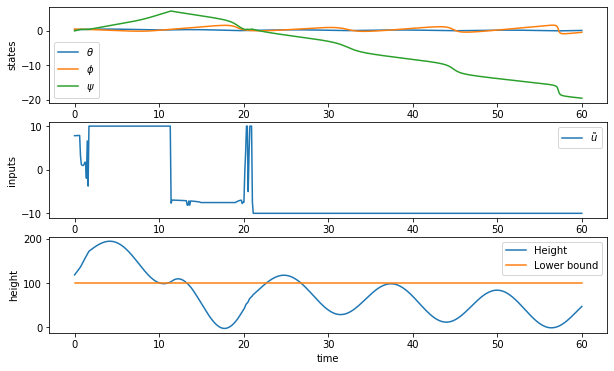

In [16]:
h=[]
for data in res_x_mpc.T:
    h.append([Length*sin(data[0])*cos(data[1])])
    
fig, ax = plt.subplots(3,1, figsize=(10,6))

# plot the states
ax[0].plot(np.linspace(0,60,res_x_mpc.T.shape[0]),res_x_mpc.T[:,0:3])
ax[0].legend([r'$\theta$',r'$\phi$',r'$\psi$'])

ax[1].plot(np.linspace(0,60,res_u_mpc.T.shape[0]),res_u_mpc.T)
ax[1].legend([r'$\tilde{u}$'])
ax[2].plot(np.linspace(0,60,len(h)),h)
#ax[2].plot(np.linspace(0,60,res_u_mpc.T.shape[0]),400*np.ones(res_u_mpc.T.shape))
ax[2].plot(np.linspace(0,60,res_u_mpc.T.shape[0]),100*np.ones(res_u_mpc.T.shape))
ax[2].legend(['Height','Lower bound'])
# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[2].set_ylabel('height')
ax[2].set_xlabel('time')

Text(0, 0.5, '$\\theta$')

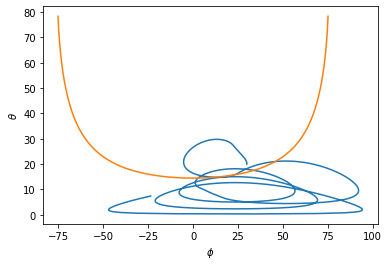

In [17]:
X=np.linspace(-90,90,500)
Y=arcsin(100/Length/cos(X/180*pi))
plt.plot(res_x_mpc.T[:,1]/np.pi*180,res_x_mpc.T[:,0]/np.pi*180)
plt.plot(X,Y/np.pi*180)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')

The average Tension is 127967.34N


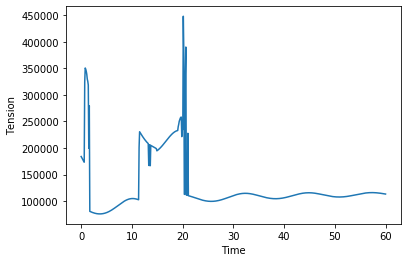

In [18]:
T=[]
sumT=0
t=np.linspace(0,60,res_u_mpc.T.shape[0])
for i in range(res_u_mpc.shape[1]):
    newT=Tf(res_x_mpc.T[i,:],res_u_mpc.T[i,:],t[0])
    T.append(newT)
    sumT+=newT

plt.plot(t,T)
plt.xlabel('Time')
plt.ylabel('Tension')
print('The average Tension is %.2fN' % np.mean(T))